In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

# Algoritmi genetici

Calculul maximului functiei $f: [-5, 10] \times [-3, 7] \rightarrow (0, \infty)$, unde functia este:

$$f(x, y) = cos\left(5\pi x + \frac{10}{1 + y^2}\right) + ln(x^2 + y^4+10)$$


In [2]:
def read_GA_file(input_file_path:str) -> Tuple[List[float],List[float]]:
    """Read the values produced by a genetic algorithm, as found in file given in :param input_file_path:
    :param input_file_path: the input file path, containing output produced by a GA algorithm. 
    :return: a touple two lists. The first list contains the average value of each generation.The second list contains 
    the max value of each generation. Both lists has same length NR."""
    with open(input_file_path, 'rt') as f:
        lines = f.readlines()
    lines = [line for line in lines if len(line.strip()) > 0] # remove empty entries
    lines_start_generation = [i for i, line in enumerate(lines) if line.startswith('#inceput date generatie')]
    lines_end_generation = [i for i, line in enumerate(lines) if line.startswith('#sfarsit date generatie')]
    
    # check for paired start-end notifications
    assert len(lines_start_generation) == len(lines_end_generation) 
    # start block right after end of previous block
    assert np.all(np.array(lines_start_generation[1:]) - 1 == np.array(lines_end_generation[:-1])) 
    
    result_mean_generations = [] # a list of floating point values, with mean of each generation
    result_best_generations = [] # a list of floating point values, with max of each generation
    
    for start_index, end_index in zip(lines_start_generation, lines_end_generation):
        values_current_population = []
        for index_line in range(start_index+2, end_index, 2): # step 2 because we do not use the x and y values of the chromosome
            line = lines[index_line]
            assert line.startswith('valoare: ')
            value_chromosome = float(line.split(': ')[1])
            values_current_population.append(value_chromosome)
        result_mean_generations.append(np.mean(values_current_population))
        result_best_generations.append(np.max(values_current_population))
    
    return result_mean_generations, result_best_generations

In [3]:
def plot_GA(result_mean_generations:List[float], result_best_generations:List[float]) -> None:
    """Plots the evolutions of the genetic populations.
    :return: None"""
    generations = range(len(result_mean_generations))
    f, ax = plt.subplots(figsize=(20, 10))
    
    ax.plot(result_mean_generations, label='Generation mean')
    ax.plot(result_best_generations, 'g', label='Generation best')
    ax.set_xticks(generations)
    ax.set_xlabel('Generation number')
    ax.set_ylabel('Fitness value')
    ax.set_title('Population evolution')
    ax.legend(loc='best')

In [4]:
def f(x:float, y:float)->float:
    """
    The function returns the value of the function f calculated according to x and y given as parameters.    
    :param: x:float
    :param: y:float
    :return: float -> function's value
    """
    
    return np.cos(np.pi * 5 * x + 10/(1 + y**2)) + np.log(x**2 + y**4+10)

In [5]:
def mapping_on_interval(v:int, a:int, b:int, k:int)->float:
    """
    Convert the value of v to a value within the interval [a, b].
    :param: v:int
    :param: a:int
    :param: b:int
    :param: k:int -> the bits' number
    :return: float -> resulted value
    """
    return a+v*(b-a)/(2**k-1)

In [6]:
def crossover_chr(a:int, b:int, t:int, k:int)->Tuple[int,int]:
    """
    Function generates another 2 chromosomes in which first 't' bits from 'a' and from 'b' will be reversed
    between the chromosomes.
    :param: a:int -> first chromosome
    :param: b:int -> second chromosome
    :param: t:int -> number of bits to be reversed
    :param: k:int -> the bits' number
    :return: c,d ->resulted chromosomes
    """
    x=np.binary_repr(a, width=k)
    y=np.binary_repr(b, width=k)
    c="0b"+x[:t]+y[t:]
    d="0b"+y[:t]+x[t:]
    c=int(c, base=2)
    d=int(d, base=2)
    return  c,d

In [7]:
def crossover(population, k, pc = 0.1):
    """
    Function selects some chromosomes from population and makes crossover between them, on pairs.
    :param: population -> the chromosomes' list
    :param: k -> the bits' number
    :param: pc -> the probability of crossover
    """
    new_population=[]
    for i in population:
        nr=np.random.rand(1)+np.finfo(np.float64).eps  
        if(nr<pc):
            new_population.append(i)
            population.remove(i)
    if(len(new_population)>1):
        for i in range(0,len(new_population)-1,2):
            a,b=crossover_chr(new_population[i],new_population[i+1],4,k)
            new_population[i]=a
            new_population[i+1]=b
    new_population=new_population+population
    return new_population

In [27]:
def mutate_chr(a:int, t:int, k:int)->int:
    """
    Function resets/sets a bit from a chromosome.
    :param: a -> the chromosome represented in binary format
    :param: t -> the position to change 
    :param: k -> the bits' number
    """
    x="0b"+np.binary_repr(a, width=k)
    print(x)
    position=k-t+1
    if(x[k-t+1]=='1'):
        x=x[:position]+"0"+x[position+1:]
    else:
        x=x[:position]+"1"+x[position+1:]
    print(x)
    x=int(x,base=2)
    return x

In [28]:
def mutation(population:list, k:int, pm:float = 0.01)->list:
    """
    Function resets/sets a bit from a chromosome.
    :param: population -> the chromosomes' list
    :param: k -> the bits' number
    :param: pm -> the probability of mutation
    """
    for i in range(len(population)):
        for j in range(k):
            nr=np.random.rand(1)*0.1+np.finfo(np.float64).eps
            if nr<pm:
                print(j)
                population[i]=mutate_chr(population[i],j,k)
                print()
            
    return population

In [29]:
def maximum(population, k):
    """
    Function returns the maximum value of the objective function for the given population.
    :param: population -> the chromosomes' list
    :param: k -> the bits' number
    """
    maxi=float('-inf')
    poz=-1
    for j in range(len(population)):
        x=population[j]
        x=np.binary_repr(x, width=k)
        h=f(mapping_on_interval(int("0b"+x,base=2),-5,10,k), mapping_on_interval(int("0b"+x,base=2),-3,7,k))
        maxi=max(maxi,h)
        poz=j
    return maxi,poz

In [30]:
def selection(population, k):
    """
    Function receives population of chromosomes, along with k, the length of a chromosome. It creates and returns a 
    new generation.
    :param: population
    :param: k
    :return: new_population
    """
    y=[]
    for element in population:
        x=np.binary_repr(element, width=k)
        h=f(mapping_on_interval(int('0b'+x,base=2),-5,10,k), mapping_on_interval(int('0b'+x,base=2),-3,7,k))
        y.append(h)
        
    s=np.sum(y)
    p=y/s
    
    cdf=[]
    suma=0
    for i in range(len(p)):
        suma=suma+p[i]
        cdf.append(suma)
    
    h=[]
    new_population=[]
    for i in range(len(population)):
        nr=np.random.rand(1)+np.finfo(np.float64).eps
        for j in range(0,len(cdf)):
            if(nr<cdf[j]):
                new_population.append(population[j])
                h.append(f(mapping_on_interval(int("0b"+x,base=2),-5,10,k), mapping_on_interval(int("0b"+x,base=2),-3,7,k)))
                break
    return new_population

In [31]:
file = open("output.txt", "w")
k=20
n = 50
generatii=20
population = np.random.randint(0,2**k, size=50)
#print('Populatia initiala: ',population,'\n\n')

values=[]
for generatie in range(generatii+1):
    line='#inceput date generatie '+str(generatie)+'\n'
    file.write(line)
    for i in range(n):    
        population=selection(population,k)
        #print('Populatia dupa selectie: ',population,'\n\n')
        population=crossover(population,k,0.1)
        #print('Populatiadupa incrucisare: : ',population,'\n\n')
        population= mutation(population, k, 0.01)
        #print('Populatia  dupa mutatie: ',population,'\n\n')
        
        maxim,poz=maximum(population,k)
        nr_x=mapping_on_interval(population[poz],-5,10,k)
        nr_y=mapping_on_interval(population[poz],-3,7,k)
        line='cromozom: x=' + str(nr_x) +' y=' + str(nr_y) +'\n' + 'valoare: '+ str(maxim)+'\n'
        file.write(line)
    line='#sfarsit date generatie '+str(generatie)+'\n'
    file.write(line)
file.close()

5
0b01110010110101010001
0b01110010110101110001

9
0b01110010110101110001
0b01110010111101110001

2
0b11000001100001010110
0b11000001100001010010

5
0b11000001100001010010
0b11000001100001110010

18
0b11000001100001110010
0b10000001100001110010

1
0b01000111100110001011
0b01000111100110001001

3
0b01000111100110001001
0b01000111100110000001

4
0b01000111100110000001
0b01000111100110010001

9
0b11001100110110111011
0b11001100111110111011

0
0b10100010011001010101
0b10100010011001010100

18
0b10100010011001010100
0b11100010011001010100

4
0b00101100101011010100
0b00101100101011000100

17
0b00101100101011000100
0b00001100101011000100

3
0b01001100001000000001
0b01001100001000001001

9
0b01001100001000001001
0b01001100000000001001

10
0b01001100000000001001
0b01001100010000001001

19
0b01001100010000001001
0b11001100010000001001

5
0b01101110101110101000
0b01101110101110001000

14
0b01101110101110001000
0b01101010101110001000

3
0b00010101101010100001
0b00010101101010101001

5
0b0001010110

2
0b11100001100110100110
0b11100001100110100010

7
0b11100001100110100010
0b11100001100100100010

8
0b11100001100100100010
0b11100001100000100010

11
0b11100001100000100010
0b11100001000000100010

12
0b11100001000000100010
0b11100000000000100010

19
0b11100000000000100010
0b01100000000000100010

6
0b11010101001101010111
0b11010101001100010111

10
0b11010101001100010111
0b11010101011100010111

13
0b10001010001001010100
0b10001000001001010100

4
0b11100110010100110110
0b11100110010100100110

8
0b11100110010100100110
0b11100110010000100110

0
0b00010101110010110000
0b00010101110010110001

9
0b00010101110010110001
0b00010101111010110001

11
0b11100110010100110110
0b11100110110100110110

16
0b11111010011110110001
0b11101010011110110001

17
0b11101010011110110001
0b11001010011110110001

14
0b11111111110111110100
0b11111011110111110100

6
0b11110111000100010000
0b11110111000101010000

0
0b11110111000100010000
0b11110111000100010001

3
0b11110111000100010001
0b11110111000100011001

6
0b1111011

9
0b11101010000101000100
0b11101010001101000100

12
0b11101010001101000100
0b11101011001101000100

13
0b11101011001101000100
0b11101001001101000100

9
0b10011111010011110010
0b10011111011011110010

2
0b11101101001011001010
0b11101101001011001110

7
0b11101101001011001110
0b11101101001001001110

11
0b11101101001001001110
0b11101101101001001110

16
0b11101101101001001110
0b11111101101001001110

18
0b11111101101001001110
0b10111101101001001110

10
0b10011111010011110010
0b10011111000011110010

2
0b11110111001101010000
0b11110111001101010100

13
0b11001100010110100101
0b11001110010110100101

17
0b11001110010110100101
0b11101110010110100101

1
0b10001101001100010101
0b10001101001100010111

13
0b10001101001100010111
0b10001111001100010111

5
0b11101111101101111100
0b11101111101101011100

13
0b11101111101101011100
0b11101101101101011100

18
0b11101101101101011100
0b10101101101101011100

5
0b11000111001100010111
0b11000111001100110111

10
0b11101010111110000011
0b11101010101110000011

12
0b111

15
0b11101001101101001111
0b11100001101101001111

19
0b11100001101101001111
0b01100001101101001111

0
0b10111001000111010110
0b10111001000111010111

4
0b10111001000111010111
0b10111001000111000111

0
0b11101001001111000110
0b11101001001111000111

5
0b11101001001111000111
0b11101001001111100111

5
0b00000100001011100010
0b00000100001011000010

6
0b00000100001011000010
0b00000100001010000010

10
0b00000100001010000010
0b00000100011010000010

12
0b00000100011010000010
0b00000101011010000010

0
0b10111110101110001111
0b10111110101110001110

13
0b10111110101110001110
0b10111100101110001110

16
0b10111100101110001110
0b10101100101110001110

9
0b11111001011111010110
0b11111001010111010110

16
0b11111001010111010110
0b11101001010111010110

8
0b11111001101101001101
0b11111001101001001101

19
0b11111001101001001101
0b01111001101001001101

12
0b11111010010011100101
0b11111011010011100101

2
0b11001001100111010100
0b11001001100111010000

11
0b11001001100111010000
0b11001001000111010000

9
0b111010

0b10011100100011110101

2
0b11000011010011100101
0b11000011010011100001

16
0b11000011010011100001
0b11010011010011100001

5
0b11111100101011011111
0b11111100101011111111

16
0b11111100101011111111
0b11101100101011111111

1
0b11000011010011100101
0b11000011010011100111

2
0b11000011010011100111
0b11000011010011100011

3
0b11000011010011100011
0b11000011010011101011

10
0b11000011010011101011
0b11000011000011101011

15
0b11110011000110111110
0b11111011000110111110

3
0b11111010010011100101
0b11111010010011101101

14
0b11111010010011101101
0b11111110010011101101

15
0b11111110010011101101
0b11110110010011101101

17
0b11110110010011101101
0b11010110010011101101

4
0b10101000101110000111
0b10101000101110010111

7
0b10101000101110010111
0b10101000101100010111

10
0b11010100000110101000
0b11010100010110101000

12
0b11010100010110101000
0b11010101010110101000

1
0b11111111110111000001
0b11111111110111000011

11
0b11111111110111000011
0b11111111010111000011

2
0b10000101010110010101
0b10000101

19
0b10111001010101101110
0b00111001010101101110

9
0b11011010000001111111
0b11011010001001111111

12
0b11011010001001111111
0b11011011001001111111

13
0b11011011001001111111
0b11011001001001111111

14
0b11011001001001111111
0b11011101001001111111

17
0b11011101001001111111
0b11111101001001111111

1
0b11111010101111110101
0b11111010101111110111

3
0b11111010101111110111
0b11111010101111111111

4
0b11111010101111111111
0b11111010101111101111

13
0b11111010101111101111
0b11111000101111101111

0
0b11000011001011111111
0b11000011001011111110

2
0b11000011001011111110
0b11000011001011111010

15
0b11000011001011111010
0b11001011001011111010

1
0b11010111000100100011
0b11010111000100100001

7
0b11010111000100100001
0b11010111000110100001

18
0b11010111000110100001
0b10010111000110100001

4
0b11000011001011111011
0b11000011001011101011

0
0b01011011110011000101
0b01011011110011000100

15
0b01011011110011000100
0b01010011110011000100

18
0b01010011110011000100
0b00010011110011000100

0
0b010110

0b11010101111101001101
0b11011101111101001101

17
0b11011101111101001101
0b11111101111101001101

19
0b11111101111101001101
0b01111101111101001101

12
0b11100000000011101111
0b11100001000011101111

13
0b11100001000011101111
0b11100011000011101111

14
0b11100011000011101111
0b11100111000011101111

11
0b10110101011110110000
0b10110101111110110000

18
0b10110101111110110000
0b11110101111110110000

11
0b11100000001011011011
0b11100000101011011011

13
0b11100000101011011011
0b11100010101011011011

3
0b11100000001011011011
0b11100000001011010011

4
0b11100000001011010011
0b11100000001011000011

5
0b11100000001011000011
0b11100000001011100011

11
0b11111100110110010101
0b11111100010110010101

0
0b11010101001111110100
0b11010101001111110101

2
0b11100000000011101111
0b11100000000011101011

6
0b11100000000011101011
0b11100000000010101011

0
0b11100000001011011011
0b11100000001011011010

6
0b11100000001011011010
0b11100000001010011010

8
0b11100000001010011010
0b11100000001110011010

0
0b10100000


14
0b11111110001110100010
0b11111010001110100010

7
0b11011111010011111010
0b11011111010001111010

1
0b11100000011101011111
0b11100000011101011101

6
0b11100000011101011101
0b11100000011100011101

19
0b11111100011001010000
0b01111100011001010000

0
0b11001011010011111011
0b11001011010011111010

2
0b11001011010011111010
0b11001011010011111110

4
0b11001011010011111110
0b11001011010011101110

6
0b11001011010011101110
0b11001011010010101110

7
0b11001011010010101110
0b11001011010000101110

9
0b11001011010000101110
0b11001011011000101110

17
0b11001011011000101110
0b11101011011000101110

4
0b11100000011101011111
0b11100000011101001111

7
0b11100000011101001111
0b11100000011111001111

18
0b11100000011111001111
0b10100000011111001111

19
0b10100000011111001111
0b00100000011111001111

11
0b10011101100011001101
0b10011101000011001101

16
0b10011101000011001101
0b10001101000011001101

2
0b11100000101110011010
0b11100000101110011110

3
0b11011101000101001101
0b11011101000101000101

12
0b1111000

0b11000001100110110101
0b11000101100110110101

16
0b11100010000111100010
0b11110010000111100010

12
0b11100010000111100000
0b11100011000111100000

3
0b11110100001011110010
0b11110100001011111010

7
0b11110100001011111010
0b11110100001001111010

6
0b11000000001101100010
0b11000000001100100010

5
0b11110100001011110010
0b11110100001011010010

14
0b11110100001011010010
0b11110000001011010010

2
0b00001001000001001100
0b00001001000001001000

12
0b11000011011000001010
0b11000010011000001010

0
0b10000111001011000100
0b10000111001011000101

11
0b10000111001011000101
0b10000111101011000101

0
0b11000001100111100101
0b11000001100111100100

8
0b11000001100111100100
0b11000001100011100100

11
0b01111110001110101101
0b01111110101110101101

12
0b01111110101110101101
0b01111111101110101101

1
0b11000001100110110101
0b11000001100110110111

5
0b11000001100110110111
0b11000001100110010111

5
0b11010011001100010111
0b11010011001100110111

13
0b11010011001100110111
0b11010001001100110111

15
0b110000000

0b01000101100110110001

12
0b01000101100110110001
0b01000100100110110001

15
0b01000100100110110001
0b01001100100110110001

17
0b01001100100110110001
0b01101100100110110001

18
0b01101100100110110001
0b00101100100110110001

12
0b11101010110111100011
0b11101011110111100011

17
0b11101011110111100011
0b11001011110111100011

5
0b11110000001001110111
0b11110000001001010111

2
0b11010001010111110100
0b11010001010111110000

10
0b11010001010111110000
0b11010001000111110000

1
0b11110010000100110101
0b11110010000100110111

6
0b00100000010110110101
0b00100000010111110101

7
0b11001011000111001011
0b11001011000101001011

10
0b11001011000101001011
0b11001011010101001011

11
0b11001011010101001011
0b11001011110101001011

13
0b11001011110101001011
0b11001001110101001011

0
0b11000000011010011001
0b11000000011010011000

7
0b11000000011010011000
0b11000000011000011000

11
0b11000000011000011000
0b11000000111000011000

12
0b11000000111000011000
0b11000001111000011000

19
0b11000001111000011000
0b01000

4
0b01101110011110010101
0b01101110011110000101

9
0b01101110011110000101
0b01101110010110000101

13
0b01101110010110000101
0b01101100010110000101

15
0b01101100010110000101
0b01100100010110000101

17
0b01100100010110000101
0b01000100010110000101

4
0b11000010110110000111
0b11000010110110010111

19
0b11000010110110010111
0b01000010110110010111

5
0b11101100001110011101
0b11101100001110111101

6
0b11101100001110111101
0b11101100001111111101

11
0b11101100001111111101
0b11101100101111111101

13
0b11101100101111111101
0b11101110101111111101

10
0b11001001111010001110
0b11001001101010001110

11
0b11001001101010001110
0b11001001001010001110

15
0b11001001001010001110
0b11000001001010001110

5
0b11101100001110011101
0b11101100001110111101

8
0b11101100001110111101
0b11101100001010111101

9
0b11101100001010111101
0b11101100000010111101

10
0b11101100000010111101
0b11101100010010111101

14
0b11101100010010111101
0b11101000010010111101

5
0b11011011110111010110
0b11011011110111110110

6
0b11011

0b01111110101101011101

18
0b01111110101101011101
0b00111110101101011101

2
0b11101111000110011101
0b11101111000110011001

4
0b11101111000110011001
0b11101111000110001001

7
0b11010011010110110111
0b11010011010100110111

11
0b11010011010100110111
0b11010011110100110111

13
0b11010011110100110111
0b11010001110100110111

2
0b11101111000110011101
0b11101111000110011001

19
0b11110010010010010000
0b01110010010010010000

7
0b11101101000001110000
0b11101101000011110000

16
0b11101101000011110000
0b11111101000011110000

16
0b11101101000001110000
0b11111101000001110000

10
0b11101001011100100001
0b11101001001100100001

3
0b11101100000010110101
0b11101100000010111101

5
0b11101100000010111101
0b11101100000010011101

19
0b11101100000010011101
0b01101100000010011101

3
0b11001110110101101010
0b11001110110101100010

5
0b11001110110101100010
0b11001110110101000010

9
0b11001110110101000010
0b11001110111101000010

13
0b11001110111101000010
0b11001100111101000010

15
0b11001100111101000010
0b11000100

6
0b11101100100111011010
0b11101100100110011010

10
0b11001111000001100011
0b11001111010001100011

19
0b11001111010001100011
0b01001111010001100011

11
0b11001000001010000100
0b11001000101010000100

2
0b11010100110101010110
0b11010100110101010010

9
0b11010100110101010010
0b11010100111101010010

4
0b11001000001010000100
0b11001000001010010100

7
0b11001000001010010100
0b11001000001000010100

8
0b11101100100111010010
0b11101100100011010010

13
0b11101100100011010010
0b11101110100011010010

2
0b11001001010101111110
0b11001001010101111010

18
0b11001001010101111010
0b10001001010101111010

0
0b11010111110111000000
0b11010111110111000001

19
0b11010111110111000001
0b01010111110111000001

16
0b11101000101010010110
0b11111000101010010110

9
0b10111011101010000001
0b10111011100010000001

13
0b10111011100010000001
0b10111001100010000001

16
0b10111001100010000001
0b10101001100010000001

13
0b11110010110000010010
0b11110000110000010010

17
0b11100011111110000011
0b11000011111110000011

0
0b11101

0b00101000011010100100
0b00101010011010100100

0
0b11110000101001001000
0b11110000101001001001

19
0b11110000101001001001
0b01110000101001001001

0
0b11111100011110010000
0b11111100011110010001

1
0b11111100011110010001
0b11111100011110010011

8
0b11111100011110010011
0b11111100011010010011

12
0b11111100011010010011
0b11111101011010010011

15
0b11111101011010010011
0b11110101011010010011

0
0b11111010001001011101
0b11111010001001011100

3
0b11111010001001011100
0b11111010001001010100

11
0b11111010001001010100
0b11111010101001010100

15
0b11101101011110001010
0b11100101011110001010

5
0b11101111010000101010
0b11101111010000001010

7
0b11101111010000001010
0b11101111010010001010

10
0b11101111010010001010
0b11101111000010001010

14
0b11101111000010001010
0b11101011000010001010

13
0b11101111010000101010
0b11101101010000101010

0
0b11001110111100110011
0b11001110111100110010

7
0b11001101111110011110
0b11001101111100011110

12
0b11001101111100011110
0b11001100111100011110

3
0b111111000


6
0b11010110001101101001
0b11010110001100101001

8
0b11010110001100101001
0b11010110001000101001

3
0b11001101110111111100
0b11001101110111110100

6
0b11001101110111110100
0b11001101110110110100

7
0b11001101110110110100
0b11001101110100110100

16
0b11100001101101000010
0b11110001101101000010

18
0b11110001101101000010
0b10110001101101000010

0
0b10100111111010110001
0b10100111111010110000

8
0b10100111111010110000
0b10100111111110110000

10
0b11010001011111101001
0b11010001001111101001

12
0b11010001001111101001
0b11010000001111101001

19
0b11010000001111101001
0b01010000001111101001

6
0b11101001000000010010
0b11101001000001010010

17
0b11101001000001010010
0b11001001000001010010

16
0b10100110101010000100
0b10110110101010000100

18
0b10110110101010000100
0b11110110101010000100

1
0b11111111110100101100
0b11111111110100101110

6
0b11111111110100101110
0b11111111110101101110

7
0b11111111110101101110
0b11111111110111101110

16
0b11111111110111101110
0b11101111110111101110

6
0b101001

0b10010110011001000010
0b10010110011001000110

4
0b10010110011001000110
0b10010110011001010110

8
0b10010110011001010110
0b10010110011101010110

16
0b10010110011101010110
0b10000110011101010110

18
0b10000110011101010110
0b11000110011101010110

7
0b11010111010101100100
0b11010111010111100100

6
0b11111101010011110010
0b11111101010010110010

15
0b11111101010010110010
0b11110101010010110010

3
0b10100011100101111101
0b10100011100101110101

5
0b10100011100101110101
0b10100011100101010101

9
0b10100011100101010101
0b10100011101101010101

3
0b10110110010010010101
0b10110110010010011101

13
0b10110110010010011101
0b10110100010010011101

0
0b10101101110110101100
0b10101101110110101101

13
0b10101101110110101101
0b10101111110110101101

16
0b10101111110110101101
0b10111111110110101101

1
0b11100000011110111111
0b11100000011110111101

3
0b11010101100011011010
0b11010101100011010010

2
0b11001111001010001100
0b11001111001010001000

6
0b11001111001010001000
0b11001111001011001000

9
0b110011110010

0b11110111111010101110

19
0b11110111111010101110
0b01110111111010101110

4
0b11100110101010111100
0b11100110101010101100

5
0b11100110101010101100
0b11100110101010001100

11
0b11100110101010001100
0b11100110001010001100

14
0b11100110001010001100
0b11100010001010001100

15
0b11100010001010001100
0b11101010001010001100

9
0b01100110101010001100
0b01100110100010001100

10
0b11100001110001011110
0b11100001100001011110

17
0b11100001100001011110
0b11000001100001011110

2
0b10110110110110100101
0b10110110110110100001

13
0b10110110110110100001
0b10110100110110100001

13
0b01100111001110100111
0b01100101001110100111

18
0b11111100000001000101
0b10111100000001000101

4
0b11111010000110010101
0b11111010000110000101

13
0b11111010000110000101
0b11111000000110000101

14
0b11111000000110000101
0b11111100000110000101

17
0b11111100000110000101
0b11011100000110000101

3
0b10100101010000111011
0b10100101010000110011

15
0b10100101010000110011
0b10101101010000110011

3
0b11010011000010000010
0b11010

4
0b11000110101010011010
0b11000110101010001010

6
0b11000110101010001010
0b11000110101011001010

13
0b10110110000010101001
0b10110100000010101001

14
0b10110100000010101001
0b10110000000010101001

16
0b10110000000010101001
0b10100000000010101001

17
0b10100000000010101001
0b10000000000010101001

4
0b11111100110000110010
0b11111100110000100010

9
0b11111100000101111101
0b11111100001101111101

11
0b11111100001101111101
0b11111100101101111101

0
0b11110110110100111101
0b11110110110100111100

6
0b11110110110100111100
0b11110110110101111100

0
0b11010100111001011001
0b11010100111001011000

17
0b11010100111001011000
0b11110100111001011000

15
0b11010101111001010001
0b11011101111001010001

0
0b11110100000011011100
0b11110100000011011101

4
0b11110100000011011101
0b11110100000011001101

12
0b11110100000011001101
0b11110101000011001101

5
0b11110100000011011100
0b11110100000011111100

15
0b11110100000011111100
0b11111100000011111100

17
0b11111100000011111100
0b11011100000011111100

1
0b110110

4
0b11011111010110100111
0b11011111010110110111

9
0b11011111010110110111
0b11011111011110110111

11
0b11011111011110110111
0b11011111111110110111

3
0b11110100110111011110
0b11110100110111010110

1
0b11110100010100100010
0b11110100010100100000

4
0b11110100010100100000
0b11110100010100110000

7
0b11110010100010000000
0b11110010100000000000

8
0b11110010100000000000
0b11110010100100000000

17
0b11110010100100000000
0b11010010100100000000

12
0b11000011110110001111
0b11000010110110001111

12
0b11101111110111100111
0b11101110110111100111

14
0b11101110110111100111
0b11101010110111100111

2
0b11100011010011110001
0b11100011010011110101

5
0b11101100100000001101
0b11101100100000101101

12
0b11101100100000101101
0b11101101100000101101

15
0b11101001010000110010
0b11100001010000110010

17
0b11100001010000110010
0b11000001010000110010

6
0b11011101010101001010
0b11011101010100001010

0
0b11100100100000011101
0b11100100100000011100

7
0b11100100100000011100
0b11100100100010011100

18
0b1100101

4
0b11011110001100001110
0b11011110001100011110

12
0b11011110001100011110
0b11011111001100011110

16
0b11011111001100011110
0b11001111001100011110

8
0b11110010100110110100
0b11110010100010110100

18
0b11110010100010110100
0b10110010100010110100

7
0b11001100100000101101
0b11001100100010101101

10
0b11001100100010101101
0b11001100110010101101

15
0b11001100110010101101
0b11000100110010101101

0
0b11010011011100110010
0b11010011011100110011

5
0b11010011011100110011
0b11010011011100010011

10
0b11010011011100010011
0b11010011001100010011

10
0b10111110001100001110
0b10111110011100001110

0
0b11101011101101111100
0b11101011101101111101

1
0b11101011101101111101
0b11101011101101111111

9
0b11101011101101111111
0b11101011100101111111

13
0b11101011100101111111
0b11101001100101111111

19
0b11101001100101111111
0b01101001100101111111

15
0b11111001100010101101
0b11110001100010101101

10
0b11111000100101110000
0b11111000110101110000

12
0b11111000110101110000
0b11111001110101110000

19
0b110

0b11110000101010100111

19
0b11110000101010100111
0b01110000101010100111

1
0b11001000111100010001
0b11001000111100010011

8
0b11001000111100010011
0b11001000111000010011

14
0b11001000111000010011
0b11001100111000010011

16
0b11001100111000010011
0b11011100111000010011

18
0b11011100111000010011
0b10011100111000010011

11
0b10111000111010010100
0b10111000011010010100

16
0b10111000011010010100
0b10101000011010010100

17
0b10101000011010010100
0b10001000011010010100

19
0b10001000011010010100
0b00001000011010010100

0
0b10111000111010010100
0b10111000111010010101

4
0b10111000111010010101
0b10111000111010000101

10
0b10111000111010000101
0b10111000101010000101

11
0b10111000101010000101
0b10111000001010000101

4
0b11110000111000101101
0b11110000111000111101

10
0b11110000111000111101
0b11110000101000111101

18
0b11110000101000111101
0b10110000101000111101

1
0b10100100111000101101
0b10100100111000101111

13
0b10100100111000101111
0b10100110111000101111

4
0b10101000100000011001
0b10101

6
0b10110001000000001111
0b10110001000001001111

11
0b10110001000001001111
0b10110001100001001111

19
0b10110001100001001111
0b00110001100001001111

0
0b11110000010000011100
0b11110000010000011101

3
0b11110000010000011101
0b11110000010000010101

7
0b11110000010000010101
0b11110000010010010101

6
0b11011110110100101101
0b11011110110101101101

8
0b11011110110101101101
0b11011110110001101101

13
0b11011110110001101101
0b11011100110001101101

0
0b11000100101010111010
0b11000100101010111011

8
0b11000100101010111011
0b11000100101110111011

12
0b00010000100001101100
0b00010001100001101100

1
0b10011001000010100010
0b10011001000010100000

3
0b10011001000010100000
0b10011001000010101000

7
0b11110000010110101011
0b11110000010100101011

14
0b11110000010100101011
0b11110100010100101011

0
0b00000100100000101100
0b00000100100000101101

19
0b00000100100000101101
0b10000100100000101101

3
0b10100100100010011001
0b10100100100010010001

9
0b10100100100010010001
0b10100100101010010001

15
0b101001001

0b11101101101101101111
0b11101101101101101011

6
0b11101101101101101011
0b11101101101100101011

6
0b11010010110001010100
0b11010010110000010100

14
0b11010010110000010100
0b11010110110000010100

17
0b11010110110000010100
0b11110110110000010100

3
0b11100010000100110110
0b11100010000100111110

15
0b11100010000100111110
0b11101010000100111110

2
0b11000110010110111100
0b11000110010110111000

7
0b11000110010110111000
0b11000110010100111000

0
0b00010100110111110010
0b00010100110111110011

5
0b00010100110111110011
0b00010100110111010011

0
0b11001000111011000111
0b11001000111011000110

5
0b11001000111011000110
0b11001000111011100110

13
0b11001000111011100110
0b11001010111011100110

8
0b00101000110011000111
0b00101000110111000111

0
0b10111111010001101001
0b10111111010001101000

14
0b10111111010001101000
0b10111011010001101000

6
0b11010001001010000111
0b11010001001011000111

19
0b11011000100110110101
0b01011000100110110101

11
0b11010001001010000111
0b11010001101010000111

14
0b1101000110


14
0b10111011101001101001
0b10111111101001101001

10
0b11111101100011101011
0b11111101110011101011

16
0b11111101110011101011
0b11101101110011101011

3
0b00010101001000011011
0b00010101001000010011

12
0b00010101001000010011
0b00010100001000010011

16
0b00010100001000010011
0b00000100001000010011

8
0b11010100011100001000
0b11010100011000001000

11
0b11010100011000001000
0b11010100111000001000

15
0b11010100111000001000
0b11011100111000001000

18
0b11011100111000001000
0b10011100111000001000

9
0b11010110110100001000
0b11010110111100001000

11
0b11010110111100001000
0b11010110011100001000

16
0b11010110011100001000
0b11000110011100001000

6
0b10110011101001110000
0b10110011101000110000

13
0b10110011101000110000
0b10110001101000110000

0
0b00010000110111010011
0b00010000110111010010

4
0b00010000110111010010
0b00010000110111000010

8
0b00010000110111000010
0b00010000110011000010

11
0b00010000110011000010
0b00010000010011000010

10
0b11111111110000010110
0b11111111100000010110

11
0b1

0b11101000001010011110
0b11101100001010011110

18
0b11101100001010011110
0b10101100001010011110

9
0b01111100100110010000
0b01111100101110010000

11
0b01111100101110010000
0b01111100001110010000

18
0b01111100001110010000
0b00111100001110010000

13
0b11010110000101000101
0b11010100000101000101

0
0b10101100001001010011
0b10101100001001010010

11
0b10101100001001010010
0b10101100101001010010

4
0b11010110000101000101
0b11010110000101010101

9
0b11010110000101010101
0b11010110001101010101

14
0b11010110001101010101
0b11010010001101010101

4
0b00010000000011000000
0b00010000000011010000

6
0b00010000000011010000
0b00010000000010010000

16
0b00010000000010010000
0b00000000000010010000

9
0b11111101001000110100
0b11111101000000110100

17
0b11111101000000110100
0b11011101000000110100

1
0b10110101001100010100
0b10110101001100010110

3
0b10101110011001111001
0b10101110011001110001

7
0b10101110011001110001
0b10101110011011110001

12
0b10101110011011110001
0b10101111011011110001

18
0b10101111

0b10000110111000101111

7
0b10100001100010000111
0b10100001100000000111

9
0b11011101001111011101
0b11011101000111011101

19
0b11011101000111011101
0b01011101000111011101

15
0b11001011101001010010
0b11000011101001010010

11
0b11101101100100110100
0b11101101000100110100

12
0b11101101000100110100
0b11101100000100110100

14
0b10101010100100010010
0b10101110100100010010

5
0b10110010010100011111
0b10110010010100111111

13
0b11001011010100011111
0b11001001010100011111

1
0b11100011101110010111
0b11100011101110010101

14
0b11100011101110010101
0b11100111101110010101

5
0b10110011101101110000
0b10110011101101010000

18
0b10110011101101010000
0b11110011101101010000

6
0b11010010000010000011
0b11010010000011000011

17
0b11010010000011000011
0b11110010000011000011

18
0b11110010000011000011
0b10110010000011000011

11
0b11101011110100110111
0b11101011010100110111

13
0b11101011010100110111
0b11101001010100110111

0
0b11101101001001010001
0b11101101001001010000

9
0b11101101001001010000
0b111011

7
0b01101000101000110000
0b01101000101010110000

16
0b01101000101010110000
0b01111000101010110000

18
0b11111011101111010111
0b10111011101111010111

13
0b11000001010000011101
0b11000011010000011101

13
0b11101111000111110011
0b11101101000111110011

11
0b10011101011111011001
0b10011101111111011001

8
0b10100111010011110011
0b10100111010111110011

9
0b10100111010111110011
0b10100111011111110011

13
0b10100111011111110011
0b10100101011111110011

12
0b11110001000100001100
0b11110000000100001100

4
0b11111011101111010111
0b11111011101111000111

6
0b11111011101111000111
0b11111011101110000111

13
0b11111011101110000111
0b11111001101110000111

14
0b11111001101110000111
0b11111101101110000111

16
0b11111101101110000111
0b11101101101110000111

18
0b11101101101110000111
0b10101101101110000111

1
0b11010101010000011111
0b11010101010000011101

11
0b11010101010000011101
0b11010101110000011101

8
0b11101111000111110011
0b11101111000011110011

18
0b11101111000011110011
0b10101111000011110011

2
0b100

0b11100010011111010011

9
0b11101101011111101111
0b11101101010111101111

0
0b11100100110111110011
0b11100100110111110010

4
0b11100100110111110010
0b11100100110111100010

6
0b11100100110111100010
0b11100100110110100010

1
0b10100011100110100001
0b10100011100110100011

2
0b10100011100110100011
0b10100011100110100111

5
0b10100011100110100111
0b10100011100110000111

7
0b10100011100110000111
0b10100011100100000111

9
0b10100011100100000111
0b10100011101100000111

11
0b10100011101100000111
0b10100011001100000111

12
0b10100011001100000111
0b10100010001100000111

15
0b10100010001100000111
0b10101010001100000111

19
0b10101010001100000111
0b00101010001100000111

6
0b10100100010001101100
0b10100100010000101100

12
0b10100100010000101100
0b10100101010000101100

14
0b11100100110111101011
0b11100000110111101011

16
0b11100000110111101011
0b11110000110111101011

19
0b11110000110111101011
0b01110000110111101011

3
0b11111011100101011111
0b11111011100101010111

5
0b11111011100101010111
0b1111101110

11
0b11100110101011000100
0b11100110001011000100

13
0b11100110001011000100
0b11100100001011000100

5
0b11000111101000100011
0b11000111101000000011

7
0b01111000010011100101
0b01111000010001100101

18
0b11000111101000100011
0b10000111101000100011

19
0b10000111101000100011
0b00000111101000100011

4
0b11001100101111000000
0b11001100101111010000

12
0b11001100101111010000
0b11001101101111010000

19
0b11001101101111010000
0b01001101101111010000

17
0b10111111110000100011
0b10011111110000100011

1
0b11000000000011100000
0b11000000000011100010

3
0b11000000000011100010
0b11000000000011101010

9
0b11000000000011101010
0b11000000001011101010

13
0b11000000001011101010
0b11000010001011101010

15
0b11000010001011101010
0b11001010001011101010

4
0b11111111111111100111
0b11111111111111110111

18
0b11111111111111110111
0b10111111111111110111

0
0b11100001110110100011
0b11100001110110100010

12
0b11100001110110100010
0b11100000110110100010

1
0b11011100010110010111
0b11011100010110010101

13
0b1101

0b11001001111111101010
0b11001001111111101000

2
0b11001001111111101000
0b11001001111111101100

17
0b11001001111111101100
0b11101001111111101100

2
0b11001000001010110101
0b11001000001010110001

13
0b11001000001010110001
0b11001010001010110001

15
0b11001010001010110001
0b11000010001010110001

1
0b11000001111111100010
0b11000001111111100000

4
0b11111110100000111011
0b11111110100000101011

14
0b11111110100000101011
0b11111010100000101011

11
0b11001000001010110101
0b11001000101010110101

14
0b11001000101010110101
0b11001100101010110101

18
0b11001100101010110101
0b10001100101010110101

8
0b01100100011110110011
0b01100100011010110011

13
0b01100100011010110011
0b01100110011010110011

14
0b01100110011010110011
0b01100010011010110011

14
0b11000001111111100010
0b11000101111111100010

6
0b11001001111111101010
0b11001001111110101010

18
0b11010101010111100011
0b10010101010111100011

4
0b10101010100100110001
0b10101010100100100001

8
0b10101010100100100001
0b10101010100000100001

10
0b101010


9
0b11001111000000000111
0b11001111001000000111

12
0b11001111001000000111
0b11001110001000000111

17
0b11001110001000000111
0b11101110001000000111

12
0b11010110001010111111
0b11010111001010111111

19
0b11010111001010111111
0b01010111001010111111

5
0b11010111000000101101
0b11010111000000001101

16
0b11010111000000001101
0b11000111000000001101

19
0b10101111000001100111
0b00101111000001100111

14
0b11110101010011011001
0b11110001010011011001

0
0b11000110001000110101
0b11000110001000110100

16
0b11000110001000110100
0b11010110001000110100

18
0b11010110001000110100
0b10010110001000110100

2
0b11011100111011011111
0b11011100111011011011

2
0b11011110111010010110
0b11011110111010010010

3
0b11011110111010010010
0b11011110111010011010

9
0b11011110111010011010
0b11011110110010011010

10
0b11011110110010011010
0b11011110100010011010

2
0b11011100111011011011
0b11011100111011011111

7
0b11011100111011011111
0b11011100111001011111

10
0b11011100111001011111
0b11011100101001011111

14
0b110

0b11000011111011100101
0b11000011111011100001

4
0b11000011111011100001
0b11000011111011110001

10
0b11000011111011110001
0b11000011101011110001

15
0b11000011101011110001
0b11001011101011110001

6
0b11001001000101100111
0b11001001000100100111

11
0b10111011011111111100
0b10111011111111111100

13
0b10111011111111111100
0b10111001111111111100

18
0b10111001111111111100
0b11111001111111111100

2
0b11001001101011001101
0b11001001101011001001

12
0b11001001101011001001
0b11001000101011001001

5
0b10000000001000101111
0b10000000001000001111

19
0b10000000001000001111
0b00000000001000001111

6
0b11001001101011001101
0b11001001101010001101

7
0b11001001101010001101
0b11001001101000001101

12
0b11001001101000001101
0b11001000101000001101

1
0b11000010101011100101
0b11000010101011100111

0
0b11001001000101100111
0b11001001000101100110

8
0b11001001000101100110
0b11001001000001100110

17
0b11001001000001100110
0b11101001000001100110

8
0b11001001000101100111
0b11001001000001100111

4
0b111010000

0b11101001110001001011

3
0b11101001110001001011
0b11101001110001000011

11
0b11101001110001000011
0b11101001010001000011

1
0b11001011101011010000
0b11001011101011010010

12
0b11001011101011010010
0b11001010101011010010

17
0b11001010101011010010
0b11101010101011010010

1
0b11101010100011010011
0b11101010100011010001

19
0b11101010100011010001
0b01101010100011010001

14
0b11100000101111001111
0b11100100101111001111

6
0b11100011011111100101
0b11100011011110100101

9
0b11100011011110100101
0b11100011010110100101

10
0b11100011010110100101
0b11100011000110100101

13
0b11100011000110100101
0b11100001000110100101

19
0b11100001000110100101
0b01100001000110100101

6
0b01110011111011100000
0b01110011111010100000

17
0b01110011111010100000
0b01010011111010100000

4
0b11101011110001000010
0b11101011110001010010

19
0b11101011110001010010
0b01101011110001010010

1
0b11100011100011010001
0b11100011100011010011

10
0b11100011100011010011
0b11100011110011010011

14
0b11100011110011010011
0b111001

10
0b10100000111000010010
0b10100000101000010010

16
0b10100000101000010010
0b10110000101000010010

9
0b10010000110100110111
0b10010000111100110111

15
0b10010000111100110111
0b10011000111100110111

10
0b10010001110100110000
0b10010001100100110000

18
0b10010001100100110000
0b11010001100100110000

18
0b01010000110100110110
0b00010000110100110110

2
0b10011011010000010000
0b10011011010000010100

5
0b10011011010000010100
0b10011011010000110100

4
0b10101101101000011001
0b10101101101000001001

5
0b10101101101000001001
0b10101101101000101001

14
0b10101101101000101001
0b10101001101000101001

1
0b11101000011001011000
0b11101000011001011010

19
0b11101000011001011010
0b01101000011001011010

3
0b10100000110110100110
0b10100000110110101110

3
0b10100000111000000010
0b10100000111000001010

10
0b11111001011001011000
0b11111001001001011000

16
0b10010110101011010100
0b10000110101011010100

0
0b10100000110110100110
0b10100000110110100111

6
0b10101101111110111011
0b10101101111111111011

18
0b10101

0b11011100011010011101

15
0b11011100011010011101
0b11010100011010011101

17
0b11001011011111111100
0b11101011011111111100

9
0b11111000100110000100
0b11111000101110000100

4
0b11110000110110111000
0b11110000110110101000

12
0b11110000110110101000
0b11110001110110101000

4
0b11100010110010011001
0b11100010110010001001

10
0b11100010110010001001
0b11100010100010001001

2
0b11000000011101110110
0b11000000011101110010

10
0b11000000011101110010
0b11000000001101110010

1
0b11111000100110000100
0b11111000100110000110

2
0b10110100011010011010
0b10110100011010011110

8
0b10110100011010011110
0b10110100011110011110

16
0b10110100011110011110
0b10100100011110011110

14
0b11110000110110111000
0b11110100110110111000

7
0b11101001000100010010
0b11101001000110010010

9
0b11101001000110010010
0b11101001001110010010

0
0b11110000101011010110
0b11110000101011010111

4
0b11110000101011010111
0b11110000101011000111

19
0b11110000101011000111
0b01110000101011000111

16
0b10111001001000001001
0b101010010

0b11100100111110011011
0b11101100111110011011

2
0b11110001000100000100
0b11110001000100000000

4
0b11110001000100000000
0b11110001000100010000

1
0b11101111111110010110
0b11101111111110010100

12
0b11101111111110010100
0b11101110111110010100

10
0b10101101000011110001
0b10101101010011110001

18
0b10101101010011110001
0b11101101010011110001

0
0b11110001100000000100
0b11110001100000000101

11
0b11110001100000000101
0b11110001000000000101

1
0b11110001100000000100
0b11110001100000000110

4
0b11110001100000000110
0b11110001100000010110

3
0b10111011011001000101
0b10111011011001001101

18
0b10111011011001001101
0b11111011011001001101

12
0b01100000101110001100
0b01100001101110001100

14
0b01100001101110001100
0b01100101101110001100

11
0b11100100110110101111
0b11100100010110101111

3
0b11011111110011011011
0b11011111110011010011

5
0b11011111110011010011
0b11011111110011110011

13
0b11011111110011110011
0b11011101110011110011

16
0b11011101110011110011
0b11001101110011110011

17
0b1100110

0b11100011011100000111

18
0b11100011011100000111
0b10100011011100000111

2
0b11110010001111010010
0b11110010001111010110

10
0b11110010001111010110
0b11110010011111010110

11
0b11110010011111010110
0b11110010111111010110

5
0b11000101110111011101
0b11000101110111111101

11
0b11110001100100000010
0b11110001000100000010

2
0b11110001110100100010
0b11110001110100100110

4
0b11110001110100100110
0b11110001110100110110

17
0b11110001110100110110
0b11010001110100110110

13
0b11110001000100000000
0b11110011000100000000

5
0b10111011010011001101
0b10111011010011101101

11
0b10111011010011101101
0b10111011110011101101

15
0b11000111010101110001
0b11001111010101110001

2
0b00111001100001110110
0b00111001100001110010

16
0b00111001100001110010
0b00101001100001110010

7
0b10110001110110000110
0b10110001110100000110

19
0b11001001011100010011
0b01001001011100010011

1
0b11101111010101110001
0b11101111010101110011

2
0b11101111010101110011
0b11101111010101110111

6
0b11101111010101110111
0b11101111

7
0b11101100000111001100
0b11101100000101001100

15
0b11101100000101001100
0b11100100000101001100

9
0b11010100011011100110
0b11010100010011100110

1
0b11110100010110111111
0b11110100010110111101

9
0b11110100010110111101
0b11110100011110111101

10
0b11110100011110111101
0b11110100001110111101

11
0b11110100001110111101
0b11110100101110111101

5
0b10100011111110000010
0b10100011111110100010

7
0b10100011111110100010
0b10100011111100100010

9
0b10110101000100101001
0b10110101001100101001

10
0b10110101001100101001
0b10110101011100101001

2
0b10010110010111010011
0b10010110010111010111

4
0b10010110010111010111
0b10010110010111000111

8
0b10010110010111000111
0b10010110010011000111

10
0b10010110010011000111
0b10010110000011000111

4
0b11001001001110011011
0b11001001001110001011

7
0b11001001001110001011
0b11001001001100001011

17
0b11001001001100001011
0b11101001001100001011

4
0b11101110101010011011
0b11101110101010001011

7
0b11101110101010001011
0b11101110101000001011

17
0b111011101

0b00111111001011011100
0b00111111001011001100

13
0b00111111001011001100
0b00111101001011001100

15
0b00001111011001010010
0b00000111011001010010

3
0b11111110010101100001
0b11111110010101101001

17
0b11111110010101101001
0b11011110010101101001

11
0b01011011010001100001
0b01011011110001100001

12
0b01011011110001100001
0b01011010110001100001

18
0b01011010110001100001
0b00011010110001100001

0
0b11111000100110100010
0b11111000100110100011

1
0b11111000100110100011
0b11111000100110100001

5
0b11101010011110011100
0b11101010011110111100

6
0b11101010011110111100
0b11101010011111111100

7
0b11101010011111111100
0b11101010011101111100

19
0b11101010011101111100
0b01101010011101111100

9
0b10011111001100001110
0b10011111000100001110

18
0b10011111000100001110
0b11011111000100001110

1
0b11010000000000001101
0b11010000000000001111

11
0b11010000000000001111
0b11010000100000001111

9
0b11110111110001101010
0b11110111111001101010

17
0b11110111111001101010
0b11010111111001101010

6
0b00011001


13
0b11101011111100100000
0b11101001111100100000

17
0b11101001111100100000
0b11001001111100100000

9
0b11111001110110100001
0b11111001111110100001

17
0b11111001111110100001
0b11011001111110100001

19
0b11011001111110100001
0b01011001111110100001

2
0b11001011011111100001
0b11001011011111100101

5
0b11001011011111100101
0b11001011011111000101

14
0b11001011011111000101
0b11001111011111000101

16
0b11001111011111000101
0b11011111011111000101

8
0b10111111000111001100
0b10111111000011001100

9
0b10111111000011001100
0b10111111001011001100

15
0b10111111001011001100
0b10110111001011001100

5
0b11011001000001001000
0b11011001000001101000

9
0b11011001000001101000
0b11011001001001101000

5
0b11001101101111001111
0b11001101101111101111

6
0b11001101101111101111
0b11001101101110101111

12
0b11001101101110101111
0b11001100101110101111

17
0b11100001110101010010
0b11000001110101010010

18
0b11000001110101010010
0b10000001110101010010

8
0b11101000110000011000
0b11101000110100011000

18
0b1100

0b11111111100001110000
0b11011111100001110000

19
0b11010100110100001110
0b01010100110100001110

4
0b11100101001110100100
0b11100101001110110100

7
0b11100101001110110100
0b11100101001100110100

14
0b10001101000000100000
0b10001001000000100000

15
0b10001001000000100000
0b10000001000000100000

19
0b10000001000000100000
0b00000001000000100000

16
0b11001111011000101001
0b11011111011000101001

2
0b01101110101010011100
0b01101110101010011000

10
0b01101110101010011000
0b01101110111010011000

11
0b01101110111010011000
0b01101110011010011000

18
0b01101110011010011000
0b00101110011010011000

2
0b11100101001110100100
0b11100101001110100000

0
0b11110111101110010011
0b11110111101110010010

8
0b11110111101110010010
0b11110111101010010010

9
0b11110111101010010010
0b11110111100010010010

0
0b11010001011100010000
0b11010001011100010001

2
0b11010001011100010001
0b11010001011100010101

14
0b11010001011100010101
0b11010101011100010101

17
0b11010101011100010101
0b11110101011100010101

0
0b11111001

0b11010111000001111110

3
0b11010111000001111110
0b11010111000001110110

12
0b11010111000001110110
0b11010110000001110110

13
0b11010110000001110110
0b11010100000001110110

15
0b11010100000001110110
0b11011100000001110110

18
0b11011100000001110110
0b10011100000001110110

4
0b11001100100100001111
0b11001100100100011111

16
0b11001100100100011111
0b11011100100100011111

10
0b11100111001000110000
0b11100111011000110000

15
0b11100111011000110000
0b11101111011000110000

5
0b11101101100100010101
0b11101101100100110101

0
0b11011111001001101001
0b11011111001001101000

11
0b11011111001001101000
0b11011111101001101000

15
0b11011111101001101000
0b11010111101001101000

17
0b11010111101001101000
0b11110111101001101000

2
0b11100100001100000100
0b11100100001100000000

4
0b11100100001100000000
0b11100100001100010000

9
0b11100100001100010000
0b11100100000100010000

12
0b11100100000100010000
0b11100101000100010000

16
0b11100101000100010000
0b11110101000100010000

1
0b11001100110100001011
0b110011

19
0b10110100001011100001
0b00110100001011100001

0
0b10000100111010100001
0b10000100111010100000

14
0b10000100111010100000
0b10000000111010100000

6
0b11000011111100100101
0b11000011111101100101

5
0b11011101101000010111
0b11011101101000110111

12
0b11011101101000110111
0b11011100101000110111

18
0b11011100101000110111
0b10011100101000110111

3
0b10101011011010110110
0b10101011011010111110

7
0b10101011011010111110
0b10101011011000111110

16
0b10101011011000111110
0b10111011011000111110

2
0b10100000111001101111
0b10100000111001101011

6
0b10100000111001101011
0b10100000111000101011

8
0b10100000111000101011
0b10100000111100101011

13
0b10100000111100101011
0b10100010111100101011

19
0b10100010111100101011
0b00100010111100101011

15
0b11111001110010110001
0b11110001110010110001

2
0b11110011111000010110
0b11110011111000010010

5
0b11110011111000010010
0b11110011111000110010

9
0b11110011111000110010
0b11110011110000110010

5
0b11111001110010110001
0b11111001110010010001

7
0b11111001

0b11010101101100010001

15
0b11010101101100010001
0b11011101101100010001

8
0b01110011110000110011
0b01110011110100110011

17
0b01110011110100110011
0b01010011110100110011

3
0b11110011110111001111
0b11110011110111000111

1
0b01110011110000110011
0b01110011110000110001

8
0b11100001010001101110
0b11100001010101101110

18
0b11100001010101101110
0b10100001010101101110

7
0b10111011001110001001
0b10111011001100001001

17
0b10111011001100001001
0b10011011001100001001

5
0b11110001011011000110
0b11110001011011100110

8
0b11110001011011100110
0b11110001011111100110

11
0b11110001011111100110
0b11110001111111100110

19
0b11110001111111100110
0b01110001111111100110

3
0b11011101100100000010
0b11011101100100001010

2
0b10100011100111001011
0b10100011100111001111

15
0b10100011100111001111
0b10101011100111001111

18
0b11010100001100010101
0b10010100001100010101

5
0b11100010100000011110
0b11100010100000111110

8
0b10100000110100111011
0b10100000110000111011

0
0b11110011000100001000
0b1111001100

0
0b00010111100101110000
0b00010111100101110001

14
0b11010110101001100100
0b11010010101001100100

4
0b11111010101000001011
0b11111010101000011011

6
0b11111010101000011011
0b11111010101001011011

3
0b10011110100100100010
0b10011110100100101010

5
0b10011110100100101010
0b10011110100100001010

8
0b10011110100100001010
0b10011110100000001010

14
0b10011110100000001010
0b10011010100000001010

19
0b10011010100000001010
0b00011010100000001010

0
0b00010111100101110000
0b00010111100101110001

9
0b00010111100101110001
0b00010111101101110001

10
0b11001100000100111010
0b11001100010100111010

15
0b11110100101101001101
0b11111100101101001101

16
0b11111100101101001101
0b11101100101101001101

0
0b11100111101001110001
0b11100111101001110000

12
0b11100111101001110000
0b11100110101001110000

14
0b11100110101001110000
0b11100010101001110000

14
0b00010111100101110000
0b00010011100101110000

19
0b00010011100101110000
0b10010011100101110000

3
0b11110110100100111101
0b11110110100100110101

7
0b111101

0b11010000100110111110
0b11010000100110110110

16
0b11010000100110110110
0b11000000100110110110

17
0b11000000100110110110
0b11100000100110110110

3
0b10111011001110000001
0b10111011001110001001

5
0b10111011001110001001
0b10111011001110101001

13
0b10110010000110101001
0b10110000000110101001

15
0b10101111000001001010
0b10100111000001001010

19
0b10100111000001001010
0b00100111000001001010

6
0b11101000000110001001
0b11101000000111001001

6
0b11010000001010011001
0b11010000001011011001

14
0b11010101101100110101
0b11010001101100110101

3
0b10010101000101110110
0b10010101000101111110

11
0b10010101000101111110
0b10010101100101111110

19
0b10010101100101111110
0b00010101100101111110

18
0b11000110111011111011
0b10000110111011111011

9
0b11000011100001010001
0b11000011101001010001

10
0b11000011101001010001
0b11000011111001010001

19
0b11000011111001010001
0b01000011111001010001

2
0b11110001101110110001
0b11110001101110110101

4
0b11110001101110110101
0b11110001101110100101

5
0b1011010


3
0b11111110111001000010
0b11111110111001001010

7
0b11111110111001001010
0b11111110111011001010

11
0b11011011111001000111
0b11011011011001000111

12
0b11011011011001000111
0b11011010011001000111

11
0b11011010111011010010
0b11011010011011010010

12
0b11011010011011010010
0b11011011011011010010

13
0b11011011011011010010
0b11011001011011010010

3
0b11110100001100011010
0b11110100001100010010

12
0b11110100001100010010
0b11110101001100010010

18
0b11110101001100010010
0b10110101001100010010

0
0b11110100001100011010
0b11110100001100011011

19
0b11110100001100011011
0b01110100001100011011

18
0b01100110101100000110
0b00100110101100000110

8
0b11110001000110111010
0b11110001000010111010

10
0b11110001000010111010
0b11110001010010111010

0
0b11011010011001000111
0b11011010011001000110

18
0b11011010011001000110
0b10011010011001000110

19
0b11110011000110111000
0b01110011000110111000

10
0b11000000001111001011
0b11000000011111001011

14
0b11000000011111001011
0b11000100011111001011

1
0b1

0b11000000011011100001
0b11000000011011100101

8
0b11000000011011100101
0b11000000011111100101

19
0b11000000011111100101
0b01000000011111100101

1
0b11110110100001010000
0b11110110100001010010

2
0b11110110100001010010
0b11110110100001010110

5
0b11110110100001010110
0b11110110100001110110

6
0b11110110100001110110
0b11110110100000110110

9
0b11110110100000110110
0b11110110101000110110

3
0b11101110100001111110
0b11101110100001110110

9
0b00011100001110010010
0b00011100000110010010

13
0b00011100000110010010
0b00011110000110010010

6
0b11100001111110000101
0b11100001111111000101

7
0b11100001111111000101
0b11100001111101000101

8
0b11111000111110001011
0b11111000111010001011

14
0b11111000111010001011
0b11111100111010001011

1
0b11101111110111010100
0b11101111110111010110

4
0b11101111110111010110
0b11101111110111000110

18
0b11101111110111000110
0b10101111110111000110

0
0b11110011000110000111
0b11110011000110000110

11
0b11110011000110000110
0b11110011100110000110

14
0b111100111001

0b11000101010011010101

19
0b11000101010011010101
0b01000101010011010101

0
0b11110011001111000110
0b11110011001111000111

6
0b11110011001111000111
0b11110011001110000111

11
0b11110011001110000111
0b11110011101110000111

4
0b10000011011110110000
0b10000011011110100000

2
0b11010110000010000101
0b11010110000010000001

10
0b11011110001011000101
0b11011110011011000101

16
0b11011110011011000101
0b11001110011011000101

17
0b11001110011011000101
0b11101110011011000101

3
0b10000101110111010010
0b10000101110111011010

10
0b10000101110111011010
0b10000101100111011010

13
0b10000101100111011010
0b10000111100111011010

0
0b11110011001111000110
0b11110011001111000111

4
0b11110011001111000111
0b11110011001111010111

14
0b11110011001111010111
0b11110111001111010111

4
0b11000011100000100111
0b11000011100000110111

14
0b11000011100000110111
0b11000111100000110111

4
0b11011111000001110101
0b11011111000001100101

14
0b11011111000001100101
0b11011011000001100101

3
0b10110100110000001000
0b10110100

10
0b11111100000011110110
0b11111100010011110110

7
0b11011001100010001011
0b11011001100000001011

17
0b11011001100000001011
0b11111001100000001011

19
0b11111001100000001011
0b01111001100000001011

4
0b11011000101100000100
0b11011000101100010100

15
0b11010010100100010010
0b11011010100100010010

3
0b11110011001111100011
0b11110011001111101011

4
0b11111011111000000010
0b11111011111000010010

16
0b11111011111000010010
0b11101011111000010010

19
0b11101011111000010010
0b01101011111000010010

3
0b01111001100000001111
0b01111001100000000111

7
0b01111001100000000111
0b01111001100010000111

17
0b01111001100010000111
0b01011001100010000111

15
0b11011010100011100000
0b11010010100011100000

18
0b11010010100011100000
0b10010010100011100000

8
0b11010010010011011011
0b11010010010111011011

11
0b11010010010111011011
0b11010010110111011011

12
0b11010010110111011011
0b11010011110111011011

1
0b11111010000011010110
0b11111010000011010100

7
0b11111010000011010100
0b11111010000001010100

8
0b11111

0b11101001110001011010

8
0b11101000001010111111
0b11101000001110111111

3
0b10101101101010111100
0b10101101101010110100

7
0b10101101101010110100
0b10101101101000110100

8
0b10101101101000110100
0b10101101101100110100

0
0b11110110000100110010
0b11110110000100110011

8
0b11110110000100110011
0b11110110000000110011

19
0b11110110000000110011
0b01110110000000110011

0
0b11001011110011010000
0b11001011110011010001

1
0b11001011110011010001
0b11001011110011010011

9
0b11001011110011010011
0b11001011111011010011

14
0b11001011111011010011
0b11001111111011010011

8
0b11010001010110110110
0b11010001010010110110

10
0b11010001010010110110
0b11010001000010110110

15
0b11010001000010110110
0b11011001000010110110

10
0b11010111101100111100
0b11010111111100111100

12
0b11100000110011110000
0b11100001110011110000

15
0b11100001110011110000
0b11101001110011110000

3
0b11101010101111000110
0b11101010101111001110

2
0b11110010100100011010
0b11110010100100011110

15
0b11110010100100011110
0b1111101010

15
0b11111010000011100101
0b11110010000011100101

13
0b00001111111011110011
0b00001101111011110011

17
0b00001101111011110011
0b00101101111011110011

18
0b00101101111011110011
0b01101101111011110011

19
0b01101101111011110011
0b11101101111011110011

3
0b11011110001111000111
0b11011110001111001111

19
0b11011110001111001111
0b01011110001111001111

8
0b01111001100000111101
0b01111001100100111101

9
0b01111001100100111101
0b01111001101100111101

12
0b01111001101100111101
0b01111000101100111101

17
0b00001111011010011010
0b00101111011010011010

17
0b11100100100110111000
0b11000100100110111000

1
0b11101001100001010001
0b11101001100001010011

2
0b11101001100001010011
0b11101001100001010111

3
0b11101001100001010111
0b11101001100001011111

8
0b11101001100001011111
0b11101001100101011111

5
0b11111011110011010011
0b11111011110011110011

19
0b11111001011001001010
0b01111001011001001010

2
0b11110001011001001010
0b11110001011001001110

9
0b11110001011001001110
0b11110001010001001110

5
0b111100

0b11010010000111110011
0b11010110000111110011

10
0b11011010101111110000
0b11011010111111110000

11
0b11001010010111010011
0b11001010110111010011

6
0b10100011010101101001
0b10100011010100101001

15
0b10100011010100101001
0b10101011010100101001

0
0b11110000101111100010
0b11110000101111100011

6
0b11110000101111100011
0b11110000101110100011

8
0b11110000101110100011
0b11110000101010100011

10
0b11110000101010100011
0b11110000111010100011

17
0b11111010100111100010
0b11011010100111100010

8
0b11101011010101101001
0b11101011010001101001

15
0b11101011010001101001
0b11100011010001101001

6
0b11101011010101101001
0b11101011010100101001

13
0b11101011010100101001
0b11101001010100101001

18
0b11101001010100101001
0b10101001010100101001

19
0b10101001010100101001
0b00101001010100101001

4
0b01110010011100010011
0b01110010011100000011

8
0b01110010011100000011
0b01110010011000000011

15
0b01110010011000000011
0b01111010011000000011

6
0b11100010011011010110
0b11100010011010010110

19
0b1110001


1
0b10101101011110000011
0b10101101011110000001

12
0b10101101011110000001
0b10101100011110000001

12
0b11001100011110011001
0b11001101011110011001

16
0b11001101011110011001
0b11011101011110011001

17
0b11011101011110011001
0b11111101011110011001

14
0b11000000011001000001
0b11000100011001000001

16
0b11000100011001000001
0b11010100011001000001

0
0b11111011111110101010
0b11111011111110101011

3
0b11111011111110101011
0b11111011111110100011

7
0b11111011111110100011
0b11111011111100100011

4
0b11100010011111111000
0b11100010011111101000

14
0b11100010011111101000
0b11100110011111101000

3
0b01100101011011111110
0b01100101011011110110

4
0b01100101011011110110
0b01100101011011100110

5
0b01100101011011100110
0b01100101011011000110

16
0b01100101011011000110
0b01110101011011000110

3
0b11010111000010100001
0b11010111000010101001

12
0b11101011111100100011
0b11101010111100100011

14
0b11101010111100100011
0b11101110111100100011

19
0b11101110111100100011
0b01101110111100100011

1
0b1111

0b10111010111110111001
0b10111010111111111001

1
0b11111111000011100110
0b11111111000011100100

7
0b11111111000011100100
0b11111111000001100100

11
0b11111111000001100100
0b11111111100001100100

15
0b11111111100001100100
0b11110111100001100100

16
0b11110111100001100100
0b11100111100001100100

1
0b11111111000011100110
0b11111111000011100100

5
0b11111111000011100100
0b11111111000011000100

14
0b11111111000011000100
0b11111011000011000100

15
0b11111011000011000100
0b11110011000011000100

6
0b11110001101110100000
0b11110001101111100000

19
0b11110001101111100000
0b01110001101111100000

16
0b11110010111101101100
0b11100010111101101100

18
0b11100010111101101100
0b10100010111101101100

17
0b11111011100010111101
0b11011011100010111101

15
0b11111011100010111101
0b11110011100010111101

18
0b11110011100010111101
0b10110011100010111101

1
0b11101100111010100011
0b11101100111010100001

2
0b11101100111010100001
0b11101100111010100101

7
0b11101100111010100101
0b11101100111000100101

13
0b111011

0b01000011110100100010

8
0b11110001110111100001
0b11110001110011100001

9
0b11110001110011100001
0b11110001111011100001

5
0b11101100100100110101
0b11101100100100010101

12
0b11101100100100010101
0b11101101100100010101

6
0b00110011101000111101
0b00110011101001111101

17
0b00110011101001111101
0b00010011101001111101

1
0b11110100111100001000
0b11110100111100001010

2
0b01111100110010100001
0b01111100110010100101

7
0b01111100110010100101
0b01111100110000100101

0
0b00111101100001110000
0b00111101100001110001

1
0b00111101100001110001
0b00111101100001110011

16
0b00111101100001110011
0b00101101100001110011

18
0b00101101100001110011
0b01101101100001110011

0
0b11010000111011110000
0b11010000111011110001

15
0b11010000111011110001
0b11011000111011110001

5
0b11010100111100001000
0b11010100111100101000

18
0b11010100111100101000
0b10010100111100101000

10
0b11111001111111100100
0b11111001101111100100

4
0b01111110010011110100
0b01111110010011100100

12
0b01111110010011100100
0b0111111101

18
0b11001101100100010001
0b10001101100100010001

19
0b10001101100100010001
0b00001101100100010001

2
0b11111011101000110000
0b11111011101000110100

6
0b11111011101000110100
0b11111011101001110100

11
0b11111011101001110100
0b11111011001001110100

15
0b11111011001001110100
0b11110011001001110100

3
0b11010010111111101101
0b11010010111111100101

4
0b11010010111111100101
0b11010010111111110101

8
0b11010010111111110101
0b11010010111011110101

12
0b11010010111011110101
0b11010011111011110101

19
0b11010011111011110101
0b01010011111011110101

8
0b00111010101001011000
0b00111010101101011000

8
0b10101100101110111101
0b10101100101010111101

15
0b10101100101010111101
0b10100100101010111101

2
0b11111111001011000010
0b11111111001011000110

5
0b11111111001011000110
0b11111111001011100110

8
0b11111111001011100110
0b11111111001111100110

11
0b11111111001111100110
0b11111111101111100110

5
0b11111111001011000010
0b11111111001011100010

7
0b11111111001011100010
0b11111111001001100010

11
0b1111111

0b11101100001101001000

7
0b11101001010011100011
0b11101001010001100011

9
0b11101001010001100011
0b11101001011001100011

12
0b11101001011001100011
0b11101000011001100011

0
0b11111111100010000101
0b11111111100010000100

10
0b11111111100010000100
0b11111111110010000100

11
0b11111111110010000100
0b11111111010010000100

0
0b11111000011011010010
0b11111000011011010011

14
0b11111000011011010011
0b11111100011011010011

16
0b11111100011011010011
0b11101100011011010011

17
0b11101100011011010011
0b11001100011011010011

0
0b00101110101010011001
0b00101110101010011000

4
0b00101110101010011000
0b00101110101010001000

3
0b10000100110111110010
0b10000100110111111010

4
0b10000100110111111010
0b10000100110111101010

6
0b10000100110111101010
0b10000100110110101010

12
0b10000100110110101010
0b10000101110110101010

19
0b10000101110110101010
0b00000101110110101010

7
0b00101010100111010001
0b00101010100101010001

18
0b00101011101111011000
0b01101011101111011000

7
0b11100100000101101001
0b111001000

17
0b10100000001110101110
0b10000000001110101110

3
0b11100000011001110111
0b11100000011001111111

4
0b11010011100111101100
0b11010011100111111100

0
0b11001110110101110100
0b11001110110101110101

3
0b11001110110101110101
0b11001110110101111101

15
0b11001110110101111101
0b11000110110101111101

18
0b11110011100111101000
0b10110011100111101000

5
0b11001110111101101110
0b11001110111101001110

8
0b11001110111101001110
0b11001110111001001110

13
0b11001110111001001110
0b11001100111001001110

15
0b11001100111001001110
0b11000100111001001110

5
0b11100001000111100000
0b11100001000111000000

18
0b11100001000111000000
0b10100001000111000000

5
0b11101000011101110110
0b11101000011101010110

14
0b11101000011101010110
0b11101100011101010110

19
0b11101100011101010110
0b01101100011101010110

0
0b11011011011001010101
0b11011011011001010100

16
0b10111111100001110000
0b10101111100001110000

1
0b01110100011101000101
0b01110100011101000111

3
0b01110100011101000111
0b01110100011101001111

4
0b0111010

0b11000000110000111011
0b11000000110000111010

1
0b11110010000100110010
0b11110010000100110000

5
0b11110010000100110000
0b11110010000100010000

8
0b11110010000100010000
0b11110010000000010000

0
0b11101100011011000101
0b11101100011011000100

1
0b11101100011011000100
0b11101100011011000110

3
0b11101100011011000110
0b11101100011011001110

4
0b11101100011011001110
0b11101100011011011110

5
0b11101100011011011110
0b11101100011011111110

17
0b11101100011011111110
0b11001100011011111110

18
0b11001100011011111110
0b10001100011011111110

7
0b11001101100000010001
0b11001101100010010001

16
0b11001101100010010001
0b11011101100010010001

7
0b11111010101110100010
0b11111010101100100010

1
0b10111010101110000010
0b10111010101110000000

8
0b10111010101110000000
0b10111010101010000000

4
0b11010110010110001000
0b11010110010110011000

13
0b11010110010110011000
0b11010100010110011000

19
0b11010100010110011000
0b01010100010110011000

10
0b11100000100100110011
0b11100000110100110011

8
0b111011000110


8
0b10011000010111010111
0b10011000010011010111

1
0b11100000110000000111
0b11100000110000000101

8
0b11010100011110001000
0b11010100011010001000

15
0b11010100011010001000
0b11011100011010001000

4
0b11100000110000000111
0b11100000110000010111

19
0b11100000110000010111
0b01100000110000010111

7
0b11111110011101010010
0b11111110011111010010

13
0b11111110011111010010
0b11111100011111010010

1
0b10100000111101100100
0b10100000111101100110

18
0b10100000111101100110
0b11100000111101100110

3
0b10111010101011000001
0b10111010101011001001

5
0b10111010101011001001
0b10111010101011101001

0
0b11110011010010011110
0b11110011010010011111

5
0b11110011010010011111
0b11110011010010111111

10
0b11110011010010111111
0b11110011000010111111

13
0b10011000010111010111
0b10011010010111010111

15
0b11111110100011110111
0b11110110100011110111

3
0b11100010101000100010
0b11100010101000101010

15
0b11100010101000101010
0b11101010101000101010

14
0b11101000111101101100
0b11101100111101101100

0
0b111000

0b11011000010010010010
0b01011000010010010010

13
0b10111110100100011010
0b10111100100100011010

5
0b01101010111001010010
0b01101010111001110010

13
0b01101010111001110010
0b01101000111001110010

14
0b01101000111001110010
0b01101100111001110010

11
0b11110010010110110011
0b11110010110110110011

13
0b11110010110110110011
0b11110000110110110011

16
0b11110000110110110011
0b11100000110110110011

1
0b10111010000111110110
0b10111010000111110100

15
0b10111010000111110100
0b10110010000111110100

16
0b10110010000111110100
0b10100010000111110100

18
0b10100010000111110100
0b11100010000111110100

15
0b11111010000111110110
0b11110010000111110110

1
0b11000111010010001010
0b11000111010010001000

18
0b11000111010010001000
0b10000111010010001000

14
0b11001000001000010010
0b11001100001000010010

18
0b11001100001000010010
0b10001100001000010010

19
0b10001100001000010010
0b00001100001000010010

0
0b11010010101010001110
0b11010010101010001111

1
0b11010010101010001111
0b11010010101010001101

10
0b110

0b10011000111010101011

11
0b10011000111010101011
0b10011000011010101011

14
0b10011000011010101011
0b10011100011010101011

16
0b01111111111011100001
0b01101111111011100001

19
0b01101111111011100001
0b11101111111011100001

2
0b11001000001010101011
0b11001000001010101111

5
0b11011101010100101001
0b11011101010100001001

17
0b11010101111101100011
0b11110101111101100011

5
0b11110010001111100011
0b11110010001111000011

7
0b11110010001111000011
0b11110010001101000011

16
0b11110010001101000011
0b11100010001101000011

17
0b11100010001101000011
0b11000010001101000011

8
0b11010111101011001100
0b11010111101111001100

16
0b11010111101111001100
0b11000111101111001100

19
0b11000111101111001100
0b01000111101111001100

6
0b11011011010001000100
0b11011011010000000100

13
0b11011011010000000100
0b11011001010000000100

14
0b11011001010000000100
0b11011101010000000100

1
0b11010111101101001101
0b11010111101101001111

6
0b11010111101101001111
0b11010111101100001111

15
0b11010111101100001111
0b110111

5
0b10100100100101011111
0b10100100100101111111

17
0b10110110011110000011
0b10010110011110000011

3
0b11110000110101111011
0b11110000110101110011

16
0b11110000110101110011
0b11100000110101110011

17
0b11111110010010110101
0b11011110010010110101

10
0b10011110101110111001
0b10011110111110111001

12
0b10011110111110111001
0b10011111111110111001

10
0b10001000100101111011
0b10001000110101111011

18
0b10001000110101111011
0b11001000110101111011

1
0b11000101111110111111
0b11000101111110111101

6
0b11000101111110111101
0b11000101111111111101

8
0b11000101111111111101
0b11000101111011111101

0
0b11000101001011110011
0b11000101001011110010

8
0b11000101001011110010
0b11000101001111110010

15
0b11000101001111110010
0b11001101001111110010

19
0b11001101001111110010
0b01001101001111110010

4
0b10100110101101011011
0b10100110101101001011

11
0b10100110101101001011
0b10100110001101001011

18
0b10100110001101001011
0b11100110001101001011

9
0b11001100110100000000
0b11001100111100000000

0
0b11100

0b11100101111001101101

16
0b11001111100001111111
0b11011111100001111111

6
0b11101110001101011011
0b11101110001100011011

19
0b11101110001100011011
0b01101110001100011011

6
0b11101001010001011011
0b11101001010000011011

7
0b11101111110000011100
0b11101111110010011100

9
0b11101111110010011100
0b11101111111010011100

10
0b11101111111010011100
0b11101111101010011100

3
0b11101111110000011100
0b11101111110000010100

13
0b11101111110000010100
0b11101101110000010100

15
0b11101101110000010100
0b11100101110000010100

1
0b11110110001110110101
0b11110110001110110111

4
0b11110110001110110111
0b11110110001110100111

7
0b00110101111001111001
0b00110101111011111001

15
0b11100100011100110010
0b11101100011100110010

14
0b11111001010000011011
0b11111101010000011011

0
0b11100100100110010110
0b11100100100110010111

3
0b11100100100110010111
0b11100100100110011111

7
0b11100100100110011111
0b11100100100100011111

16
0b11100100100100011111
0b11110100100100011111

19
0b11110100100100011111
0b011101001

4
0b10101001010101000011
0b10101001010101010011

11
0b11001011101011111101
0b11001011001011111101

19
0b11001001100011101011
0b01001001100011101011

0
0b11001100101100011010
0b11001100101100011011

3
0b11001100101100011011
0b11001100101100010011

4
0b11001100101100010011
0b11001100101100000011

16
0b11001100101100000011
0b11011100101100000011

17
0b11011100101100000011
0b11111100101100000011

0
0b10101001100000111010
0b10101001100000111011

14
0b10101001100000111011
0b10101101100000111011

0
0b11000011111010110100
0b11000011111010110101

5
0b11000011111010110101
0b11000011111010010101

12
0b11101011001000100010
0b11101010001000100010

16
0b11101010001000100010
0b11111010001000100010

13
0b01111100100111110001
0b01111110100111110001

9
0b11101000010101110011
0b11101000011101110011

10
0b11101000011101110011
0b11101000001101110011

15
0b11101000001101110011
0b11100000001101110011

19
0b11100000001101110011
0b01100000001101110011

0
0b11011110011101110101
0b11011110011101110100

2
0b11011

0b11110101100010100100
0b11110101100011100100

0
0b11001010111001110101
0b11001010111001110100

16
0b11001010111001110100
0b11011010111001110100

19
0b11100001010011100000
0b01100001010011100000

0
0b11011110110001010100
0b11011110110001010101

11
0b11011110110001010101
0b11011110010001010101

4
0b10011010010111100010
0b10011010010111110010

16
0b10011010010111110010
0b10001010010111110010

1
0b10001011001101110101
0b10001011001101110111

19
0b10001011001101110111
0b00001011001101110111

15
0b11001010111001110101
0b11000010111001110101

17
0b11000010111001110101
0b11100010111001110101

3
0b11100111101010111111
0b11100111101010110111

4
0b11010110010011001001
0b11010110010011011001

6
0b11010110010011011001
0b11010110010010011001

15
0b11010110010010011001
0b11011110010010011001

8
0b00010000010111010011
0b00010000010011010011

10
0b11100101100011100100
0b11100101110011100100

1
0b11111001010011110000
0b11111001010011110010

14
0b11111001010011110010
0b11111101010011110010

12
0b1110001


0
0b11111011010001011001
0b11111011010001011000

3
0b11100010110010111111
0b11100010110010110111

12
0b11100010110010110111
0b11100011110010110111

3
0b11001110000010010011
0b11001110000010011011

18
0b11001110000010011011
0b10001110000010011011

2
0b11000011000111000101
0b11000011000111000001

5
0b11000011000111000001
0b11000011000111100001

9
0b11000011000111100001
0b11000011001111100001

16
0b11000011001111100001
0b11010011001111100001

16
0b10110111010001110100
0b10100111010001110100

18
0b10100111010001110100
0b11100111010001110100

6
0b11101011110101111100
0b11101011110100111100

12
0b11101011110100111100
0b11101010110100111100

4
0b11101000100111110101
0b11101000100111100101

7
0b11101000100111100101
0b11101000100101100101

11
0b11101000100101100101
0b11101000000101100101

16
0b11101000000101100101
0b11111000000101100101

1
0b11111101001000010000
0b11111101001000010010

3
0b11111101001000010010
0b11111101001000011010

13
0b11111101001000011010
0b11111111001000011010

0
0b111111

0b11011111001011011110
0b11011111001001011110

5
0b11111101100011001000
0b11111101100011101000

9
0b11111101100011101000
0b11111101101011101000

12
0b11111101101011101000
0b11111100101011101000

1
0b11100010011101110001
0b11100010011101110011

1
0b11111010100011111010
0b11111010100011111000

2
0b11111010100011111000
0b11111010100011111100

7
0b11111010100011111100
0b11111010100001111100

8
0b11111010100001111100
0b11111010100101111100

10
0b11111010100101111100
0b11111010110101111100

13
0b11111010110101111100
0b11111000110101111100

11
0b11011110111110010000
0b11011110011110010000

6
0b11001110110001000010
0b11001110110000000010

13
0b11001110110000000010
0b11001100110000000010

0
0b11100011010111011111
0b11100011010111011110

5
0b11100011010111011110
0b11100011010111111110

8
0b11001111000110101100
0b11001111000010101100

16
0b11001111000010101100
0b11011111000010101100

10
0b11011111011001110001
0b11011111001001110001

19
0b11011111001001110001
0b01011111001001110001

0
0b1111111100

0b11010111010010010101

4
0b11011101111101111011
0b11011101111101101011

11
0b11011101111101101011
0b11011101011101101011

12
0b11011101011101101011
0b11011100011101101011

17
0b11011101111101111011
0b11111101111101111011

3
0b11000111101001101100
0b11000111101001100100

5
0b11000111101001100100
0b11000111101001000100

10
0b11000111101001000100
0b11000111111001000100

12
0b11000111111001000100
0b11000110111001000100

3
0b11110110011100010010
0b11110110011100011010

4
0b11110110011100011010
0b11110110011100001010

8
0b11110110011100001010
0b11110110011000001010

11
0b11110110011000001010
0b11110110111000001010

1
0b11000111101001101100
0b11000111101001101110

5
0b11000111101001101110
0b11000111101001001110

17
0b11000111101001001110
0b11100111101001001110

6
0b11011101111100001011
0b11011101111101001011

4
0b00101110111101010010
0b00101110111101000010

6
0b00101110111101000010
0b00101110111100000010

11
0b11001111101110010110
0b11001111001110010110

19
0b11001111001110010110
0b010011110

2
0b11110010001100101111
0b11110010001100101011

3
0b11110010001100101011
0b11110010001100100011

5
0b11110010001100100011
0b11110010001100000011

9
0b11110010001100000011
0b11110010000100000011

12
0b11110010000100000011
0b11110011000100000011

14
0b11110011000100000011
0b11110111000100000011

17
0b11111010111101100010
0b11011010111101100010

11
0b00001111111111000110
0b00001111011111000110

2
0b11011010011100100010
0b11011010011100100110

7
0b11011010011100100110
0b11011010011110100110

18
0b11011010011110100110
0b10011010011110100110

19
0b10011010011110100110
0b00011010011110100110

2
0b11101001100100001011
0b11101001100100001111

3
0b11101001100100001111
0b11101001100100000111

19
0b11101001100100000111
0b01101001100100000111

11
0b11100010110010010101
0b11100010010010010101

15
0b11100010010010010101
0b11101010010010010101

1
0b11010101111111000111
0b11010101111111000101

10
0b11010101111111000101
0b11010101101111000101

12
0b11010101101111000101
0b11010100101111000101

14
0b1111

0b11000010001111011110

11
0b11000010001111011110
0b11000010101111011110

16
0b11000010101111011110
0b11010010101111011110

18
0b11010010101111011110
0b10010010101111011110

13
0b10010001001000110101
0b10010011001000110101

6
0b10111111101000100101
0b10111111101001100101

10
0b11010010111101001100
0b11010010101101001100

12
0b11010010101101001100
0b11010011101101001100

13
0b11010011101101001100
0b11010001101101001100

15
0b11110001101000000101
0b11111001101000000101

17
0b11111001101000000101
0b11011001101000000101

13
0b11010101001111000011
0b11010111001111000011

16
0b11010111001111000011
0b11000111001111000011

18
0b11000111001111000011
0b10000111001111000011

2
0b11001001101010110011
0b11001001101010110111

4
0b11001001101010110111
0b11001001101010100111

12
0b11001001101010100111
0b11001000101010100111

1
0b01110011000000110001
0b01110011000000110011

7
0b01110011000000110011
0b01110011000010110011

15
0b01110011000010110011
0b01111011000010110011

3
0b11011010101101001011
0b1101

17
0b10110101110111000011
0b10010101110111000011

4
0b00011010010111000111
0b00011010010111010111

7
0b11010000011110111100
0b11010000011100111100

10
0b11010000011100111100
0b11010000001100111100

13
0b11010000001100111100
0b11010010001100111100

16
0b11010010001100111100
0b11000010001100111100

0
0b11100001010101100100
0b11100001010101100101

7
0b11100001010101100101
0b11100001010111100101

16
0b11100001010111100101
0b11110001010111100101

0
0b11001010010110000111
0b11001010010110000110

4
0b11001010010110000110
0b11001010010110010110

12
0b11001010010110010110
0b11001011010110010110

6
0b10101100000000111010
0b10101100000001111010

2
0b11110101011111001111
0b11110101011111001011

10
0b11110101011111001011
0b11110101001111001011

5
0b00011010010111000111
0b00011010010111100111

9
0b00011010010111100111
0b00011010011111100111

16
0b00011010011111100111
0b00001010011111100111

17
0b00001010011111100111
0b00101010011111100111

0
0b10000001000011010100
0b10000001000011010101

4
0b1000000

0b11110010000000111000
0b01110010000000111000

1
0b01011010000011110000
0b01011010000011110010

13
0b01011010000011110010
0b01011000000011110010

14
0b01011000000011110010
0b01011100000011110010

15
0b01011100000011110010
0b01010100000011110010

8
0b11000100111010111111
0b11000100111110111111

16
0b11000100111110111111
0b11010100111110111111

4
0b11011000100100111100
0b11011000100100101100

4
0b11001101000110010110
0b11001101000110000110

8
0b11001101000110000110
0b11001101000010000110

11
0b11001101000010000110
0b11001101100010000110

18
0b11001101100010000110
0b10001101100010000110

12
0b10010100101110111100
0b10010101101110111100

3
0b11010111101110000111
0b11010111101110001111

5
0b11010111101110001111
0b11010111101110101111

3
0b01001010100100110000
0b01001010100100111000

17
0b11011100001111111000
0b11111100001111111000

5
0b11100111011110011100
0b11100111011110111100

0
0b11110001110011100011
0b11110001110011100010

4
0b11110001110011100010
0b11110001110011110010

14
0b111100100


18
0b11110001011010001100
0b10110001011010001100

12
0b11101101011100111101
0b11101100011100111101

15
0b11101100011100111101
0b11100100011100111101

3
0b10011110110101101000
0b10011110110101100000

9
0b10011110110101100000
0b10011110111101100000

11
0b10011110111101100000
0b10011110011101100000

2
0b01010100011000111100
0b01010100011000111000

18
0b11100110100101110000
0b10100110100101110000

5
0b11000010110101010111
0b11000010110101110111

11
0b11000010110101110111
0b11000010010101110111

13
0b11000010010101110111
0b11000000010101110111

1
0b11010101001100110101
0b11010101001100110111

8
0b11010101001100110111
0b11010101001000110111

11
0b11010101001000110111
0b11010101101000110111

12
0b11010101101000110111
0b11010100101000110111

4
0b10011110110101101000
0b10011110110101111000

8
0b10011110110101111000
0b10011110110001111000

9
0b10011110110001111000
0b10011110111001111000

0
0b11100110100100111010
0b11100110100100111011

1
0b11010101001100110101
0b11010101001100110111

10
0b11010

0b11110101001010101100
0b11110101001010101000

11
0b11110101001010101000
0b11110101101010101000

19
0b11101100000101010101
0b01101100000101010101

12
0b11011011010100111110
0b11011010010100111110

13
0b11011010010100111110
0b11011000010100111110

1
0b11101101101110001001
0b11101101101110001011

6
0b11101101101110001011
0b11101101101111001011

7
0b11111101111100001101
0b11111101111110001101

13
0b00011000101100011000
0b00011010101100011000

19
0b00011010101100011000
0b10011010101100011000

12
0b11010100010000110100
0b11010101010000110100

19
0b11010101010000110100
0b01010101010000110100

7
0b11101001010001011100
0b11101001010011011100

10
0b11101001010011011100
0b11101001000011011100

16
0b11101001000011011100
0b11111001000011011100

2
0b11111100111100001101
0b11111100111100001001

8
0b11111100111100001001
0b11111100111000001001

16
0b11111100111000001001
0b11101100111000001001

12
0b11011111011100000100
0b11011110011100000100

14
0b11011110011100000100
0b11011010011100000100

0
0b11111

0b01111011111111101011

6
0b01111011111111101011
0b01111011111110101011

15
0b01111011111110101011
0b01110011111110101011

11
0b01111011111111100011
0b01111011011111100011

15
0b01111011011111100011
0b01110011011111100011

18
0b01110011011111100011
0b00110011011111100011

0
0b11100010110000111110
0b11100010110000111111

7
0b11100010110000111111
0b11100010110010111111

10
0b11100010110010111111
0b11100010100010111111

19
0b11100010100010111111
0b01100010100010111111

7
0b11100011101101101010
0b11100011101111101010

10
0b11100011101111101010
0b11100011111111101010

3
0b11001010001101100110
0b11001010001101101110

9
0b11001010001101101110
0b11001010000101101110

3
0b11001010001101100110
0b11001010001101101110

0
0b10111100111001011001
0b10111100111001011000

3
0b11111111001100001100
0b11111111001100000100

5
0b11111111001100000100
0b11111111001100100100

10
0b11111111001100100100
0b11111111011100100100

12
0b11111111011100100100
0b11111110011100100100

17
0b11111110011100100100
0b11011110

2
0b11110110110001111001
0b11110110110001111101

3
0b11110110110001111101
0b11110110110001110101

5
0b11110110110001110101
0b11110110110001010101

10
0b10110011111000001110
0b10110011101000001110

13
0b10110011101000001110
0b10110001101000001110

3
0b11001111100101100001
0b11001111100101101001

15
0b11001111100101101001
0b11000111100101101001

0
0b11111110101000001101
0b11111110101000001100

14
0b11111110101000001100
0b11111010101000001100

4
0b10001011000101101010
0b10001011000101111010

8
0b10001011000101111010
0b10001011000001111010

9
0b10001011000001111010
0b10001011001001111010

18
0b10001011001001111010
0b11001011001001111010

4
0b11101110111101101110
0b11101110111101111110

10
0b11101110111101111110
0b11101110101101111110

17
0b11101110101101111110
0b11001110101101111110

0
0b11011111111000001110
0b11011111111000001111

11
0b11011111111000001111
0b11011111011000001111

16
0b11101110011001011001
0b11111110011001011001

17
0b11111110011001011001
0b11011110011001011001

3
0b000100

0b11111110110011111010

12
0b11111110110011111010
0b11111111110011111010

13
0b11111111110011111010
0b11111101110011111010

15
0b11111101110011111010
0b11110101110011111010

2
0b01101010110001110100
0b01101010110001110000

0
0b11000111010111011110
0b11000111010111011111

5
0b11000111010111011111
0b11000111010111111111

11
0b11000111010111111111
0b11000111110111111111

0
0b11001101101101101110
0b11001101101101101111

11
0b11001101101101101111
0b11001101001101101111

7
0b11111000111001000110
0b11111000111011000110

11
0b11111000111011000110
0b11111000011011000110

19
0b11111000011011000110
0b01111000011011000110

7
0b11000111010111011110
0b11000111010101011110

5
0b11000110010011111100
0b11000110010011011100

6
0b11000110010011011100
0b11000110010010011100

8
0b11000110010010011100
0b11000110010110011100

13
0b11000110010110011100
0b11000100010110011100

0
0b11111110000001010010
0b11111110000001010011

16
0b11111110000001010011
0b11101110000001010011

8
0b11000111110101111011
0b110001111

0
0b11110111000011110010
0b11110111000011110011

2
0b11110111000011110011
0b11110111000011110111

11
0b11110111000011110111
0b11110111100011110111

3
0b11101100110101000111
0b11101100110101001111

6
0b11101100110101001111
0b11101100110100001111

14
0b11101100110100001111
0b11101000110100001111

19
0b11101000110100001111
0b01101000110100001111

2
0b11110100000001101000
0b11110100000001101100

12
0b11000101011011100000
0b11000100011011100000

1
0b11110111000011110010
0b11110111000011110000

4
0b11110111000011110000
0b11110111000011100000

1
0b11101000110101000110
0b11101000110101000100

1
0b01101100111101000110
0b01101100111101000100

17
0b01101100111101000100
0b01001100111101000100

6
0b01111100110110000001
0b01111100110111000001

2
0b11011110110100100011
0b11011110110100100111

6
0b11100100010111001111
0b11100100010110001111

18
0b11100100010110001111
0b10100100010110001111

19
0b10001110101001011000
0b00001110101001011000

7
0b10101110000000010101
0b10101110000010010101

14
0b10101110

0b11110100101111000110
0b11110101101111000110

17
0b11110101101111000110
0b11010101101111000110

19
0b11010101101111000110
0b01010101101111000110

7
0b11110111101000000010
0b11110111101010000010

10
0b11110111101010000010
0b11110111111010000010

11
0b11110111111010000010
0b11110111011010000010

2
0b11100010000111100010
0b11100010000111100110

5
0b11100010000111100110
0b11100010000111000110

8
0b11100010000111000110
0b11100010000011000110

18
0b11100010000011000110
0b10100010000011000110

0
0b11100000010001000100
0b11100000010001000101

1
0b11100000010001000101
0b11100000010001000111

11
0b11100000010001000111
0b11100000110001000111

3
0b11101000001110010010
0b11101000001110011010

7
0b11101000001110011010
0b11101000001100011010

7
0b11100110101111000110
0b11100110101101000110

0
0b11000101010001100100
0b11000101010001100101

16
0b11000101010001100101
0b11010101010001100101

18
0b11010101010001100101
0b10010101010001100101

18
0b11100101001110100001
0b10100101001110100001

3
0b111001010


1
0b11010011000010001011
0b11010011000010001001

3
0b11010011000010001001
0b11010011000010000001

6
0b11010011000010000001
0b11010011000011000001

0
0b01110110001100010010
0b01110110001100010011

3
0b01110110001100010011
0b01110110001100011011

11
0b01110110001100011011
0b01110110101100011011

13
0b01110110101100011011
0b01110100101100011011

0
0b10100100011101011111
0b10100100011101011110

6
0b10100100011101011110
0b10100100011100011110

9
0b10100100011100011110
0b10100100010100011110

11
0b10100100010100011110
0b10100100110100011110

18
0b10100100110100011110
0b11100100110100011110

7
0b10100111000010010010
0b10100111000000010010

8
0b10100111000000010010
0b10100111000100010010

8
0b11011010100000000110
0b11011010100100000110

12
0b11011010100100000110
0b11011011100100000110

15
0b11011011100100000110
0b11010011100100000110

16
0b11010011100100000110
0b11000011100100000110

9
0b11000010000010011100
0b11000010001010011100

3
0b11110000011001000110
0b11110000011001001110

15
0b1111000

0b11100000100111111101
0b11100000100111111100

1
0b11100000100111111100
0b11100000100111111110

12
0b11100000100111111110
0b11100001100111111110

3
0b11000101110011010110
0b11000101110011011110

17
0b11000101110011011110
0b11100101110011011110

3
0b11110111000001001011
0b11110111000001000011

1
0b11110111000001001010
0b11110111000001001000

4
0b11110111000001001000
0b11110111000001011000

12
0b11110111000001011000
0b11110110000001011000

13
0b11110110000001011000
0b11110100000001011000

0
0b01001101001001111000
0b01001101001001111001

14
0b01001101001001111001
0b01001001001001111001

5
0b11111000100101001001
0b11111000100101101001

7
0b11111000100101101001
0b11111000100111101001

0
0b11111000101001001000
0b11111000101001001001

15
0b11111000101001001001
0b11110000101001001001

1
0b10111010101001100111
0b10111010101001100101

10
0b10111010101001100101
0b10111010111001100101

18
0b10111010111001100101
0b11111010111001100101

1
0b10111010001000101111
0b10111010001000101101

3
0b1011101000

0b01101110100101111011

10
0b01101110100101111011
0b01101110110101111011

0
0b11000001110100110111
0b11000001110100110110

7
0b11000001110100110110
0b11000001110110110110

8
0b11101101110010000010
0b11101101110110000010

17
0b11101101110110000010
0b11001101110110000010

19
0b11001101110110000010
0b01001101110110000010

19
0b10111110001110010010
0b00111110001110010010

0
0b10110100000001100011
0b10110100000001100010

3
0b10110100000001100010
0b10110100000001101010

12
0b10110100000001101010
0b10110101000001101010

13
0b10110101000001101010
0b10110111000001101010

17
0b10100101101001000100
0b10000101101001000100

2
0b11011000011100100000
0b11011000011100100100

8
0b11011000011100100100
0b11011000011000100100

11
0b11011000011000100100
0b11011000111000100100

19
0b11011000111000100100
0b01011000111000100100

6
0b11000100101000000000
0b11000100101001000000

9
0b11000100101001000000
0b11000100100001000000

14
0b11000100100001000000
0b11000000100001000000

3
0b01110011010001010100
0b01110011

2
0b11100110001100101011
0b11100110001100101111

10
0b10100001110001001101
0b10100001100001001101

15
0b10100001100001001101
0b10101001100001001101

16
0b10101001100001001101
0b10111001100001001101

0
0b11100110001100101011
0b11100110001100101010

11
0b11100110001100101010
0b11100110101100101010

14
0b01100000010100101101
0b01100100010100101101

4
0b00001001110100100100
0b00001001110100110100

9
0b00001001110100110100
0b00001001111100110100

10
0b00001001111100110100
0b00001001101100110100

0
0b00011101111001000101
0b00011101111001000100

11
0b00011101111001000100
0b00011101011001000100

9
0b11101100101000010110
0b11101100100000010110

14
0b11101100100000010110
0b11101000100000010110

18
0b11101000100000010110
0b10101000100000010110

6
0b11101100101000010110
0b11101100101001010110

0
0b11110110110010100011
0b11110110110010100010

15
0b11110110110010100010
0b11111110110010100010

16
0b11111110110010100010
0b11101110110010100010

4
0b11100000011010101101
0b11100000011010111101

9
0b11100

0b10100011111110101011

4
0b11010011101100100010
0b11010011101100110010

15
0b11010011101100110010
0b11011011101100110010

0
0b11111010111100100111
0b11111010111100100110

14
0b11111010111100100110
0b11111110111100100110

0
0b10110100010110101101
0b10110100010110101100

5
0b10110100010110101100
0b10110100010110001100

12
0b10110100010110001100
0b10110101010110001100

5
0b11110001110011001101
0b11110001110011101101

6
0b11110001110011101101
0b11110001110010101101

15
0b11110001110010101101
0b11111001110010101101

6
0b11100111100011100010
0b11100111100010100010

12
0b11100111100010100010
0b11100110100010100010

13
0b11100110100010100010
0b11100100100010100010

15
0b10110101101000101001
0b10111101101000101001

7
0b11100001011011100111
0b11100001011001100111

7
0b10010010101110111001
0b10010010101100111001

4
0b10101110010101111001
0b10101110010101101001

13
0b10101110010101101001
0b10101100010101101001

14
0b10101100010101101001
0b10101000010101101001

16
0b10101000010101101001
0b10111000

10
0b11110001011111111110
0b11110001001111111110

3
0b11110001111111110000
0b11110001111111111000

8
0b11110001111111111000
0b11110001111011111000

19
0b11110001111011111000
0b01110001111011111000

11
0b11000010101100101111
0b11000010001100101111

18
0b11000010001100101111
0b10000010001100101111

0
0b11000010111100010101
0b11000010111100010100

5
0b11000010111100010100
0b11000010111100110100

9
0b11000010111100110100
0b11000010110100110100

6
0b11111010110010100001
0b11111010110011100001

7
0b11111010110011100001
0b11111010110001100001

17
0b11111010110001100001
0b11011010110001100001

18
0b11011010110001100001
0b10011010110001100001

4
0b11110000111110110100
0b11110000111110100100

3
0b11000010101100111111
0b11000010101100110111

8
0b11000010101100110111
0b11000010101000110111

9
0b11000010101000110111
0b11000010100000110111

13
0b11000010100000110111
0b11000000100000110111

15
0b11000000100000110111
0b11001000100000110111

3
0b11111010110010100001
0b11111010110010101001

7
0b11111010

0b10100011110000110111
0b10100011110000110011

3
0b10100011110000110011
0b10100011110000111011

4
0b10100011110000111011
0b10100011110000101011

19
0b10100011110000101011
0b00100011110000101011

6
0b10011101110111000101
0b10011101110110000101

14
0b10011101110110000101
0b10011001110110000101

16
0b10011001110110000101
0b10001001110110000101

18
0b10001001110110000101
0b11001001110110000101

1
0b01110010110010101010
0b01110010110010101000

7
0b01110010110010101000
0b01110010110000101000

10
0b01110010110000101000
0b01110010100000101000

6
0b11010111001000000000
0b11010111001001000000

10
0b11010111001001000000
0b11010111011001000000

1
0b11110001001011101010
0b11110001001011101000

18
0b11100111101100100000
0b10100111101100100000

18
0b11111101111100010010
0b10111101111100010010

3
0b11110000011010000011
0b11110000011010001011

10
0b11110000011010001011
0b11110000001010001011

15
0b11110000001010001011
0b11111000001010001011

9
0b11010111001000000000
0b11010111000000000000

11
0b1101011


10
0b11111111010100000110
0b11111111000100000110

17
0b11111111000100000110
0b11011111000100000110

19
0b11011111000100000110
0b01011111000100000110

6
0b11011101110000000110
0b11011101110001000110

9
0b11011101110001000110
0b11011101111001000110

0
0b11011000001111011111
0b11011000001111011110

16
0b11011000001111011110
0b11001000001111011110

5
0b11111111101100100100
0b11111111101100000100

13
0b11111111101100000100
0b11111101101100000100

19
0b11111101101100000100
0b01111101101100000100

0
0b11011000100110101110
0b11011000100110101111

6
0b11011000100110101111
0b11011000100111101111

9
0b11011000100111101111
0b11011000101111101111

14
0b11011000101111101111
0b11011100101111101111

4
0b11110000001111011110
0b11110000001111001110

9
0b11110000001111001110
0b11110000000111001110

17
0b11110000000111001110
0b11010000000111001110

12
0b10011000110011001110
0b10011001110011001110

14
0b10011001110011001110
0b10011101110011001110

6
0b11111000000100101000
0b11111000000101101000

7
0b11000

0b11110110000011000110
0b11110110000111000110

14
0b11110010000001111110
0b11110110000001111110

15
0b11110110000001111110
0b11111110000001111110

1
0b11010011111100100101
0b11010011111100100111

8
0b11010011111100100111
0b11010011111000100111

13
0b11010011111000100111
0b11010001111000100111

17
0b11010001111000100111
0b11110001111000100111

11
0b11110010000001111110
0b11110010100001111110

14
0b11110010100001111110
0b11110110100001111110

10
0b01111101110011010100
0b01111101100011010100

15
0b01111101100011010100
0b01110101100011010100

2
0b11011001100110111010
0b11011001100110111110

13
0b11011001100110111110
0b11011011100110111110

15
0b11011011100110111110
0b11010011100110111110

6
0b11001000100011011011
0b11001000100010011011

13
0b11001000100010011011
0b11001010100010011011

12
0b01111111100110100001
0b01111110100110100001

11
0b11111100001111101110
0b11111100101111101110

9
0b01110110100101011101
0b01110110101101011101

11
0b01110110101101011101
0b01110110001101011101

18
0b011

0b11111111010100111110

17
0b11111111010100111110
0b11011111010100111110

0
0b10101100101010000101
0b10101100101010000100

6
0b10101100101010000100
0b10101100101011000100

4
0b11110010000110001101
0b11110010000110011101

5
0b11110010000110011101
0b11110010000110111101

2
0b01111011010110111111
0b01111011010110111011

5
0b01111011010110111011
0b01111011010110011011

14
0b01111011010110011011
0b01111111010110011011

19
0b01111111010110011011
0b11111111010110011011

13
0b11100010000110011101
0b11100000000110011101

6
0b11110100001111011111
0b11110100001110011111

0
0b11110010000110001101
0b11110010000110001100

9
0b11110010000110001100
0b11110010001110001100

16
0b10010101010110111110
0b10000101010110111110

18
0b10000101010110111110
0b11000101010110111110

6
0b11110000100110111011
0b11110000100111111011

13
0b11110000100111111011
0b11110010100111111011

8
0b10010101010110111110
0b10010101010010111110

7
0b11101011010100111110
0b11101011010110111110

8
0b11101011010110111110
0b11101011010

3
0b11001010011111001011
0b11001010011111000011

4
0b11001010011111000011
0b11001010011111010011

13
0b11001010011111010011
0b11001000011111010011

6
0b10110010110100111111
0b10110010110101111111

8
0b10110010110101111111
0b10110010110001111111

11
0b10110010110001111111
0b10110010010001111111

16
0b10110010010001111111
0b10100010010001111111

19
0b10100010010001111111
0b00100010010001111111

0
0b01110011000010111100
0b01110011000010111101

2
0b01110011000010111101
0b01110011000010111001

16
0b01110011000010111001
0b01100011000010111001

17
0b10111001011011110000
0b10011001011011110000

7
0b11110011100010010100
0b11110011100000010100

2
0b11110011100010010100
0b11110011100010010000

10
0b11110011100010010000
0b11110011110010010000

13
0b11110011110010010000
0b11110001110010010000

12
0b10111001110010111010
0b10111000110010111010

3
0b11110010110100011111
0b11110010110100010111

8
0b11110010110100010111
0b11110010110000010111

9
0b11110010110000010111
0b11110010111000010111

10
0b111100

0b11010000101011000111

2
0b01111111011100001011
0b01111111011100001111

11
0b01111111011100001111
0b01111111111100001111

15
0b01111111111100001111
0b01110111111100001111

17
0b01110111111100001111
0b01010111111100001111

6
0b11010000101011000111
0b11010000101010000111

9
0b11010000101010000111
0b11010000100010000111

14
0b10111010000000010110
0b10111110000000010110

6
0b10110011111010011110
0b10110011111011011110

13
0b10110011111011011110
0b10110001111011011110

19
0b10110001111011011110
0b00110001111011011110

10
0b11001010000010011010
0b11001010010010011010

11
0b11001010010010011010
0b11001010110010011010

13
0b11001010110010011010
0b11001000110010011010

6
0b10010000000010000000
0b10010000000011000000

17
0b10010000000011000000
0b10110000000011000000

4
0b11000010000010001010
0b11000010000010011010

6
0b11000010000010011010
0b11000010000011011010

13
0b11100111000010010101
0b11100101000010010101

16
0b11100101000010010101
0b11110101000010010101

3
0b11001010000010011011
0b110010

16
0b01110000010100111101
0b01100000010100111101

18
0b01100000010100111101
0b00100000010100111101

0
0b11101010001001100011
0b11101010001001100010

1
0b11101010001001100010
0b11101010001001100000

11
0b11101010001001100000
0b11101010101001100000

15
0b11101010101001100000
0b11100010101001100000

14
0b11001010110111011010
0b11001110110111011010

8
0b11111011110111100111
0b11111011110011100111

17
0b11111011110011100111
0b11011011110011100111

0
0b11111111100111101110
0b11111111100111101111

6
0b11111111100111101111
0b11111111100110101111

8
0b11111111100110101111
0b11111111100010101111

11
0b11111111100010101111
0b11111111000010101111

11
0b11010000100000000001
0b11010000000000000001

17
0b11010000000000000001
0b11110000000000000001

18
0b11110000000000000001
0b10110000000000000001

14
0b11001010110111011010
0b11001110110111011010

4
0b11000010001001000111
0b11000010001001010111

7
0b11000010001001010111
0b11000010001011010111

15
0b11000010001011010111
0b11001010001011010111

6
0b1101

0b10010111100111001110

18
0b10010111100111001110
0b11010111100111001110

5
0b11100010111110001001
0b11100010111110101001

7
0b11100010111110101001
0b11100010111100101001

19
0b11100010111100101001
0b01100010111100101001

3
0b11011010111111011011
0b11011010111111010011

14
0b11011010111111010011
0b11011110111111010011

18
0b11011110111111010011
0b10011110111111010011

9
0b11110101111101100111
0b11110101110101100111

15
0b11110101110101100111
0b11111101110101100111

17
0b11111101110101100111
0b11011101110101100111

12
0b11011010111111011011
0b11011011111111011011

16
0b11011011111111011011
0b11001011111111011011

5
0b11111010100011011111
0b11111010100011111111

2
0b10111011001111110010
0b10111011001111110110

3
0b10111011001111110110
0b10111011001111111110

4
0b11010100110100000000
0b11010100110100010000

6
0b11010100110100010000
0b11010100110101010000

14
0b11010100110101010000
0b11010000110101010000

5
0b11110011110111110100
0b11110011110111010100

18
0b11110011110111010100
0b10110011

19
0b10011000111000010011
0b00011000111000010011

5
0b01110011110111100101
0b01110011110111000101

6
0b11111010001110000011
0b11111010001111000011

3
0b11111110111111010111
0b11111110111111011111

3
0b11110011101001100101
0b11110011101001101101

13
0b11110011101001101101
0b11110001101001101101

1
0b11001010100110100110
0b11001010100110100100

2
0b11001010100110100100
0b11001010100110100000

12
0b11001010100110100000
0b11001011100110100000

2
0b11110010110101010010
0b11110010110101010110

1
0b11010010000110110111
0b11010010000110110101

5
0b11110001000110000000
0b11110001000110100000

10
0b11110001000110000000
0b11110001010110000000

0
0b11111110001111010011
0b11111110001111010010

2
0b11111110001111010010
0b11111110001111010110

10
0b11111110001111010110
0b11111110011111010110

16
0b11111110011111010110
0b11101110011111010110

9
0b11011000000110110111
0b11011000001110110111

18
0b11011000001110110111
0b10011000001110110111

6
0b11000101101110010101
0b11000101101111010101

15
0b11110001

0b11101001101101001111
0b11101011101101001111

19
0b11110011110100110101
0b01110011110100110101

5
0b11001010001111110001
0b11001010001111010001

11
0b11001010001111010001
0b11001010101111010001

0
0b11010101000100010001
0b11010101000100010000

1
0b11010101000100010000
0b11010101000100010010

6
0b11010101000100010010
0b11010101000101010010

8
0b11010101000101010010
0b11010101000001010010

8
0b11100001000110010111
0b11100001000010010111

6
0b10111110111100011101
0b10111110111101011101

10
0b10111110111101011101
0b10111110101101011101

3
0b11110111000010110001
0b11110111000010111001

10
0b11110111000010111001
0b11110111010010111001

11
0b11110111010010111001
0b11110111110010111001

4
0b11010010001111110001
0b11010010001111100001

5
0b11010010001111100001
0b11010010001111000001

7
0b11010010001111000001
0b11010010001101000001

5
0b11110011110010111011
0b11110011110010011011

8
0b11000011010011110001
0b11000011010111110001

14
0b11000011010111110001
0b11000111010111110001

0
0b110100100011

14
0b10011111110010110011
0b10011011110010110011

12
0b10110100101111000100
0b10110101101111000100

5
0b10000010000100001111
0b10000010000100101111

12
0b10000010000100101111
0b10000011000100101111

15
0b10000011000100101111
0b10001011000100101111

5
0b10011101010011111001
0b10011101010011011001

19
0b10011101010011011001
0b00011101010011011001

10
0b11010100111001111011
0b11010100101001111011

14
0b11010100101001111011
0b11010000101001111011

1
0b10011111100010110010
0b10011111100010110000

2
0b10011111100010110000
0b10011111100010110100

16
0b11100111100000011101
0b11110111100000011101

6
0b10011111100010110010
0b10011111100011110010

8
0b11011101111001000101
0b11011101111101000101

2
0b10111110111111010011
0b10111110111111010111

15
0b10111110111111010111
0b10110110111111010111

0
0b00100010110100110101
0b00100010110100110100

8
0b00100010110100110100
0b00100010110000110100

17
0b00100010110000110100
0b00000010110000110100

19
0b00000010110000110100
0b10000010110000110100

1
0b10110

0b10110011100000110110

1
0b10001001010101100110
0b10001001010101100100

6
0b10001001010101100100
0b10001001010100100100

13
0b10110110011011010110
0b10110100011011010110

6
0b11000100011110111011
0b11000100011111111011

1
0b11101101011000011111
0b11101101011000011101

2
0b11101101011000011101
0b11101101011000011001

5
0b11101101011000011001
0b11101101011000111001

16
0b11101101011000111001
0b11111101011000111001

0
0b10110111110001110001
0b10110111110001110000

8
0b11110100101000001111
0b11110100101100001111

11
0b11110100101100001111
0b11110100001100001111

13
0b00010101000100100001
0b00010111000100100001

18
0b00010111000100100001
0b01010111000100100001

19
0b01010111000100100001
0b11010111000100100001

1
0b00001000100100001111
0b00001000100100001101

6
0b00001000100100001101
0b00001000100101001101

14
0b00001000100101001101
0b00001100100101001101

15
0b00001100100101001101
0b00000100100101001101

7
0b11101101001000011110
0b11101101001010011110

14
0b11101101001010011110
0b111010010

8
0b11110000110010110100
0b11110000110110110100

0
0b01110001001010100000
0b01110001001010100001

5
0b01110001001010100001
0b01110001001010000001

9
0b01110001001010000001
0b01110001000010000001

12
0b01110001000010000001
0b01110000000010000001

15
0b01110000000010000001
0b01111000000010000001

4
0b01100011011101001010
0b01100011011101011010

5
0b01100011011101011010
0b01100011011101111010

8
0b01100011011101111010
0b01100011011001111010

10
0b01100011011001111010
0b01100011001001111010

19
0b01100011001001111010
0b11100011001001111010

0
0b10000100011101000011
0b10000100011101000010

2
0b10000100011101000010
0b10000100011101000110

5
0b10000100011101000110
0b10000100011101100110

8
0b10000100011101100110
0b10000100011001100110

18
0b10000100011001100110
0b11000100011001100110

6
0b11110111101110001101
0b11110111101111001101

16
0b00111111110001001011
0b00101111110001001011

11
0b10110100100011100101
0b10110100000011100101

15
0b10110100000011100101
0b10111100000011100101

2
0b11000000

0b11111111110101000101

7
0b11111000110101110110
0b11111000110111110110

15
0b11100110010001110111
0b11101110010001110111

4
0b10111100100111110110
0b10111100100111100110

17
0b10111100100111100110
0b10011100100111100110

12
0b11111000110101110110
0b11111001110101110110

12
0b11101000110000001001
0b11101001110000001001

17
0b11101001110000001001
0b11001001110000001001

2
0b11110010000010111111
0b11110010000010111011

12
0b11110010000010111011
0b11110011000010111011

13
0b11110011000010111011
0b11110001000010111011

3
0b00000100100001001111
0b00000100100001000111

15
0b00000100100001000111
0b00001100100001000111

9
0b11111100100011110001
0b11111100101011110001

13
0b11111100101011110001
0b11111110101011110001

4
0b11001110111101001011
0b11001110111101011011

7
0b11001110111101011011
0b11001110111111011011

5
0b10110100111001101100
0b10110100111001001100

7
0b10101010110101001101
0b10101010110111001101

8
0b10101010110111001101
0b10101010110011001101

10
0b10101010110011001101
0b10101010

0
0b10011111101000100101
0b10011111101000100100

6
0b10011111101000100100
0b10011111101001100100

17
0b10011111101001100100
0b10111111101001100100

18
0b10111111101001100100
0b11111111101001100100

1
0b11110000011010111000
0b11110000011010111010

8
0b11110000011010111010
0b11110000011110111010

14
0b11110000011110111010
0b11110100011110111010

6
0b11100100011111100010
0b11100100011110100010

12
0b11100100011110100010
0b11100101011110100010

15
0b11100101011110100010
0b11101101011110100010

10
0b01010000101000001111
0b01010000111000001111

11
0b01010000111000001111
0b01010000011000001111

0
0b10001001010000000111
0b10001001010000000110

4
0b10001001010000000110
0b10001001010000010110

0
0b11011100101011111100
0b11011100101011111101

15
0b11100100011111100010
0b11101100011111100010

19
0b11101100011111100010
0b01101100011111100010

18
0b11110000011010111000
0b10110000011010111000

0
0b01110100000011100110
0b01110100000011100111

3
0b01110100000011100111
0b01110100000011101111

5
0b011101

0b11101101010010100101
0b10101101010010100101

7
0b11111111001010111100
0b11111111001000111100

16
0b11111111001000111100
0b11101111001000111100

15
0b11110101100010100101
0b11111101100010100101

2
0b11110111001010101100
0b11110111001010101000

7
0b11110111001010101000
0b11110111001000101000

10
0b11110111001000101000
0b11110111011000101000

18
0b11110111011000101000
0b10110111011000101000

3
0b11011101101101000001
0b11011101101101001001

14
0b11111101001010111101
0b11111001001010111101

19
0b11011110010010000101
0b01011110010010000101

8
0b11101001100000000111
0b11101001100100000111

2
0b11111111001010111100
0b11111111001010111000

4
0b11111111001010111000
0b11111111001010101000

10
0b11111111001010101000
0b11111111011010101000

17
0b11111111011010101000
0b11011111011010101000

15
0b01111101100011110111
0b01110101100011110111

4
0b11111101101011101101
0b11111101101011111101

17
0b11111101101011111101
0b11011101101011111101

4
0b11101101000010100110
0b11101101000010110110

6
0b11101101


17
0b01010000111110100110
0b01110000111110100110

2
0b11010111101110110111
0b11010111101110110011

12
0b11010111101110110011
0b11010110101110110011

17
0b11010110101110110011
0b11110110101110110011

0
0b01110010001001000101
0b01110010001001000100

5
0b01110010001001000100
0b01110010001001100100

13
0b01110010001001100100
0b01110000001001100100

14
0b01110000001001100100
0b01110100001001100100

18
0b01110100001001100100
0b00110100001001100100

2
0b11110111000011111110
0b11110111000011111010

12
0b11110111000011111010
0b11110110000011111010

18
0b11110110000011111010
0b10110110000011111010

13
0b11010111101100110111
0b11010101101100110111

17
0b11010101101100110111
0b11110101101100110111

5
0b11011111110011110111
0b11011111110011010111

17
0b10010000100110111101
0b10110000100110111101

18
0b10110000100110111101
0b11110000100110111101

4
0b11110101010010001101
0b11110101010010011101

17
0b11110101010010011101
0b11010101010010011101

12
0b10010010001001001111
0b10010011001001001111

19
0b

0b11111001000101000011
0b11111001010101000011

13
0b11111001010101000011
0b11111011010101000011

12
0b11010101010000111111
0b11010100010000111111

18
0b11010100010000111111
0b10010100010000111111

6
0b11010000010011010000
0b11010000010010010000

2
0b11001111010110100111
0b11001111010110100011

10
0b11001111010110100011
0b11001111000110100011

19
0b11001111000110100011
0b01001111000110100011

4
0b11111100101110110011
0b11111100101110100011

4
0b11111111100000010111
0b11111111100000000111

1
0b11011000010001010010
0b11011000010001010000

6
0b11011000010001010000
0b11011000010000010000

18
0b11011000010000010000
0b10011000010000010000

3
0b11111111100000010111
0b11111111100000011111

5
0b11111111100000011111
0b11111111100000111111

3
0b11001111010110100111
0b11001111010110101111

15
0b11001111010110101111
0b11000111010110101111

19
0b11000111010110101111
0b01000111010110101111

7
0b11010001100011010010
0b11010001100001010010

13
0b11010001100001010010
0b11010011100001010010

17
0b11010011

0b11110001000110000110

19
0b11110001000110000110
0b01110001000110000110

2
0b11000011000100000000
0b11000011000100000100

13
0b11000011000100000100
0b11000001000100000100

0
0b11110100010110111101
0b11110100010110111100

9
0b11110100010110111100
0b11110100011110111100

4
0b11101010101011101110
0b11101010101011111110

8
0b11101010101011111110
0b11101010101111111110

4
0b11101010101011101110
0b11101010101011111110

14
0b11101010101011111110
0b11101110101011111110

6
0b11101011000100110101
0b11101011000101110101

7
0b11101011000101110101
0b11101011000111110101

9
0b11101011000111110101
0b11101011001111110101

4
0b00101011001100110101
0b00101011001100100101

11
0b00101011001100100101
0b00101011101100100101

14
0b00101011101100100101
0b00101111101100100101

15
0b00101111101100100101
0b00100111101100100101

16
0b00100111101100100101
0b00110111101100100101

8
0b11101011001100110101
0b11101011001000110101

3
0b11111011001100110101
0b11111011001100111101

9
0b01001001011111100000
0b01001001010

8
0b11111001101101110001
0b11111001101001110001

12
0b11100100100010110010
0b11100101100010110010

16
0b11100101100010110010
0b11110101100010110010

17
0b11110101100010110010
0b11010101100010110010

4
0b11101010101000001101
0b11101010101000011101

9
0b11101010101000011101
0b11101010100000011101

0
0b11111010110011110101
0b11111010110011110100

5
0b11111010110011110100
0b11111010110011010100

11
0b11111010110011010100
0b11111010010011010100

12
0b11111010010011010100
0b11111011010011010100

16
0b11111011010011010100
0b11101011010011010100

5
0b11101110101100010001
0b11101110101100110001

13
0b11011011101110111111
0b11011001101110111111

10
0b01100011001111101001
0b01100011011111101001

12
0b01100011011111101001
0b01100010011111101001

7
0b11000100100010110010
0b11000100100000110010

17
0b11000100100000110010
0b11100100100000110010

7
0b11100110100010111010
0b11100110100000111010

15
0b11100110100000111010
0b11101110100000111010

17
0b11101110100000111010
0b11001110100000111010

3
0b1110

0b10100000000000000000

7
0b10100000000000000000
0b10100000000010000000

12
0b10100000000010000000
0b10100001000010000000

13
0b10100001000010000000
0b10100011000010000000

3
0b11101101101011100000
0b11101101101011101000

0
0b11101110100010111011
0b11101110100010111010

8
0b11101110100010111010
0b11101110100110111010

11
0b11101110100110111010
0b11101110000110111010

17
0b11101110000110111010
0b11001110000110111010

2
0b11001101101001100000
0b11001101101001100100

6
0b11001101101001100100
0b11001101101000100100

7
0b11001101101000100100
0b11001101101010100100

2
0b11001111100101110001
0b11001111100101110101

8
0b11001111100101110101
0b11001111100001110101

17
0b11001111100001110101
0b11101111100001110101

1
0b11110001110000110110
0b11110001110000110100

6
0b11110001110000110100
0b11110001110001110100

8
0b11110001110001110100
0b11110001110101110100

19
0b10111010110111111111
0b00111010110111111111

13
0b11010101100111100101
0b11010111100111100101

1
0b11101011101110110110
0b11101011101

1
0b11110001011100101100
0b11110001011100101110

14
0b11110001011100101110
0b11110101011100101110

17
0b11110101011100101110
0b11010101011100101110

12
0b11110001011100101100
0b11110000011100101100

19
0b11110000011100101100
0b01110000011100101100

3
0b11110100100100010000
0b11110100100100011000

0
0b11111011101110101001
0b11111011101110101000

15
0b11111011101110101000
0b11110011101110101000

19
0b11110011101110101000
0b01110011101110101000

6
0b01111001111000110100
0b01111001111001110100

19
0b01111001111001110100
0b11111001111001110100

16
0b11110101101010110101
0b11100101101010110101

18
0b11100101101010110101
0b10100101101010110101

5
0b11001011110011111111
0b11001011110011011111

9
0b11001011110011011111
0b11001011111011011111

12
0b11001011111011011111
0b11001010111011011111

13
0b11001010111011011111
0b11001000111011011111

17
0b11001000111011011111
0b11101000111011011111

7
0b11010110001100001100
0b11010110001110001100

3
0b11110001011100101100
0b11110001011100100100

4
0b1111

0b11110111101001100010

19
0b11110111101001100010
0b01110111101001100010

6
0b11110101011100111111
0b11110101011101111111

13
0b10000100111001000011
0b10000110111001000011

17
0b10000110111001000011
0b10100110111001000011

5
0b11111010000101110101
0b11111010000101010101

17
0b11111010000101010101
0b11011010000101010101

19
0b11011010000101010101
0b01011010000101010101

1
0b11101010111111100101
0b11101010111111100111

7
0b11101010111111100111
0b11101010111101100111

8
0b11101010111101100111
0b11101010111001100111

2
0b11111010000101110101
0b11111010000101110001

4
0b11111010000101110001
0b11111010000101100001

12
0b11111010000101100001
0b11111011000101100001

0
0b11110000100101010011
0b11110000100101010010

7
0b11110000100101010010
0b11110000100111010010

8
0b11110000100111010010
0b11110000100011010010

10
0b11110001111101111011
0b11110001101101111011

12
0b11110001101101111011
0b11110000101101111011

13
0b11110000101101111011
0b11110010101101111011

1
0b11011101001010011100
0b110111010

3
0b00101001000011010001
0b00101001000011011001

11
0b00101001000011011001
0b00101001100011011001

17
0b00101001100011011001
0b00001001100011011001

16
0b11110000100110111011
0b11100000100110111011

0
0b11001101010111110010
0b11001101010111110011

1
0b11001101010111110011
0b11001101010111110001

6
0b11001101010111110001
0b11001101010110110001

12
0b11001101010110110001
0b11001100010110110001

5
0b11111000100110111001
0b11111000100110011001

13
0b11111000100110011001
0b11111010100110011001

18
0b11111010100110011001
0b10111010100110011001

13
0b11111001001110001011
0b11111011001110001011

3
0b11101001111000011010
0b11101001111000010010

5
0b11101001111000010010
0b11101001111000110010

12
0b11101001111000110010
0b11101000111000110010

13
0b11101000111000110010
0b11101010111000110010

18
0b11101010111000110010
0b10101010111000110010

8
0b11110000100110111010
0b11110000100010111010

17
0b11110000100110111010
0b11010000100110111010

18
0b11111011101011101001
0b10111011101011101001

5
0b1111

0b10011001110100001111
0b10011001110100011111

6
0b10011001110100011111
0b10011001110101011111

18
0b10011001110101011111
0b11011001110101011111

1
0b11100010000001110101
0b11100010000001110111

10
0b11100010000001110111
0b11100010010001110111

13
0b11100010010001110111
0b11100000010001110111

2
0b11001001110010111101
0b11001001110010111001

9
0b11001001110010111001
0b11001001111010111001

10
0b11001001111010111001
0b11001001101010111001

14
0b11001111101010001011
0b11001011101010001011

18
0b11001011101010001011
0b10001011101010001011

19
0b01110001010101010010
0b11110001010101010010

17
0b11111100011110001101
0b11011100011110001101

6
0b11110001010111010011
0b11110001010110010011

12
0b11110001010110010011
0b11110000010110010011

17
0b11110000010110010011
0b11010000010110010011

1
0b10100000001000100011
0b10100000001000100001

2
0b10100000001000100001
0b10100000001000100101

6
0b10100000001000100101
0b10100000001001100101

19
0b10100000001001100101
0b00100000001001100101

2
0b1111011


10
0b11011011001101010010
0b11011011011101010010

2
0b11101111111000110111
0b11101111111000110011

7
0b11101111111000110011
0b11101111111010110011

8
0b11101111111010110011
0b11101111111110110011

4
0b11010111010000000000
0b11010111010000010000

12
0b11010111010000010000
0b11010110010000010000

2
0b11101101111010111110
0b11101101111010111010

3
0b11101101111010111010
0b11101101111010110010

6
0b11001001010011101111
0b11001001010010101111

3
0b11100101000100111111
0b11100101000100110111

7
0b11100101000100110111
0b11100101000110110111

12
0b11100101000110110111
0b11100100000110110111

13
0b10111110110110101101
0b10111100110110101101

2
0b11110011001011010111
0b11110011001011010011

14
0b11110011001011010011
0b11110111001011010011

1
0b10101011111010000011
0b10101011111010000001

8
0b10101011111010000001
0b10101011111110000001

14
0b10101011111110000001
0b10101111111110000001

12
0b11011011001101010000
0b11011010001101010000

14
0b10110000010011011000
0b10110100010011011000

14
0b111001

0b10001110110111100001
0b10001110110111101001

17
0b10000111111001000101
0b10100111111001000101

3
0b11001001011001101001
0b11001001011001100001

10
0b11001001011001100001
0b11001001001001100001

11
0b11010000010000101101
0b11010000110000101101

16
0b11010000110000101101
0b11000000110000101101

11
0b11101001001011001111
0b11101001101011001111

17
0b11101001101011001111
0b11001001101011001111

7
0b11100111101011000101
0b11100111101001000101

12
0b11100111101001000101
0b11100110101001000101

0
0b11001001011001101001
0b11001001011001101000

2
0b11001001011001101000
0b11001001011001101100

10
0b11001100010011011011
0b11001100000011011011

12
0b11101001001011001111
0b11101000001011001111

0
0b11101111101000111110
0b11101111101000111111

0
0b11111011001101100010
0b11111011001101100011

19
0b11111011001101100011
0b01111011001101100011

0
0b01111100010111011000
0b01111100010111011001

9
0b01111100010111011001
0b01111100011111011001

10
0b01111100011111011001
0b01111100001111011001

0
0b1101000

0b10011010111000100011

2
0b10111001101001000111
0b10111001101001000011

8
0b10111001101001000011
0b10111001101101000011

1
0b11110001100100111011
0b11110001100100111001

9
0b11110001100100111001
0b11110001101100111001

13
0b11110001101100111001
0b11110011101100111001

19
0b11110011101100111001
0b01110011101100111001

8
0b11101101101101001011
0b11101101101001001011

13
0b11101101101001001011
0b11101111101001001011

3
0b11011001001001100011
0b11011001001001101011

14
0b11011001001001101011
0b11011101001001101011

16
0b11011101001001101011
0b11001101001001101011

3
0b10101110010000001111
0b10101110010000000111

10
0b10101110010000000111
0b10101110000000000111

14
0b10101110000000000111
0b10101010000000000111

14
0b11000000111000010111
0b11000100111000010111

11
0b11011001001001100011
0b11011001101001100011

6
0b11011110110000110011
0b11011110110001110011

8
0b11011110110001110011
0b11011110110101110011

8
0b11011111111110111010
0b11011111111010111010

1
0b11111101001101001001
0b111111010

8
0b10001011111101011100
0b10001011111001011100

15
0b10001011111001011100
0b10000011111001011100

16
0b10000011111001011100
0b10010011111001011100

14
0b01110001010100111000
0b01110101010100111000

11
0b10110110111011001010
0b10110110011011001010

16
0b10110110011011001010
0b10100110011011001010

1
0b11100110001000110000
0b11100110001000110010

6
0b11100110001000110010
0b11100110001001110010

19
0b11100110001001110010
0b01100110001001110010

7
0b11011011111011100010
0b11011011111001100010

15
0b11011011111001100010
0b11010011111001100010

19
0b11010011111001100010
0b01010011111001100010

1
0b11101001000001001000
0b11101001000001001010

2
0b11101001000001001010
0b11101001000001001110

6
0b11101001000001001110
0b11101001000000001110

8
0b11101001000000001110
0b11101001000100001110

10
0b11101001000100001110
0b11101001010100001110

14
0b11101001010100001110
0b11101101010100001110

1
0b11110100011100010000
0b11110100011100010010

12
0b11110100011100010010
0b11110101011100010010

13
0b1111

0b11111111001111111001

7
0b11111111001111111001
0b11111111001101111001

10
0b11111111001101111001
0b11111111011101111001

19
0b11111111011101111001
0b01111111011101111001

1
0b11100101110111110000
0b11100101110111110010

10
0b11100101110111110010
0b11100101100111110010

12
0b11100101100111110010
0b11100100100111110010

16
0b11100100100111110010
0b11110100100111110010

3
0b10101110111010001011
0b10101110111010000011

6
0b10101110111010000011
0b10101110111011000011

1
0b01111001101100011100
0b01111001101100011110

11
0b01111001101100011110
0b01111001001100011110

16
0b01111001001100011110
0b01101001001100011110

1
0b11010101101101000001
0b11010101101101000011

7
0b11010101101101000011
0b11010101101111000011

15
0b11010101101111000011
0b11011101101111000011

19
0b11011101101111000011
0b01011101101111000011

14
0b11010111111000111011
0b11010011111000111011

2
0b11110010110011110101
0b11110010110011110001

1
0b10110011110101110110
0b10110011110101110100

17
0b10110011110101110100
0b1001001

6
0b11111101000010111001
0b11111101000011111001

16
0b11111101000011111001
0b11101101000011111001

3
0b11010111100001110001
0b11010111100001111001

4
0b11100000000001010001
0b11100000000001000001

16
0b11100000000001000001
0b11110000000001000001

17
0b11110000000001000001
0b11010000000001000001

1
0b10110001001101101001
0b10110001001101101011

15
0b10110001001101101011
0b10111001001101101011

19
0b10111001001101101011
0b00111001001101101011

10
0b11100100000000110110
0b11100100010000110110

14
0b11100100010000110110
0b11100000010000110110

3
0b00001000010111111110
0b00001000010111110110

12
0b00001000010111110110
0b00001001010111110110

4
0b11110100100000111110
0b11110100100000101110

8
0b11110100100000101110
0b11110100100100101110

12
0b11110100100100101110
0b11110101100100101110

18
0b11110101100100101110
0b10110101100100101110

1
0b10110011101110110010
0b10110011101110110000

6
0b10110011101110110000
0b10110011101111110000

11
0b10110011101111110000
0b10110011001111110000

18
0b1011

0b10110110001011011001
0b10111110001011011001

0
0b10010000001011110001
0b10010000001011110000

1
0b10010000001011110000
0b10010000001011110010

9
0b10010000001011110010
0b10010000000011110010

7
0b11110010001010110001
0b11110010001000110001

11
0b11110010001000110001
0b11110010101000110001

14
0b11110010101000110001
0b11110110101000110001

0
0b11010000001000101010
0b11010000001000101011

8
0b11010000001000101011
0b11010000001100101011

18
0b11010000001100101011
0b10010000001100101011

5
0b11001100110000010010
0b11001100110000110010

6
0b11001100110000110010
0b11001100110001110010

14
0b11001100110001110010
0b11001000110001110010

19
0b11001000110001110010
0b01001000110001110010

15
0b11100001001011110001
0b11101001001011110001

19
0b11101001001011110001
0b01101001001011110001

8
0b11100000001011010111
0b11100000001111010111

9
0b01010110100001101011
0b01010110101001101011

10
0b01010110101001101011
0b01010110111001101011

12
0b01010110111001101011
0b01010111111001101011

3
0b111100001


3
0b11011110001110110100
0b11011110001110111100

8
0b11011110001110111100
0b11011110001010111100

10
0b10110000001011001001
0b10110000011011001001

14
0b10110000011011001001
0b10110100011011001001

17
0b10110100011011001001
0b10010100011011001001

5
0b11111000111100001010
0b11111000111100101010

6
0b11111000111100101010
0b11111000111101101010

9
0b11111000111101101010
0b11111000110101101010

0
0b00001110101111100110
0b00001110101111100111

10
0b00001110101111100111
0b00001110111111100111

17
0b00001110101111100110
0b00101110101111100110

7
0b10100001010011010011
0b10100001010001010011

8
0b10100001010001010011
0b10100001010101010011

18
0b10100001010101010011
0b11100001010101010011

15
0b11111000111100001010
0b11110000111100001010

17
0b11110000111100001010
0b11010000111100001010

19
0b11010000111100001010
0b01010000111100001010

11
0b11101111011100000000
0b11101111111100000000

2
0b10101100110000111000
0b10101100110000111100

10
0b10101100110000111100
0b10101100100000111100

0
0b1111

0b11011110111100011111
0b11011110111100011110

11
0b11011110111100011110
0b11011110011100011110

12
0b11011110011100011110
0b11011111011100011110

11
0b11100101011001011101
0b11100101111001011101

17
0b11100101111001011101
0b11000101111001011101

0
0b10101110001100010000
0b10101110001100010001

10
0b10101110001100010001
0b10101110011100010001

14
0b10101110011100010001
0b10101010011100010001

2
0b10011100100101110110
0b10011100100101110010

8
0b10011100100101110010
0b10011100100001110010

19
0b10011100100001110010
0b00011100100001110010

6
0b11011110111100011111
0b11011110111101011111

13
0b11011110111101011111
0b11011100111101011111

3
0b11010111101011010101
0b11010111101011011101

5
0b11010111101011011101
0b11010111101011111101

2
0b11100101011001011101
0b11100101011001011001

5
0b11100101011001011001
0b11100101011001111001

8
0b11100101011001111001
0b11100101011101111001

2
0b10101110001110001100
0b10101110001110001000

7
0b10101110001110001000
0b10101110001100001000

11
0b101011100

0b11011011111101001101

5
0b11011010011011010011
0b11011010011011110011

6
0b11011010011011110011
0b11011010011010110011

8
0b11011010011010110011
0b11011010011110110011

12
0b11011010011110110011
0b11011011011110110011

2
0b11010101011010111001
0b11010101011010111101

7
0b11010101011010111101
0b11010101011000111101

9
0b11010101011000111101
0b11010101010000111101

10
0b11010101010000111101
0b11010101000000111101

11
0b11010101000000111101
0b11010101100000111101

14
0b11010101100000111101
0b11010001100000111101

17
0b11011100100100010100
0b11111100100100010100

1
0b11110011111010001011
0b11110011111010001001

3
0b11110011111010001001
0b11110011111010000001

17
0b11110011111010000001
0b11010011111010000001

1
0b11010101011010111001
0b11010101011010111011

15
0b11010101011010111011
0b11011101011010111011

16
0b11011101011010111011
0b11001101011010111011

1
0b11110111000111001011
0b11110111000111001001

8
0b11110111000111001001
0b11110111000011001001

5
0b11101001011011110110
0b1110100101

13
0b10011010010000110111
0b10011000010000110111

1
0b11100100000110010010
0b11100100000110010000

0
0b11010011010000011001
0b11010011010000011000

9
0b11010011010000011000
0b11010011011000011000

14
0b10000110001111010110
0b10000010001111010110

17
0b10000010001111010110
0b10100010001111010110

18
0b10100010001111010110
0b11100010001111010110

1
0b11101101100101010110
0b11101101100101010100

11
0b10011000011000110011
0b10011000111000110011

12
0b10011000111000110011
0b10011001111000110011

18
0b10011001111000110011
0b11011001111000110011

10
0b10010111010000011001
0b10010111000000011001

4
0b11011000010000110111
0b11011000010000100111

5
0b11011000010000100111
0b11011000010000000111

8
0b11011000010000000111
0b11011000010100000111

15
0b11011000010100000111
0b11010000010100000111

19
0b11010000010100000111
0b01010000010100000111

10
0b11101011101010001001
0b11101011111010001001

19
0b11101011111010001001
0b01101011111010001001

4
0b10101101110100010111
0b10101101110100000111

1
0b1111

0b11101101111100101010

19
0b11101101111100101010
0b01101101111100101010

13
0b11001011000011100111
0b11001001000011100111

0
0b00111100001101000001
0b00111100001101000000

2
0b00111100001101000000
0b00111100001101000100

0
0b11111111011101110001
0b11111111011101110000

17
0b11111111011101110000
0b11011111011101110000

3
0b11100100010110110111
0b11100100010110111111

7
0b10001110101111110100
0b10001110101101110100

9
0b10001110101101110100
0b10001110100101110100

0
0b10110010011100100010
0b10110010011100100011

10
0b10111011011001000001
0b10111011001001000001

12
0b10111011001001000001
0b10111010001001000001

13
0b10111010001001000001
0b10111000001001000001

0
0b11001001010011100111
0b11001001010011100110

7
0b11100100010110110111
0b11100100010100110111

19
0b11100100010100110111
0b01100100010100110111

5
0b11001011111110101001
0b11001011111110001001

10
0b11001011111110001001
0b11001011101110001001

1
0b11001011010001011001
0b11001011010001011011

2
0b11001011010001011011
0b1100101101

11
0b11100011000100001111
0b11100011100100001111

2
0b01100101100101101011
0b01100101100101101111

4
0b01100101100101101111
0b01100101100101111111

11
0b01100101100101111111
0b01100101000101111111

6
0b11111001110001000101
0b11111001110000000101

10
0b11111001110000000101
0b11111001100000000101

12
0b11111001100000000101
0b11111000100000000101

15
0b11111000100000000101
0b11110000100000000101

3
0b11111001110001000101
0b11111001110001001101

16
0b11111001110001001101
0b11101001110001001101

17
0b11101001110001001101
0b11001001110001001101

9
0b11010000001001101011
0b11010000000001101011

18
0b11010000000001101011
0b10010000000001101011

15
0b10101000011101010001
0b10100000011101010001

1
0b01111111011110011101
0b01111111011110011111

4
0b01111111011110011111
0b01111111011110001111

7
0b01111111011110001111
0b01111111011100001111

10
0b01111111011100001111
0b01111111001100001111

16
0b01111111001100001111
0b01101111001100001111

17
0b01101111001100001111
0b01001111001100001111

2
0b1111

0b11110000100011011001
0b11010000100011011001

10
0b10110011001110011000
0b10110011011110011000

13
0b10110011011110011000
0b10110001011110011000

18
0b10110001011110011000
0b11110001011110011000

5
0b11100100010100101011
0b11100100010100001011

7
0b11100100010100001011
0b11100100010110001011

3
0b10111001011011010001
0b10111001011011011001

3
0b10101011110111011101
0b10101011110111010101

6
0b10101011110111010101
0b10101011110110010101

13
0b10101011110110010101
0b10101001110110010101

16
0b10101001110110010101
0b10111001110110010101

18
0b10111001110110010101
0b11111001110110010101

2
0b11011000110010001001
0b11011000110010001101

16
0b11011000110010001101
0b11001000110010001101

6
0b10100010110001011011
0b10100010110000011011

9
0b10100010110000011011
0b10100010111000011011

12
0b10100010111000011011
0b10100011111000011011

15
0b10100011111000011011
0b10101011111000011011

4
0b11101011100001000000
0b11101011100001010000

6
0b11101011100001010000
0b11101011100000010000

18
0b11101011


4
0b11111001010100011011
0b11111001010100001011

2
0b11011100010000011111
0b11011100010000011011

4
0b11011100010000011011
0b11011100010000001011

9
0b11011100010000001011
0b11011100011000001011

17
0b11011100011000001011
0b11111100011000001011

8
0b11111001010100011011
0b11111001010000011011

15
0b11111001010000011011
0b11110001010000011011

0
0b00001001000100000100
0b00001001000100000101

8
0b00001001000100000101
0b00001001000000000101

10
0b11111001110110010011
0b11111001100110010011

13
0b11111001100110010011
0b11111011100110010011

17
0b11111011100110010011
0b11011011100110010011

2
0b11001001100100000111
0b11001001100100000011

18
0b11001001100100000011
0b10001001100100000011

1
0b11010001000010010001
0b11010001000010010011

11
0b11010001000010010011
0b11010001100010010011

14
0b11010001100010010011
0b11010101100010010011

18
0b11010101100010010011
0b10010101100010010011

0
0b11010111101010010011
0b11010111101010010010

8
0b11010111101010010010
0b11010111101110010010

1
0b000010

0b11111011100000000001
0b11111011100000000011

8
0b11111011100000000011
0b11111011100100000011

16
0b11111011100100000011
0b11101011100100000011

19
0b11101011100100000011
0b01101011100100000011

2
0b11111011111001000000
0b11111011111001000100

8
0b10101111111001010001
0b10101111111101010001

11
0b10101111111101010001
0b10101111011101010001

10
0b10111001110100110011
0b10111001100100110011

3
0b11101111011001010001
0b11101111011001011001

18
0b11101111011001011001
0b10101111011001011001

2
0b11011001001110000010
0b11011001001110000110

16
0b11011001001110000110
0b11001001001110000110

0
0b11111100001110101100
0b11111100001110101101

2
0b11001111001100010111
0b11001111001100010011

10
0b11001111001100010011
0b11001111011100010011

2
0b11111100001110101100
0b11111100001110101000

7
0b11111100001110101000
0b11111100001100101000

12
0b11111100001100101000
0b11111101001100101000

13
0b11111101001100101000
0b11111111001100101000

0
0b11111100001110101100
0b11111100001110101101

0
0b110001110

0b11010100000111100000

12
0b11010100000111100000
0b11010101000111100000

14
0b11010101000111100000
0b11010001000111100000

17
0b11010001000111100000
0b11110001000111100000

3
0b11001101100101010011
0b11001101100101011011

8
0b11001101100101011011
0b11001101100001011011

3
0b10010001001110000000
0b10010001001110001000

10
0b10010001001110001000
0b10010001011110001000

15
0b10010001011110001000
0b10011001011110001000

11
0b11011000001000000010
0b11011000101000000010

7
0b11011110111110110011
0b11011110111100110011

15
0b11011110111100110011
0b11010110111100110011

16
0b11010110111100110011
0b11000110111100110011

2
0b10011101110110111011
0b10011101110110111111

10
0b10011101110110111111
0b10011101100110111111

11
0b10011101100110111111
0b10011101000110111111

18
0b11100111001101010011
0b10100111001101010011

5
0b11001111100001001011
0b11001111100001101011

17
0b11001111100001101011
0b11101111100001101011

7
0b11010010110100001100
0b11010010110110001100

18
0b01101110110101010011
0b00101

11
0b11011110000110101100
0b11011110100110101100

2
0b01100100110001001000
0b01100100110001001100

2
0b10101111011001101000
0b10101111011001101100

1
0b11101000010100110011
0b11101000010100110001

7
0b11101000010100110001
0b11101000010110110001

8
0b11101000010110110001
0b11101000010010110001

13
0b11101000010010110001
0b11101010010010110001

18
0b11101010010010110001
0b10101010010010110001

19
0b10101010010010110001
0b00101010010010110001

3
0b11000001111110100011
0b11000001111110101011

12
0b11000001111110101011
0b11000000111110101011

17
0b11000000111110101011
0b11100000111110101011

18
0b11100000111110101011
0b10100000111110101011

1
0b11001111000110110001
0b11001111000110110011

18
0b11001111000110110011
0b10001111000110110011

7
0b11101110110101000111
0b11101110110111000111

11
0b11101110110111000111
0b11101110010111000111

17
0b11101110010111000111
0b11001110010111000111

9
0b11001010100001101010
0b11001010101001101010

12
0b11001010101001101010
0b11001011101001101010

13
0b1100

18
0b11011110000010010000
0b10011110000010010000

11
0b11001001010000100111
0b11001001110000100111

19
0b11001001110000100111
0b01001001110000100111

15
0b11011110010000011100
0b11010110010000011100

5
0b00001001101010101011
0b00001001101010001011

9
0b00001001101010001011
0b00001001100010001011

1
0b11111000110110001001
0b11111000110110001011

3
0b11111000110110001011
0b11111000110110000011

2
0b11011110000011000001
0b11011110000011000101

3
0b11011110000011000101
0b11011110000011001101

0
0b11101101010010110000
0b11101101010010110001

13
0b11101101010010110001
0b11101111010010110001

17
0b10101110000010110000
0b10001110000010110000

10
0b11001101010010000000
0b11001101000010000000

19
0b11011110000011010000
0b01011110000011010000

4
0b11111000001011110011
0b11111000001011100011

1
0b11001111101101000111
0b11001111101101000101

3
0b11001111101101000101
0b11001111101101001101

4
0b11111111010010100100
0b11111111010010110100

8
0b11111111010010110100
0b11111111010110110100

18
0b1111111

16
0b11010010000010111011
0b11000010000010111011

17
0b11000010000010111011
0b11100010000010111011

6
0b11110110011010111010
0b11110110011011111010

4
0b11111000011011000011
0b11111000011011010011

6
0b11111101001111101000
0b11111101001110101000

11
0b11111101001110101000
0b11111101101110101000

17
0b11111101101110101000
0b11011101101110101000

14
0b11011101101011101000
0b11011001101011101000

5
0b10110000101110100001
0b10110000101110000001

12
0b10110000101110000001
0b10110001101110000001

18
0b10110001101110000001
0b11110001101110000001

2
0b11001110101110001110
0b11001110101110001010

6
0b11001110101110001010
0b11001110101111001010

16
0b11001110101111001010
0b11011110101111001010

7
0b11001110101110001110
0b11001110101100001110

9
0b11001110101100001110
0b11001110100100001110

7
0b11110000001111110001
0b11110000001101110001

4
0b11100010100010010011
0b11100010100010000011

11
0b11100010100010000011
0b11100010000010000011

12
0b11100010000010000011
0b11100011000010000011

11
0b11110

0b11110111100110000000

17
0b11110111100110000000
0b11010111100110000000

9
0b11111110010101111000
0b11111110011101111000

19
0b11111110011101111000
0b01111110011101111000

14
0b10011011000010000100
0b10011111000010000100

1
0b11101101101101000111
0b11101101101101000101

14
0b11111011001001000111
0b11111111001001000111

16
0b11111111001001000111
0b11101111001001000111

7
0b11000001101111001010
0b11000001101101001010

3
0b11110110100110111011
0b11110110100110110011

8
0b11110110100110110011
0b11110110100010110011

15
0b11110110100010110011
0b11111110100010110011

14
0b10110011101110111001
0b10110111101110111001

16
0b10110111101110111001
0b10100111101110111001

9
0b11011010001011010010
0b11011010000011010010

0
0b11111100001111001101
0b11111100001111001100

11
0b11111100001111001100
0b11111100101111001100

1
0b11011101101001000101
0b11011101101001000111

5
0b11011101101001000111
0b11011101101001100111

15
0b11110101100100000000
0b11111101100100000000

18
0b11111101100100000000
0b1011110

16
0b11011101001101100101
0b11001101001101100101

6
0b11101101101101000011
0b11101101101100000011

10
0b11101101101100000011
0b11101101111100000011

17
0b11101101111100000011
0b11001101111100000011

10
0b11100110011010100010
0b11100110001010100010

16
0b11100110001010100010
0b11110110001010100010

2
0b10101101110101000100
0b10101101110101000000

8
0b10101101110101000000
0b10101101110001000000

12
0b10101101110001000000
0b10101100110001000000

18
0b10101100110001000000
0b11101100110001000000

5
0b11011101001101000101
0b11011101001101100101

12
0b11011101001101100101
0b11011100001101100101

15
0b11011100001101100101
0b11010100001101100101

18
0b10111001100010111110
0b11111001100010111110

2
0b11111100100111000100
0b11111100100111000000

6
0b11111100100111000000
0b11111100100110000000

10
0b11111100100110000000
0b11111100110110000000

18
0b11111100110110000000
0b10111100110110000000

17
0b11011101001101000001
0b11111101001101000001

4
0b11010101101101000111
0b11010101101101010111

3
0b110

0b10101100101110100001

15
0b11011001001111101011
0b11010001001111101011

16
0b11010001001111101011
0b11000001001111101011

18
0b11000001001111101011
0b10000001001111101011

3
0b11001010001001001000
0b11001010001001000000

5
0b11001010001001000000
0b11001010001001100000

10
0b11001010001001100000
0b11001010011001100000

6
0b11010000110001011011
0b11010000110000011011

18
0b11010000110000011011
0b10010000110000011011

19
0b10010000110000011011
0b00010000110000011011

14
0b11111000001111000000
0b11111100001111000000

19
0b11111100001111000000
0b01111100001111000000

12
0b10111101000000100111
0b10111100000000100111

0
0b11110111010111100100
0b11110111010111100101

4
0b11110111010111100101
0b11110111010111110101

5
0b11110111010111110101
0b11110111010111010101

1
0b11110111011010100100
0b11110111011010100110

7
0b11110111011010100110
0b11110111011000100110

10
0b11110111011000100110
0b11110111001000100110

11
0b11110111001000100110
0b11110111101000100110

13
0b11110111101000100110
0b111101

10
0b11010101111000111000
0b11010101101000111000

12
0b11010101101000111000
0b11010100101000111000

11
0b10111111011110110001
0b10111111111110110001

4
0b10110111011110111001
0b10110111011110101001

0
0b01000100100001111111
0b01000100100001111110

9
0b01000100100001111110
0b01000100101001111110

0
0b11001011001111101011
0b11001011001111101010

8
0b11001011001111101010
0b11001011001011101010

11
0b11001011001011101010
0b11001011101011101010

12
0b11001011101011101010
0b11001010101011101010

4
0b11100001001100011000
0b11100001001100001000

8
0b11100001001100001000
0b11100001001000001000

11
0b11100001001000001000
0b11100001101000001000

15
0b11100001101000001000
0b11101001101000001000

12
0b10100110110110110100
0b10100111110110110100

13
0b10100111110110110100
0b10100101110110110100

17
0b10100101110110110100
0b10000101110110110100

1
0b11101100000011110111
0b11101100000011110101

4
0b11101100000011110101
0b11101100000011100101

7
0b11101100000011100101
0b11101100000001100101

17
0b11101

0b10000000100100110011
0b10000000110100110011

12
0b10000000110100110011
0b10000001110100110011

15
0b10000001110100110011
0b10001001110100110011

10
0b11111110111010111100
0b11111110101010111100

11
0b11111110101010111100
0b11111110001010111100

19
0b11111110001010111100
0b01111110001010111100

1
0b10010111011101110110
0b10010111011101110100

8
0b10010111011101110100
0b10010111011001110100

13
0b10010111011001110100
0b10010101011001110100

9
0b11011111010100111111
0b11011111011100111111

13
0b11011111011100111111
0b11011101011100111111

11
0b11110000000000001010
0b11110000100000001010

17
0b11110000100000001010
0b11010000100000001010

9
0b10110100011001101100
0b10110100010001101100

13
0b11000001011001000100
0b11000011011001000100

18
0b11000011011001000100
0b10000011011001000100

13
0b11011111010100111111
0b11011101010100111111

3
0b11110001000100000011
0b11110001000100001011

14
0b11110001000100001011
0b11110101000100001011

5
0b00110111001100010010
0b00110111001100110010

11
0b0011


5
0b01110001010010011010
0b01110001010010111010

0
0b11011110100110110110
0b11011110100110110111

6
0b11011110100110110111
0b11011110100111110111

12
0b11011110100111110111
0b11011111100111110111

13
0b11011111100111110111
0b11011101100111110111

19
0b11011101100111110111
0b01011101100111110111

18
0b11011001010001111011
0b10011001010001111011

0
0b11010000000101010010
0b11010000000101010011

15
0b11010000000101010011
0b11011000000101010011

1
0b11011010010100101010
0b11011010010100101000

5
0b11011010010100101000
0b11011010010100001000

10
0b11100110110101110111
0b11100110100101110111

0
0b11011101110100010000
0b11011101110100010001

6
0b11011101110100010001
0b11011101110101010001

15
0b11011101110101010001
0b11010101110101010001

2
0b11011101011001011111
0b11011101011001011011

9
0b10110110000111110101
0b10110110001111110101

4
0b11010001000000001010
0b11010001000000011010

6
0b11010001000000011010
0b11010001000001011010

0
0b11101110100111110110
0b11101110100111110111

4
0b11101110

0b11001101110001001100
0b11101101110001001100

3
0b11111010100001010001
0b11111010100001011001

10
0b11111010100001011001
0b11111010110001011001

16
0b11111010110001011001
0b11101010110001011001

19
0b11010100001100011011
0b01010100001100011011

10
0b11111101110100001011
0b11111101100100001011

1
0b10111110101111110101
0b10111110101111110111

9
0b10111110101111110111
0b10111110100111110111

17
0b10111110100111110111
0b10011110100111110111

18
0b10011110100111110111
0b11011110100111110111

5
0b10100000010010110000
0b10100000010010010000

7
0b10100000010010010000
0b10100000010000010000

1
0b11110011010000001010
0b11110011010000001000

3
0b11110011010000001000
0b11110011010000000000

8
0b11110000111101001111
0b11110000111001001111

10
0b11110000111001001111
0b11110000101001001111

17
0b11110000101001001111
0b11010000101001001111

12
0b11010001000000011010
0b11010000000000011010

18
0b11010000000000011010
0b10010000000000011010

11
0b11010101101110111110
0b11010101001110111110

12
0b110101

0b10101100010001011000

13
0b10101100010001011000
0b10101110010001011000

8
0b10110001100110001111
0b10110001100010001111

12
0b10110001100010001111
0b10110000100010001111

16
0b10110000100010001111
0b10100000100010001111

1
0b11100000100100000101
0b11100000100100000111

19
0b11100000100100000111
0b01100000100100000111

15
0b11000011000000000100
0b11001011000000000100

18
0b11001011000000000100
0b10001011000000000100

5
0b11001011110001000011
0b11001011110001100011

11
0b11001011110001100011
0b11001011010001100011

3
0b11011000010111110000
0b11011000010111111000

14
0b11011000010111111000
0b11011100010111111000

2
0b11111001000000100100
0b11111001000000100000

5
0b11111001000000100000
0b11111001000000000000

16
0b11111001000000000000
0b11101001000000000000

17
0b11101001000000000000
0b11001001000000000000

1
0b01101010010011000011
0b01101010010011000001

15
0b01101010010011000001
0b01100010010011000001

18
0b01100010010011000001
0b00100010010011000001

19
0b11010111101110110110
0b01010

13
0b11111000100100111100
0b11111010100100111100

3
0b10010000111110100001
0b10010000111110101001

14
0b10010000111110101001
0b10010100111110101001

18
0b10010100111110101001
0b11010100111110101001

5
0b11011110000001000110
0b11011110000001100110

18
0b11011110000001100110
0b10011110000001100110

6
0b11111001100100111100
0b11111001100101111100

15
0b11111001100101111100
0b11110001100101111100

17
0b11110001100101111100
0b11010001100101111100

13
0b11001001100100110101
0b11001011100100110101

7
0b11001010011111110000
0b11001010011101110000

9
0b11111010100100111100
0b11111010101100111100

11
0b11111010101100111100
0b11111010001100111100

0
0b10001101000101010111
0b10001101000101010110

17
0b10001101000101010110
0b10101101000101010110

11
0b11001101011011000010
0b11001101111011000010

18
0b11001101111011000010
0b10001101111011000010

1
0b11001100100011101010
0b11001100100011101000

2
0b11001100100011101000
0b11001100100011101100

15
0b11001100100011101100
0b11000100100011101100

0
0b1100

0b11101100101010100100

14
0b00001111010111011111
0b00001011010111011111

2
0b11101001111011001001
0b11101001111011001101

4
0b11101001111011001101
0b11101001111011011101

1
0b10101001001010010010
0b10101001001010010000

3
0b11100001000011001011
0b11100001000011000011

3
0b11011111011011000110
0b11011111011011001110

4
0b11101100000000000110
0b11101100000000010110

14
0b11101100000000010110
0b11101000000000010110

11
0b11011001100010010001
0b11011001000010010001

15
0b11011001000010010001
0b11010001000010010001

4
0b11001000011001010001
0b11001000011001000001

5
0b11001000011001000001
0b11001000011001100001

6
0b11001000011001100001
0b11001000011000100001

13
0b10101111011101100011
0b10101101011101100011

18
0b10101101011101100011
0b11101101011101100011

1
0b10001101100000011110
0b10001101100000011100

8
0b10110001001010010010
0b10110001001110010010

4
0b11110011000111010100
0b11110011000111000100

7
0b11111000101011111000
0b11111000101001111000

8
0b11101010110110010110
0b111010101100

12
0b11011100011000000100
0b11011101011000000100

18
0b11011101011000000100
0b10011101011000000100

19
0b10011101011000000100
0b00011101011000000100

5
0b11011010100111111001
0b11011010100111011001

11
0b11011010100111011001
0b11011010000111011001

14
0b11011010000111011001
0b11011110000111011001

15
0b11111100001101101011
0b11110100001101101011

0
0b11001111001101101001
0b11001111001101101000

6
0b11001111001101101000
0b11001111001100101000

8
0b10101101001010111111
0b10101101001110111111

11
0b10101101001110111111
0b10101101101110111111

2
0b11011010100111011001
0b11011010100111011101

2
0b11111111111101011010
0b11111111111101011110

10
0b11111111111101011110
0b11111111101101011110

16
0b11111111101101011110
0b11101111101101011110

0
0b10001010011100100010
0b10001010011100100011

1
0b10001010011100100011
0b10001010011100100001

12
0b10001010011100100001
0b10001011011100100001

18
0b00111110001010100110
0b01111110001010100110

6
0b11111010000010011100
0b11111010000011011100

10
0b1111

0b11011011000100011101
0b11011001000100011101

15
0b11011001000100011101
0b11010001000100011101

3
0b11010001101110010001
0b11010001101110011001

7
0b11010001101110011001
0b11010001101100011001

18
0b11011001000010100000
0b10011001000010100000

1
0b11010101011111011010
0b11010101011111011000

3
0b10101011111001101101
0b10101011111001100101

19
0b10101011111001100101
0b00101011111001100101

6
0b11110011010101110011
0b11110011010100110011

2
0b11010101111111011110
0b11010101111111011010

5
0b11010101111111011010
0b11010101111111111010

9
0b11010101111111111010
0b11010101110111111010

10
0b11010101110111111010
0b11010101100111111010

16
0b11010101100111111010
0b11000101100111111010

19
0b11000101100111111010
0b01000101100111111010

0
0b10111101001010000011
0b10111101001010000010

4
0b10111101001010000010
0b10111101001010010010

19
0b00001110000111110100
0b10001110000111110100

16
0b10110111111011101011
0b10100111111011101011

14
0b01110010111001011001
0b01110110111001011001

17
0b11010001


7
0b11110011101101100011
0b11110011101111100011

3
0b11011011000100010100
0b11011011000100011100

15
0b11011011000100011100
0b11010011000100011100

19
0b11010011000100011100
0b01010011000100011100

6
0b00001111101010000001
0b00001111101011000001

13
0b00001111101011000001
0b00001101101011000001

6
0b11101111100010111101
0b11101111100011111101

7
0b11101111100011111101
0b11101111100001111101

14
0b11101111100001111101
0b11101011100001111101

16
0b11011011000100010100
0b11001011000100010100

9
0b11011101100001111101
0b11011101101001111101

0
0b01011100000010111100
0b01011100000010111101

8
0b01011100000010111101
0b01011100000110111101

12
0b01011100000110111101
0b01011101000110111101

5
0b10011111001110100001
0b10011111001110000001

18
0b10011111001110000001
0b11011111001110000001

9
0b01110001111111011110
0b01110001110111011110

15
0b01110001110111011110
0b01111001110111011110

0
0b11011101100000110101
0b11011101100000110100

6
0b11001110101101101001
0b11001110101100101001

0
0b1100011

0b01101100110001100001
0b00101100110001100001

19
0b00101100110001100001
0b10101100110001100001

7
0b11001010011010111000
0b11001010011000111000

8
0b11001010011000111000
0b11001010011100111000

0
0b11010010001001000110
0b11010010001001000111

10
0b11010010001001000111
0b11010010011001000111

6
0b11010110010110111000
0b11010110010111111000

12
0b11010110010111111000
0b11010111010111111000

15
0b11010111010111111000
0b11011111010111111000

5
0b10001110110011100101
0b10001110110011000101

18
0b10001110110011000101
0b11001110110011000101

1
0b01000011000111001110
0b01000011000111001100

7
0b01000011000111001100
0b01000011000101001100

15
0b01000011000101001100
0b01001011000101001100

19
0b01001011000101001100
0b11001011000101001100

9
0b10001001101100010100
0b10001001100100010100

16
0b10001001100100010100
0b10011001100100010100

9
0b11011111001001010100
0b11011111000001010100

10
0b11011111000001010100
0b11011111010001010100

6
0b10011101100011101101
0b10011101100010101101

7
0b100111011

0b11001000111101000011

12
0b11001000111101000011
0b11001001111101000011

5
0b11100101101100011000
0b11100101101100111000

11
0b11100101101100111000
0b11100101001100111000

13
0b11100101001100111000
0b11100111001100111000

10
0b11001110110011000101
0b11001110100011000101

3
0b11001110110011000101
0b11001110110011001101

4
0b11001110110011001101
0b11001110110011011101

5
0b11001110110011011101
0b11001110110011111101

7
0b11001110110011111101
0b11001110110001111101

1
0b11010101100100010100
0b11010101100100010110

2
0b11010101100100010110
0b11010101100100010010

19
0b11010101100100010010
0b01010101100100010010

12
0b11111010011011100100
0b11111011011011100100

19
0b11111011011011100100
0b01111011011011100100

2
0b01101001111011011110
0b01101001111011011010

0
0b11110101100100011100
0b11110101100100011101

16
0b11110101100100011101
0b11100101100100011101

14
0b11101001011001000110
0b11101101011001000110

15
0b11101101011001000110
0b11100101011001000110

19
0b11100101011001000110
0b0110010

17
0b10110101010100010111
0b10010101010100010111

18
0b11011110010001001101
0b10011110010001001101

6
0b10011111101011101101
0b10011111101010101101

7
0b10011111101010101101
0b10011111101000101101

10
0b10011111101000101101
0b10011111111000101101

3
0b10111100110110010101
0b10111100110110011101

6
0b10111100110110011101
0b10111100110111011101

10
0b10111100110111011101
0b10111100100111011101

1
0b11010110101111010110
0b11010110101111010100

5
0b11010110101111010100
0b11010110101111110100

12
0b11010110101111110100
0b11010111101111110100

0
0b11111000101111011110
0b11111000101111011111

3
0b11111000101111011111
0b11111000101111010111

16
0b11111000101111010111
0b11101000101111010111

4
0b11000010011100011110
0b11000010011100001110

11
0b11000010011100001110
0b11000010111100001110

13
0b11000010111100001110
0b11000000111100001110

15
0b11000000111100001110
0b11001000111100001110

17
0b11001000111100001110
0b11101000111100001110

4
0b01100100101100001001
0b01100100101100011001

2
0b110111

0b11000111011111001101

8
0b11000111011111001101
0b11000111011011001101

11
0b11000111011011001101
0b11000111111011001101

15
0b11000111111011001101
0b11001111111011001101

10
0b11000101111111110000
0b11000101101111110000

8
0b11110010110011111100
0b11110010110111111100

12
0b11010001011000010010
0b11010000011000010010

17
0b11010000011000010010
0b11110000011000010010

19
0b11110101101001001001
0b01110101101001001001

13
0b11110010111100110100
0b11110000111100110100

16
0b11110000111100110100
0b11100000111100110100

6
0b11010010100100010100
0b11010010100101010100

3
0b01011011100010101101
0b01011011100010100101

7
0b11110010111100110100
0b11110010111110110100

16
0b11110010111110110100
0b11100010111110110100

3
0b11010000100010110011
0b11010000100010111011

12
0b11010000100010111011
0b11010001100010111011

18
0b11010001100010111011
0b10010001100010111011

17
0b11001100100111011101
0b11101100100111011101

0
0b00111011110110011010
0b00111011110110011011

8
0b00111011110110011011
0b001110

8
0b11111001110100100010
0b11111001110000100010

10
0b11111001110000100010
0b11111001100000100010

13
0b11111011110101001010
0b11111001110101001010

15
0b11111001110101001010
0b11110001110101001010

19
0b11110001110101001010
0b01110001110101001010

4
0b11011000100111111001
0b11011000100111101001

15
0b11011000100111101001
0b11010000100111101001

4
0b11111100101101011010
0b11111100101101001010

9
0b11111100101101001010
0b11111100100101001010

2
0b11010011100001000101
0b11010011100001000001

6
0b11010100111110001111
0b11010100111111001111

12
0b11010100111111001111
0b11010101111111001111

13
0b11010101111111001111
0b11010111111111001111

15
0b11111000110101000011
0b11110000110101000011

0
0b11011000100111111001
0b11011000100111111000

13
0b10111011100001111010
0b10111001100001111010

9
0b10010010001101100100
0b10010010000101100100

0
0b10111011100001111010
0b10111011100001111011

8
0b10111011100001111011
0b10111011100101111011

3
0b11101100110011001110
0b11101100110011000110

6
0b1110110

0b11111001110010101011
0b11111001110010100011

8
0b11111001110010100011
0b11111001110110100011

9
0b11111001110110100011
0b11111001111110100011

14
0b11111001111110100011
0b11111101111110100011

18
0b11111101111110100011
0b10111101111110100011

10
0b10100101101101100110
0b10100101111101100110

17
0b10100101111101100110
0b10000101111101100110

2
0b11000100010010011010
0b11000100010010011110

5
0b11000100010010011110
0b11000100010010111110

1
0b11110100100010011111
0b11110100100010011101

1
0b11011110100100011011
0b11011110100100011001

7
0b11011110100100011001
0b11011110100110011001

8
0b11011110100110011001
0b11011110100010011001

19
0b11011110100010011001
0b01011110100010011001

5
0b11111101110111011100
0b11111101110111111100

0
0b11001001010100000010
0b11001001010100000011

0
0b11100100010010111110
0b11100100010010111111

3
0b11100100010010111111
0b11100100010010110111

4
0b11100100010010110111
0b11100100010010100111

13
0b11100100010010100111
0b11100110010010100111

1
0b011101001010


16
0b01111101100110111100
0b01101101100110111100

18
0b01101101100110111100
0b00101101100110111100

7
0b10110011110110100000
0b10110011110100100000

9
0b10110011110100100000
0b10110011111100100000

10
0b10110011111100100000
0b10110011101100100000

11
0b10110011101100100000
0b10110011001100100000

5
0b11011111011000111001
0b11011111011000011001

12
0b11011111011000011001
0b11011110011000011001

17
0b11011110011000011001
0b11111110011000011001

5
0b11111111011100111011
0b11111111011100011011

11
0b11010100011000010110
0b11010100111000010110

3
0b11111101110111111101
0b11111101110111110101

4
0b11111101110111110101
0b11111101110111100101

5
0b11111101110111100101
0b11111101110111000101

10
0b11111101110111000101
0b11111101100111000101

14
0b11111101100111000101
0b11111001100111000101

17
0b11111001100111000101
0b11011001100111000101

3
0b11111101110111111101
0b11111101110111110101

0
0b11110001101010101001
0b11110001101010101000

12
0b11110001101010101000
0b11110000101010101000

0
0b1111

0b11000000111010110011
0b11000000111010111011

4
0b11000000111010111011
0b11000000111010101011

18
0b11000000111010101011
0b10000000111010101011

7
0b10100100110111110100
0b10100100110101110100

11
0b10100110011000111011
0b10100110111000111011

13
0b10100110111000111011
0b10100100111000111011

17
0b11010001010000100011
0b11110001010000100011

18
0b11110001010000100011
0b10110001010000100011

10
0b10001010101110011001
0b10001010111110011001

13
0b10001010111110011001
0b10001000111110011001

7
0b11101001100001001101
0b11101001100011001101

13
0b11101001100011001101
0b11101011100011001101

17
0b11101011100011001101
0b11001011100011001101

3
0b11000110000110011000
0b11000110000110010000

10
0b11000110000110010000
0b11000110010110010000

14
0b11000110010110010000
0b11000010010110010000

19
0b11000010010110010000
0b01000010010110010000

14
0b11010001100001001101
0b11010101100001001101

15
0b11010101100001001101
0b11011101100001001101

18
0b11011101100001001101
0b10011101100001001101

18
0b11

0b11010001000001101101

7
0b11101011111111100100
0b11101011111101100100

10
0b11101011111101100100
0b11101011101101100100

9
0b11010101011000111100
0b11010101010000111100

13
0b11010101010000111100
0b11010111010000111100

3
0b11111001110101011101
0b11111001110101010101

1
0b11100011111111100100
0b11100011111111100110

8
0b11100011111111100110
0b11100011111011100110

13
0b11100011111011100110
0b11100001111011100110

4
0b11010001100000100111
0b11010001100000110111

16
0b11010001100000110111
0b11000001100000110111

2
0b11001010000111011101
0b11001010000111011001

2
0b11111100101000011111
0b11111100101000011011

3
0b11111100101000011011
0b11111100101000010011

13
0b11111100101000010011
0b11111110101000010011

1
0b11001000010101011101
0b11001000010101011111

16
0b11001000010101011111
0b11011000010101011111

18
0b11011000010101011111
0b10011000010101011111

19
0b10011000010101011111
0b00011000010101011111

4
0b11111101011000001111
0b11111101011000011111

7
0b11111101011000011111
0b1111110101

17
0b11001111010001111111
0b11101111010001111111

13
0b10001111010000101110
0b10001101010000101110

4
0b11011111010001011101
0b11011111010001001101

6
0b11011111010001001101
0b11011111010000001101

1
0b11110111010111001011
0b11110111010111001001

7
0b11110111010111001001
0b11110111010101001001

17
0b11110111010101001001
0b11010111010101001001

3
0b11000111110001111100
0b11000111110001110100

13
0b11000111110001110100
0b11000101110001110100

19
0b11000101110001110100
0b01000101110001110100

1
0b10100111010010101010
0b10100111010010101000

8
0b10100111010010101000
0b10100111010110101000

4
0b11001101111000011100
0b11001101111000001100

11
0b11001101111000001100
0b11001101011000001100

18
0b11001101011000001100
0b10001101011000001100

1
0b01101111011010111111
0b01101111011010111101

18
0b01101111011010111101
0b00101111011010111101

6
0b10101000010100011101
0b10101000010101011101

12
0b10101000010101011101
0b10101001010101011101

17
0b10101001010101011101
0b10001001010101011101

3
0b100001

0b11001010000010011010

1
0b10111010010000010010
0b10111010010000010000

4
0b10111010010000010000
0b10111010010000000000

7
0b11010111110111101101
0b11010111110101101101

14
0b11010111110101101101
0b11010011110101101101

17
0b11010110111110101000
0b11110110111110101000

18
0b11110110111110101000
0b10110110111110101000

13
0b00011001001000100110
0b00011011001000100110

0
0b11010110111110101000
0b11010110111110101001

2
0b11010110111110101001
0b11010110111110101101

1
0b11010110111110111001
0b11010110111110111011

2
0b11010110111110111011
0b11010110111110111111

5
0b11010110111110111111
0b11010110111110011111

6
0b11010110111110011111
0b11010110111111011111

11
0b10111001101001110111
0b10111001001001110111

17
0b10111001001001110111
0b10011001001001110111

8
0b11100011000111011000
0b11100011000011011000

10
0b11100011000011011000
0b11100011010011011000

15
0b11100011010011011000
0b11101011010011011000

15
0b11111010010010100110
0b11110010010010100110

2
0b11001111001000011110
0b110011110

12
0b11101001101001110110
0b11101000101001110110

16
0b10111010010100011010
0b10101010010100011010

0
0b10111010010100011010
0b10111010010100011011

2
0b10111010010100011011
0b10111010010100011111

10
0b10111010010100011111
0b10111010000100011111

4
0b11011110110110101100
0b11011110110110111100

11
0b11011110110110111100
0b11011110010110111100

1
0b11000001001100111110
0b11000001001100111100

5
0b11000001001100111100
0b11000001001100011100

12
0b11000001001100011100
0b11000000001100011100

2
0b11111111010001000101
0b11111111010001000001

17
0b11011110110001111100
0b11111110110001111100

1
0b11111010011010111110
0b11111010011010111100

5
0b11111010011010111100
0b11111010011010011100

11
0b11111010011010011100
0b11111010111010011100

18
0b11111010111010011100
0b10111010111010011100

3
0b11011110110001111100
0b11011110110001110100

5
0b11011110110001110100
0b11011110110001010100

5
0b11111111010001000101
0b11111111010001100101

7
0b11111111010001100101
0b11111111010011100101

14
0b1111111

0b10110110010101100011
0b10110110010101110011

6
0b10110110010101110011
0b10110110010100110011

8
0b10110110010100110011
0b10110110010000110011

15
0b11111010011000001100
0b11110010011000001100

15
0b11100011001100000110
0b11101011001100000110

2
0b11010000000110010110
0b11010000000110010010

6
0b11010000000110010010
0b11010000000111010010

11
0b11010000000111010010
0b11010000100111010010

14
0b11010000100111010010
0b11010100100111010010

0
0b11110010000000111110
0b11110010000000111111

6
0b11110010000000111111
0b11110010000001111111

5
0b11001001011000010110
0b11001001011000110110

7
0b11001001011000110110
0b11001001011010110110

14
0b11001001011010110110
0b11001101011010110110

13
0b10110110111110011100
0b10110100111110011100

0
0b11000010011000010010
0b11000010011000010011

17
0b11101010011000001100
0b11001010011000001100

19
0b11001010011000001100
0b01001010011000001100

6
0b11111000101000100010
0b11111000101001100010

15
0b11111000101001100010
0b11110000101001100010

16
0b11110000


7
0b10111011010101110011
0b10111011010111110011

10
0b10111011010111110011
0b10111011000111110011

13
0b10111011000111110011
0b10111001000111110011

5
0b11101101100110001010
0b11101101100110101010

19
0b11101101100110101010
0b01101101100110101010

1
0b10101110000010110111
0b10101110000010110101

12
0b10101110000010110101
0b10101111000010110101

12
0b11101100010010110111
0b11101101010010110111

14
0b11101101010010110111
0b11101001010010110111

16
0b11101001010010110111
0b11111001010010110111

6
0b11101010001000110100
0b11101010001001110100

7
0b11101010001001110100
0b11101010001011110100

12
0b11101010001011110100
0b11101011001011110100

13
0b11101011001011110100
0b11101001001011110100

16
0b11110101101101010100
0b11100101101101010100

7
0b11101011011110001110
0b11101011011100001110

3
0b00010110011111000000
0b00010110011111001000

15
0b00010110011111001000
0b00011110011111001000

6
0b11110010110101101111
0b11110010110100101111

9
0b11011010101110100110
0b11011010100110100110

10
0b110

0b11010101000101010100
0b11010101000111010100

12
0b11010101000111010100
0b11010100000111010100

1
0b01001101111000111110
0b01001101111000111100

9
0b01001101111000111100
0b01001101110000111100

10
0b01001101110000111100
0b01001101100000111100

0
0b11111101110000110011
0b11111101110000110010

14
0b11111101110000110010
0b11111001110000110010

0
0b10011000110001100111
0b10011000110001100110

15
0b10011000110001100110
0b10010000110001100110

16
0b10010000110001100110
0b10000000110001100110

18
0b10000000110001100110
0b11000000110001100110

2
0b10111011111101001011
0b10111011111101001111

8
0b10111011111101001111
0b10111011111001001111

16
0b10111011111001001111
0b10101011111001001111

4
0b11011011110101011111
0b11011011110101001111

19
0b11011011110101001111
0b01011011110101001111

3
0b10011000010101100111
0b10011000010101101111

14
0b10011000010101101111
0b10011100010101101111

14
0b10110011000100000100
0b10110111000100000100

8
0b11101010110010001111
0b11101010110110001111

3
0b10111011

0b11001010011101001011

1
0b10100101000001010100
0b10100101000001010110

15
0b10100101000001010110
0b10101101000001010110

17
0b10101101000001010110
0b10001101000001010110

9
0b11101010011101001011
0b11101010010101001011

12
0b11101010010101001011
0b11101011010101001011

3
0b00111001100011110111
0b00111001100011111111

14
0b00111001100011111111
0b00111101100011111111

14
0b00000000111101101110
0b00000100111101101110

19
0b00000100111101101110
0b10000100111101101110

4
0b11001011101011001111
0b11001011101011011111

10
0b11001011101011011111
0b11001011111011011111

5
0b00000101000001010101
0b00000101000001110101

11
0b00000101000001110101
0b00000101100001110101

19
0b00000101100001110101
0b10000101100001110101

2
0b01110011000101100110
0b01110011000101100010

4
0b01110011000101100010
0b01110011000101110010

4
0b11111010011101001011
0b11111010011101011011

5
0b11111010011101011011
0b11111010011101111011

0
0b11000011111001110010
0b11000011111001110011

3
0b11000011111001110011
0b110000111

15
0b10111011101101111110
0b10110011101101111110

18
0b10110011101101111110
0b11110011101101111110

2
0b10110101000011000100
0b10110101000011000000

13
0b10110101000011000000
0b10110111000011000000

0
0b01100001110000110000
0b01100001110000110001

3
0b01100001110000110001
0b01100001110000111001

18
0b01100001110000111001
0b00100001110000111001

3
0b11111011111110110101
0b11111011111110111101

4
0b11111011111110111101
0b11111011111110101101

9
0b11111011111110101101
0b11111011110110101101

1
0b11110101111100100010
0b11110101111100100000

2
0b11110101111100100000
0b11110101111100100100

4
0b11110101111100100100
0b11110101111100110100

14
0b11110101111100110100
0b11110001111100110100

0
0b10110101000001110100
0b10110101000001110101

3
0b10110101000001110101
0b10110101000001111101

8
0b10110101000001111101
0b10110101000101111101

9
0b10110101000101111101
0b10110101001101111101

11
0b10110101001101111101
0b10110101101101111101

17
0b10110101101101111101
0b10010101101101111101

19
0b10010101

0b01100111111100110000

1
0b11010101000010000000
0b11010101000010000010

3
0b11010101000010000010
0b11010101000010001010

8
0b10000010111110111101
0b10000010111010111101

14
0b10000010111010111101
0b10000110111010111101

17
0b10000110111010111101
0b10100110111010111101

19
0b10100110111010111101
0b00100110111010111101

12
0b10111010000011000100
0b10111011000011000100

14
0b10111011000011000100
0b10111111000011000100

8
0b11011001100111100000
0b11011001100011100000

18
0b11011001100011100000
0b10011001100011100000

0
0b10010111011100110010
0b10010111011100110011

9
0b10010111011100110011
0b10010111010100110011

11
0b10010111010100110011
0b10010111110100110011

16
0b10010111110100110011
0b10000111110100110011

2
0b11100100011001001000
0b11100100011001001100

6
0b11100100011001001100
0b11100100011000001100

14
0b11100100011000001100
0b11100000011000001100

13
0b01010110001011000000
0b01010100001011000000

3
0b11010101100010010000
0b11010101100010011000

7
0b11010101100010011000
0b11010101

7
0b11100110000010110000
0b11100110000000110000

9
0b11100110000000110000
0b11100110001000110000

13
0b11100110001000110000
0b11100100001000110000

16
0b11111011100000000010
0b11101011100000000010

17
0b11101011100000000010
0b11001011100000000010

2
0b11010110110110100010
0b11010110110110100110

3
0b11010110110110100110
0b11010110110110101110

15
0b11010110110110101110
0b11011110110110101110

18
0b11011110110110101110
0b10011110110110101110

16
0b11010100010100010000
0b11000100010100010000

17
0b11000100010100010000
0b11100100010100010000

15
0b11010011001011001010
0b11011011001011001010

3
0b11011011011011100010
0b11011011011011101010

7
0b11011011011011101010
0b11011011011001101010

9
0b11011011011001101010
0b11011011010001101010

16
0b11110010100000000110
0b11100010100000000110

3
0b11110001110101011000
0b11110001110101010000

11
0b11110001110101010000
0b11110001010101010000

18
0b11110001010101010000
0b10110001010101010000

0
0b01110000100010100101
0b01110000100010100100

0
0b10111

0b11111000100100001111

10
0b11111000100100001111
0b11111000110100001111

13
0b11111000110100001111
0b11111010110100001111

18
0b11111010110100001111
0b10111010110100001111

1
0b11110001110000011001
0b11110001110000011011

8
0b11110001110000011011
0b11110001110100011011

9
0b11110001110100011011
0b11110001111100011011

12
0b11011100010100011000
0b11011101010100011000

14
0b11011101010100011000
0b11011001010100011000

7
0b11011111001111001011
0b11011111001101001011

19
0b11011111001101001011
0b01011111001101001011

9
0b11110001010001111101
0b11110001011001111101

17
0b11110001011001111101
0b11010001011001111101

1
0b11011111001111001011
0b11011111001111001001

4
0b11011111001111001001
0b11011111001111011001

7
0b11011111001111011001
0b11011111001101011001

12
0b11011111001101011001
0b11011110001101011001

12
0b11010011111111110001
0b11010010111111110001

19
0b11010010111111110001
0b01010010111111110001

9
0b11100100011011111100
0b11100100010011111100

11
0b11100100010011111100
0b1110010

3
0b11110111010001100011
0b11110111010001101011

8
0b11110111010001101011
0b11110111010101101011

17
0b11110111010101101011
0b11010111010101101011

3
0b11100011000001000010
0b11100011000001001010

4
0b11100011000001001010
0b11100011000001011010

16
0b11100011000001011010
0b11110011000001011010

19
0b11110011000001011010
0b01110011000001011010

0
0b11110111010001100010
0b11110111010001100011

1
0b11110111010001100011
0b11110111010001100001

13
0b11110111010001100001
0b11110101010001100001

18
0b10111010010010101101
0b11111010010010101101

13
0b11101000110101011111
0b11101010110101011111

14
0b11101010110101011111
0b11101110110101011111

8
0b11110111010001100010
0b11110111010101100010

9
0b11110111010101100010
0b11110111011101100010

10
0b11110111011101100010
0b11110111001101100010

13
0b11000011110100000100
0b11000001110100000100

1
0b11010000100011001111
0b11010000100011001101

6
0b11010000100011001101
0b11010000100010001101

15
0b11010000100010001101
0b11011000100010001101

17
0b11011

0b10010001111001101110

19
0b10010001111001101110
0b00010001111001101110

12
0b11111000101110010001
0b11111001101110010001

3
0b11100011001000100100
0b11100011001000101100

11
0b11100011001000101100
0b11100011101000101100

2
0b11111101001110011110
0b11111101001110011010

8
0b11111101001110011010
0b11111101001010011010

7
0b11100010011100100100
0b11100010011110100100

17
0b11000111010000100011
0b11100111010000100011

4
0b11101110011001111011
0b11101110011001101011

8
0b11101110011001101011
0b11101110011101101011

13
0b11111101011110111101
0b11111111011110111101

8
0b11011011101001110111
0b11011011101101110111

15
0b11011011101101110111
0b11010011101101110111

18
0b11010011101101110111
0b10010011101101110111

1
0b11111000111110010000
0b11111000111110010010

11
0b11111000111110010010
0b11111000011110010010

8
0b10101000111110010000
0b10101000111010010000

11
0b10101000111010010000
0b10101000011010010000

15
0b10101000011010010000
0b10100000011010010000

1
0b11101000000111010001
0b11101000

2
0b11001000001110000001
0b11001000001110000101

4
0b11001000001110000101
0b11001000001110010101

5
0b11001000001110010101
0b11001000001110110101

11
0b11000010001100101010
0b11000010101100101010

12
0b11000010101100101010
0b11000011101100101010

14
0b11001111101101100010
0b11001011101101100010

16
0b11001011101101100010
0b11011011101101100010

8
0b11111110100000110010
0b11111110100100110010

12
0b11111110100100110010
0b11111111100100110010

19
0b11111111100100110010
0b01111111100100110010

4
0b11101000010111011101
0b11101000010111001101

6
0b11101000010111001101
0b11101000010110001101

9
0b11101000010110001101
0b11101000011110001101

9
0b11011011100100111000
0b11011011101100111000

10
0b11011011101100111000
0b11011011111100111000

13
0b11011011111100111000
0b11011001111100111000

0
0b11100100100001101011
0b11100100100001101010

2
0b11100100100001101010
0b11100100100001101110

4
0b11100100100001101110
0b11100100100001111110

9
0b11100100100001111110
0b11100100101001111110

17
0b1110010

0b11001010101110000110
0b10001010101110000110

19
0b10001010101110000110
0b00001010101110000110

9
0b11000101111100111001
0b11000101110100111001

11
0b01001010100100001010
0b01001010000100001010

3
0b11011110000110011011
0b11011110000110010011

4
0b11011110000110010011
0b11011110000110000011

8
0b11011110000110000011
0b11011110000010000011

16
0b11011110000010000011
0b11001110000010000011

0
0b01100101000001010010
0b01100101000001010011

12
0b01100101000001010011
0b01100100000001010011

7
0b11111110101100111011
0b11111110101110111011

13
0b11111110101110111011
0b11111100101110111011

10
0b11010111001110010010
0b11010111011110010010

15
0b11010111011110010010
0b11011111011110010010

2
0b11111000101000101001
0b11111000101000101101

11
0b11111000101000101101
0b11111000001000101101

12
0b11111000001000101101
0b11111001001000101101

14
0b11111001001000101101
0b11111101001000101101

3
0b11000011010001000111
0b11000011010001001111

9
0b11000011010001001111
0b11000011011001001111

13
0b1100001


19
0b11001000100011001111
0b01001000100011001111

1
0b11001000100011001111
0b11001000100011001101

10
0b11001000100011001101
0b11001000110011001101

16
0b11001000110011001101
0b11011000110011001101

8
0b10100010100111111001
0b10100010100011111001

12
0b10101100101100101001
0b10101101101100101001

0
0b11011111101010111000
0b11011111101010111001

12
0b11011111101010111001
0b11011110101010111001

17
0b11011110101010111001
0b11111110101010111001

19
0b11111110101010111001
0b01111110101010111001

11
0b00000001111111101101
0b00000001011111101101

15
0b11110101110100100111
0b11111101110100100111

14
0b10010011110101100110
0b10010111110101100110

5
0b11100101100111010111
0b11100101100111110111

10
0b11100101100111110111
0b11100101110111110111

12
0b11100101110111110111
0b11100100110111110111

8
0b10000001110110100101
0b10000001110010100101

15
0b10000001110010100101
0b10001001110010100101

19
0b10001001110010100101
0b00001001110010100101

5
0b10001001100110111111
0b10001001100110011111

5
0b1

0b11110100000000011001
0b01110100000000011001

12
0b10110001110111111001
0b10110000110111111001

0
0b11101100101100011100
0b11101100101100011101

7
0b11101100101100011101
0b11101100101110011101

8
0b11101100101110011101
0b11101100101010011101

2
0b11100101100101010000
0b11100101100101010100

12
0b11100101100101010100
0b11100100100101010100

3
0b11101100101100011100
0b11101100101100010100

15
0b11101100101100010100
0b11100100101100010100

17
0b11100100101100010100
0b11000100101100010100

1
0b11100111101111111011
0b11100111101111111001

15
0b11100111101111111001
0b11101111101111111001

15
0b10110111100011011011
0b10111111100011011011

5
0b11110001111010100110
0b11110001111010000110

12
0b11110001111010000110
0b11110000111010000110

18
0b10010001100110011100
0b11010001100110011100

5
0b11010010000001001011
0b11010010000001101011

13
0b11111100000010011010
0b11111110000010011010

15
0b11111110000010011010
0b11110110000010011010

4
0b10111001111001100100
0b10111001111001110100

16
0b1011100

0b11110101100001101000

4
0b11110101100001101000
0b11110101100001111000

1
0b11110100101101110011
0b11110100101101110001

4
0b11110100101101110001
0b11110100101101100001

2
0b11110100000000011101
0b11110100000000011001

17
0b11110100000000011001
0b11010100000000011001

0
0b11011110111100010000
0b11011110111100010001

7
0b11011110111100010001
0b11011110111110010001

18
0b00000010001100010101
0b01000010001100010101

8
0b00000010001100010101
0b00000010001000010101

19
0b00000010001000010101
0b10000010001000010101

18
0b11101101101010001001
0b10101101101010001001

4
0b11000110101110111100
0b11000110101110101100

17
0b11000110101110101100
0b11100110101110101100

3
0b10110001111010011011
0b10110001111010010011

9
0b10110001111010010011
0b10110001110010010011

3
0b10101100000101000100
0b10101100000101001100

5
0b10101100000101001100
0b10101100000101101100

15
0b10101100000101101100
0b10100100000101101100

0
0b11100101110101010011
0b11100101110101010010

5
0b11100101110101010010
0b111001011101

0
0b10010100100101101010
0b10010100100101101011

1
0b10010100100101101011
0b10010100100101101001

17
0b10010100100101101001
0b10110100100101101001

18
0b10110100100101101001
0b11110100100101101001

0
0b11001101001000111001
0b11001101001000111000

2
0b11001101001000111000
0b11001101001000111100

4
0b11001101001000111100
0b11001101001000101100

12
0b11001101001000101100
0b11001100001000101100

15
0b11001100001000101100
0b11000100001000101100

1
0b10110001000000111001
0b10110001000000111011

3
0b10110001000000111011
0b10110001000000110011

12
0b10110001000000110011
0b10110000000000110011

14
0b11110101010010010011
0b11110001010010010011

16
0b11110001010010010011
0b11100001010010010011

6
0b11010000100000111000
0b11010000100001111000

16
0b11010000100001111000
0b11000000100001111000

8
0b11001100110000011010
0b11001100110100011010

9
0b11001100110100011010
0b11001100111100011010

16
0b11001100111100011010
0b11011100111100011010

1
0b11010000011010011000
0b11010000011010011010

14
0b110100

0b11010010101100000001

2
0b11010000011000111111
0b11010000011000111011

10
0b11010000011000111011
0b11010000001000111011

16
0b11010000001000111011
0b11000000001000111011

17
0b11111101111111001110
0b11011101111111001110

4
0b01100101110110011011
0b01100101110110001011

15
0b01100101110110001011
0b01101101110110001011

1
0b11001100100001011110
0b11001100100001011100

6
0b11100010100011000000
0b11100010100010000000

15
0b11100010100010000000
0b11101010100010000000

19
0b11101010100010000000
0b01101010100010000000

10
0b11100100111001001010
0b11100100101001001010

19
0b11100100101001001010
0b01100100101001001010

2
0b01110101010101011001
0b01110101010101011101

15
0b01110101010101011101
0b01111101010101011101

16
0b01111101010101011101
0b01101101010101011101

18
0b01101101010101011101
0b00101101010101011101

1
0b11110011011010100001
0b11110011011010100011

5
0b10011001101010000000
0b10011001101010100000

0
0b10100010000000110001
0b10100010000000110000

12
0b10100010000000110000
0b101000

9
0b11001111111011101101
0b11001111110011101101

4
0b11101010111001011000
0b11101010111001001000

3
0b11001011111101011101
0b11001011111101010101

15
0b11001011111101010101
0b11000011111101010101

17
0b11000011111101010101
0b11100011111101010101

0
0b11101001011101011100
0b11101001011101011101

1
0b11101001011101011101
0b11101001011101011111

15
0b11101001011101011111
0b11100001011101011111

9
0b11001110101111000001
0b11001110100111000001

10
0b11001110100111000001
0b11001110110111000001

11
0b11001110110111000001
0b11001110010111000001

0
0b11011100100111100100
0b11011100100111100101

2
0b11100100101100000110
0b11100100101100000010

11
0b11011100100111100100
0b11011100000111100100

9
0b11010001101011001111
0b11010001100011001111

1
0b10110000011100101111
0b10110000011100101101

3
0b10110000011100101101
0b10110000011100100101

7
0b10110000011100100101
0b10110000011110100101

17
0b10110000011110100101
0b10010000011110100101

18
0b10010000011110100101
0b11010000011110100101

3
0b11101110

0b11000111110010111110
0b11000111110010111111

10
0b11000111110010111111
0b11000111100010111111

13
0b11000111100010111111
0b11000101100010111111

0
0b11100111011010001010
0b11100111011010001011

11
0b11100111011010001011
0b11100111111010001011

7
0b11101010111010001000
0b11101010111000001000

10
0b11101010111000001000
0b11101010101000001000

14
0b11101010101000001000
0b11101110101000001000

16
0b11101110101000001000
0b11111110101000001000

18
0b11111110101000001000
0b10111110101000001000

2
0b11011010111000101001
0b11011010111000101101

4
0b11011010111000101101
0b11011010111000111101

6
0b11011010111000111101
0b11011010111001111101

9
0b11011010111001111101
0b11011010110001111101

12
0b11010000000111100100
0b11010001000111100100

1
0b11101110100001010110
0b11101110100001010100

9
0b11101110100001010100
0b11101110101001010100

8
0b10111000011110101110
0b10111000011010101110

3
0b11100010011001110100
0b11100010011001111100

15
0b11100010011001111100
0b11101010011001111100

7
0b110010101

3
0b11110110001000011100
0b11110110001000010100

16
0b11110110001000010100
0b11100110001000010100

9
0b00100011101010111100
0b00100011100010111100

4
0b11100101011101000110
0b11100101011101010110

8
0b11100101011101010110
0b11100101011001010110

13
0b11100101011001010110
0b11100111011001010110

5
0b11100111010100000110
0b11100111010100100110

11
0b11100111010100100110
0b11100111110100100110

14
0b11100111110100100110
0b11100011110100100110

2
0b10011111011101111111
0b10011111011101111011

4
0b10011111011101111011
0b10011111011101101011

14
0b10011111011101101011
0b10011011011101101011

5
0b11101010001101100111
0b11101010001101000111

6
0b11101010001101000111
0b11101010001100000111

16
0b11101010001100000111
0b11111010001100000111

0
0b11000111011000010000
0b11000111011000010001

11
0b11000111011000010001
0b11000111111000010001

13
0b11000111111000010001
0b11000101111000010001

14
0b11000101111000010001
0b11000001111000010001

19
0b11000001111000010001
0b01000001111000010001

15
0b11111

0b00001110100001100101
0b00011110100001100101

17
0b00011110100001100101
0b00111110100001100101

18
0b00111110100001100101
0b01111110100001100101

3
0b11101010101011011000
0b11101010101011010000

18
0b11101010101011010000
0b10101010101011010000

1
0b00001110100000110101
0b00001110100000110111

5
0b00001110100000110111
0b00001110100000010111

6
0b00001110100000010111
0b00001110100001010111

12
0b00001110100001010111
0b00001111100001010111

15
0b00001111100001010111
0b00000111100001010111

0
0b01111010001110011001
0b01111010001110011000

3
0b01111010001110011000
0b01111010001110010000

4
0b01111010001110010000
0b01111010001110000000

12
0b01111010001110000000
0b01111011001110000000

13
0b01111011001110000000
0b01111001001110000000

0
0b11010100101000011011
0b11010100101000011010

10
0b11010100101000011010
0b11010100111000011010

11
0b11010100111000011010
0b11010100011000011010

13
0b11010100011000011010
0b11010110011000011010

17
0b11010110011000011010
0b11110110011000011010

18
0b111101

0
0b11101110101011110000
0b11101110101011110001

3
0b11101110101011110001
0b11101110101011111001

8
0b11101110101011111001
0b11101110101111111001

9
0b11101110101111111001
0b11101110100111111001

0
0b11110111110010011110
0b11110111110010011111

11
0b11110111110010011111
0b11110111010010011111

6
0b10101100111100010011
0b10101100111101010011

1
0b11011110011101100110
0b11011110011101100100

11
0b11011110011101100100
0b11011110111101100100

4
0b11101101010101100110
0b11101101010101110110

9
0b11101101010101110110
0b11101101011101110110

11
0b11101101011101110110
0b11101101111101110110

19
0b11101101111101110110
0b01101101111101110110

0
0b11110100110000000001
0b11110100110000000000

10
0b11110100110000000000
0b11110100100000000000

11
0b11111110010100100011
0b11111110110100100011

14
0b11111110110100100011
0b11111010110100100011

10
0b11101101010101100110
0b11101101000101100110

12
0b11101101000101100110
0b11101100000101100110

10
0b11111110010100100011
0b11111110000100100011

16
0b11111

0b11001101001100111001
0b01001101001100111001

8
0b11001111101101111001
0b11001111101001111001

0
0b10100011100100111110
0b10100011100100111111

13
0b10100011100100111111
0b10100001100100111111

15
0b10100001100100111111
0b10101001100100111111

14
0b11010001101110011101
0b11010101101110011101

4
0b11000011100011001001
0b11000011100011011001

7
0b11000011100011011001
0b11000011100001011001

13
0b11000011100001011001
0b11000001100001011001

2
0b10011001101111000001
0b10011001101111000101

10
0b10011001101111000101
0b10011001111111000101

2
0b11011101100000010010
0b11011101100000010110

4
0b11011101100000010110
0b11011101100000000110

5
0b11011101100000000110
0b11011101100000100110

3
0b11111111010111011111
0b11111111010111010111

14
0b11111111010111010111
0b11111011010111010111

9
0b11111001010101111110
0b11111001011101111110

3
0b11111011110010010001
0b11111011110010011001

4
0b11111011110010011001
0b11111011110010001001

7
0b11111011110010001001
0b11111011110000001001

5
0b110111011000


10
0b10111000110010100100
0b10111000100010100100

14
0b10111000100010100100
0b10111100100010100100

16
0b10111100100010100100
0b10101100100010100100

16
0b11111010010001110000
0b11101010010001110000

18
0b11101010010001110000
0b10101010010001110000

3
0b11010000101110110101
0b11010000101110111101

9
0b11010000101110111101
0b11010000100110111101

18
0b10111000110010100100
0b11111000110010100100

8
0b01111001100001001011
0b01111001100101001011

3
0b11111010010001110000
0b11111010010001111000

14
0b11111010010001111000
0b11111110010001111000

1
0b10100101101000011111
0b10100101101000011101

4
0b10100101101000011101
0b10100101101000001101

5
0b10100101101000001101
0b10100101101000101101

1
0b11100100011001100010
0b11100100011001100000

17
0b11100100011001100000
0b11000100011001100000

18
0b11000100011001100000
0b10000100011001100000

19
0b10000100011001100000
0b00000100011001100000

5
0b11100111100101011001
0b11100111100101111001

10
0b11100111100101111001
0b11100111110101111001

18
0b111

0b11111100101011010010
0b11111000101011010010

15
0b11111000101011010010
0b11110000101011010010

19
0b11110000101011010010
0b01110000101011010010

10
0b10111000010100111111
0b10111000000100111111

18
0b11110110111010101001
0b10110110111010101001

12
0b10100001000101110000
0b10100000000101110000

16
0b10100000000101110000
0b10110000000101110000

1
0b00101001000101110000
0b00101001000101110010

15
0b00101001000101110010
0b00100001000101110010

18
0b00100001000101110010
0b01100001000101110010

19
0b01100001000101110010
0b11100001000101110010

4
0b10100000110010100010
0b10100000110010110010

6
0b10100000110010110010
0b10100000110011110010

0
0b11001111100111111101
0b11001111100111111100

5
0b11001111100111111100
0b11001111100111011100

18
0b11101000111001011111
0b10101000111001011111

7
0b11110110111010101001
0b11110110111000101001

9
0b11110110111000101001
0b11110110110000101001

11
0b11110110110000101001
0b11110110010000101001

15
0b11110110010000101001
0b11111110010000101001

18
0b11111


2
0b11010101110101110100
0b11010101110101110000

6
0b11010101110101110000
0b11010101110100110000

8
0b11010101110100110000
0b11010101110000110000

10
0b11010101110000110000
0b11010101100000110000

13
0b11010101100000110000
0b11010111100000110000

3
0b10011000100001101000
0b10011000100001100000

10
0b10011000100001100000
0b10011000110001100000

1
0b11011011110011000111
0b11011011110011000101

3
0b11010101011001000100
0b11010101011001001100

5
0b11011110101010100101
0b11011110101010000101

7
0b11011110101010000101
0b11011110101000000101

14
0b11011011110011000111
0b11011111110011000111

2
0b11110111110011000101
0b11110111110011000001

0
0b11001101111101111100
0b11001101111101111101

4
0b11001101111101111101
0b11001101111101101101

6
0b11001101111101101101
0b11001101111100101101

8
0b11001101111100101101
0b11001101111000101101

1
0b11010001111001001100
0b11010001111001001110

5
0b11010001111001001110
0b11010001111001101110

18
0b11010001111001101110
0b10010001111001101110

9
0b1101110011

0b11010101100100000101
0b11010101000100000101

12
0b11010101000100000101
0b11010100000100000101

4
0b11110001111000101100
0b11110001111000111100

11
0b11110001111000111100
0b11110001011000111100

10
0b11010101001001110011
0b11010101011001110011

12
0b11010101011001110011
0b11010100011001110011

8
0b11111100011010001111
0b11111100011110001111

12
0b11111100011110001111
0b11111101011110001111

13
0b11111101011110001111
0b11111111011110001111

5
0b10101010011000000100
0b10101010011000100100

11
0b10101010011000100100
0b10101010111000100100

14
0b10101010111000100100
0b10101110111000100100

17
0b10101110111000100100
0b10001110111000100100

19
0b10001110111000100100
0b00001110111000100100

6
0b11001110101110111101
0b11001110101111111101

12
0b11001110101111111101
0b11001111101111111101

2
0b11010110110111100101
0b11010110110111100001

6
0b11010110110111100001
0b11010110110110100001

10
0b11010110110110100001
0b11010110100110100001

15
0b11010110100110100001
0b11011110100110100001

8
0b10101


1
0b10001000101101011010
0b10001000101101011000

6
0b10001000101101011000
0b10001000101100011000

8
0b10001000101100011000
0b10001000101000011000

19
0b10001000101000011000
0b00001000101000011000

6
0b11100000000111110101
0b11100000000110110101

8
0b11100000000110110101
0b11100000000010110101

11
0b11100000000010110101
0b11100000100010110101

15
0b11100000100010110101
0b11101000100010110101

16
0b11101000100010110101
0b11111000100010110101

6
0b11111001111010000010
0b11111001111011000010

7
0b11111001111011000010
0b11111001111001000010

16
0b11111001111001000010
0b11101001111001000010

17
0b11101001111001000010
0b11001001111001000010

13
0b11100000000111110101
0b11100010000111110101

0
0b11001110000110111101
0b11001110000110111100

1
0b11000110001111110111
0b11000110001111110101

16
0b11000110001111110101
0b11010110001111110101

16
0b11110011011110000110
0b11100011011110000110

0
0b10000111100000011010
0b10000111100000011011

2
0b10000111100000011011
0b10000111100000011111

11
0b10000

0b11110000001001110111
0b11111000001001110111

16
0b11001100010100000010
0b11011100010100000010

12
0b11001100010100000010
0b11001101010100000010

19
0b11001100000011110001
0b01001100000011110001

5
0b11111100001000000001
0b11111100001000100001

0
0b01001010101111100001
0b01001010101111100000

18
0b01001010101111100000
0b00001010101111100000

12
0b11100011100100111001
0b11100010100100111001

13
0b11100010100100111001
0b11100000100100111001

5
0b10110001100101101000
0b10110001100101001000

6
0b11100111000110011011
0b11100111000111011011

8
0b11100111000111011011
0b11100111000011011011

2
0b11101110000100100001
0b11101110000100100101

4
0b11101110000100100101
0b11101110000100110101

16
0b11101110000100110101
0b11111110000100110101

18
0b11111110000100110101
0b10111110000100110101

11
0b11100000100101011101
0b11100000000101011101

14
0b11100000000101011101
0b11100100000101011101

18
0b11100100000101011101
0b10100100000101011101

19
0b10100100000101011101
0b00100100000101011101

14
0b01011

0b10111100001011000011

16
0b10111100001011000011
0b10101100001011000011

18
0b10101100001011000011
0b11101100001011000011

1
0b10100000001000011001
0b10100000001000011011

3
0b10100000001000011011
0b10100000001000010011

8
0b10111100001001010011
0b10111100001101010011

11
0b10111100001101010011
0b10111100101101010011

13
0b10111100101101010011
0b10111110101101010011

6
0b11101111001001000011
0b11101111001000000011

18
0b11101111001000000011
0b10101111001000000011

7
0b11011000001001011001
0b11011000001011011001

11
0b11011000001011011001
0b11011000101011011001

16
0b11011000101011011001
0b11001000101011011001

17
0b11001000101011011001
0b11101000101011011001

2
0b11011000101011011001
0b11011000101011011101

3
0b11011000101011011101
0b11011000101011010101

6
0b11011000101011010101
0b11011000101010010101

7
0b11101100010001101100
0b11101100010011101100

8
0b11101100010011101100
0b11101100010111101100

10
0b11101100010111101100
0b11101100000111101100

6
0b10001110001101110010
0b100011100

8
0b11101101100010000010
0b11101101100110000010

10
0b11101101100110000010
0b11101101110110000010

13
0b11101101110110000010
0b11101111110110000010

12
0b00101111011000001111
0b00101110011000001111

15
0b00101110011000001111
0b00100110011000001111

5
0b11100001111110111110
0b11100001111110011110

6
0b11100001111110011110
0b11100001111111011110

13
0b11011010000110110100
0b11011000000110110100

19
0b11011000000110110100
0b01011000000110110100

6
0b10111001111100010000
0b10111001111101010000

11
0b10111001111101010000
0b10111001011101010000

1
0b11010110111010110111
0b11010110111010110101

5
0b11010110111010110101
0b11010110111010010101

8
0b01100010100011110011
0b01100010100111110011

4
0b11000101010001110010
0b11000101010001100010

12
0b11000101010001100010
0b11000100010001100010

15
0b11000100010001100010
0b11001100010001100010

17
0b11001100010001100010
0b11101100010001100010

11
0b11001111011110110001
0b11001111111110110001

0
0b01110010110100100001
0b01110010110100100000

5
0b11100

0b11010010000001111111

8
0b11010010000001111111
0b11010010000101111111

9
0b11010010000101111111
0b11010010001101111111

1
0b11001111010011110000
0b11001111010011110010

5
0b11001111010011110010
0b11001111010011010010

6
0b11001111010011010010
0b11001111010010010010

12
0b11001111010010010010
0b11001110010010010010

2
0b11001110101100110001
0b11001110101100110101

5
0b11001110101100110101
0b11001110101100010101

16
0b11001110101100010101
0b11011110101100010101

6
0b10111011000010001101
0b10111011000011001101

7
0b10111011000011001101
0b10111011000001001101

19
0b10111011000001001101
0b00111011000001001101

9
0b11000101000000100100
0b11000101001000100100

13
0b11000101001000100100
0b11000111001000100100

8
0b01000000101101000100
0b01000000101001000100

0
0b11011101000111111001
0b11011101000111111000

4
0b11011101000111111000
0b11011101000111101000

7
0b11111001110001010101
0b11111001110011010101

0
0b11011100010110110101
0b11011100010110110100

4
0b11011100010110110100
0b11011100010110

10
0b11111101110011100000
0b11111101100011100000

17
0b11111101100011100000
0b11011101100011100000

4
0b11001010010110011111
0b11001010010110001111

2
0b10100010011101111111
0b10100010011101111011

3
0b10100010011101111011
0b10100010011101110011

4
0b10100010011101110011
0b10100010011101100011

5
0b10100010011101100011
0b10100010011101000011

17
0b10100010011101000011
0b10000010011101000011

3
0b11100101001101000000
0b11100101001101001000

11
0b11011110001011001010
0b11011110101011001010

19
0b11011110101011001010
0b01011110101011001010

0
0b11111111011000111110
0b11111111011000111111

9
0b11111111011000111111
0b11111111010000111111

15
0b11111111010000111111
0b11110111010000111111

1
0b11111101110010010100
0b11111101110010010110

4
0b11111101110010010110
0b11111101110010000110

6
0b11111101110010000110
0b11111101110011000110

11
0b11111101110011000110
0b11111101010011000110

6
0b11001111011000111100
0b11001111011001111100

5
0b10101010010100011111
0b10101010010100111111

10
0b10101010

0b11100001000000011110
0b11100001000010011110

16
0b11100001000010011110
0b11110001000010011110

5
0b11111111001101000001
0b11111111001101100001

14
0b11111111001101100001
0b11111011001101100001

8
0b11001001001001111111
0b11001001001101111111

14
0b11001001001101111111
0b11001101001101111111

17
0b11001101001101111111
0b11101101001101111111

17
0b11011011100001110101
0b11111011100001110101

7
0b11101111000010110000
0b11101111000000110000

14
0b11101011100000010110
0b11101111100000010110

5
0b11111111101000011110
0b11111111101000111110

7
0b11111111101000111110
0b11111111101010111110

11
0b11111111101010111110
0b11111111001010111110

11
0b10001000001000011001
0b10001000101000011001

12
0b10001000101000011001
0b10001001101000011001

10
0b11001000010100111011
0b11001000000100111011

12
0b11001000000100111011
0b11001001000100111011

13
0b11110110001001000011
0b11110100001001000011

15
0b11110100001001000011
0b11111100001001000011

16
0b11111100001001000011
0b11101100001001000011

17
0b111

1
0b11000000010111111111
0b11000000010111111101

18
0b11000000010111111101
0b10000000010111111101

10
0b10110011110010110101
0b10110011100010110101

11
0b10110011100010110101
0b10110011000010110101

17
0b10110011000010110101
0b10010011000010110101

19
0b10010011000010110101
0b00010011000010110101

6
0b01000100110001110011
0b01000100110000110011

11
0b01000100110000110011
0b01000100010000110011

6
0b11110010101010110011
0b11110010101011110011

9
0b11101100000101111111
0b11101100001101111111

12
0b11101100001101111111
0b11101101001101111111

8
0b11100001000010011010
0b11100001000110011010

19
0b11100001000110011010
0b01100001000110011010

13
0b11001000111111111101
0b11001010111111111101

2
0b11101110100001111110
0b11101110100001111010

4
0b10110110111010101010
0b10110110111010111010

6
0b10110110111010111010
0b10110110111011111010

9
0b11110011011000100010
0b11110011010000100010

12
0b11110011010000100010
0b11110010010000100010

0
0b11111101010100101110
0b11111101010100101111

6
0b111111

0b01100010000000101010

3
0b01110111011110100000
0b01110111011110101000

11
0b10110100011010101000
0b10110100111010101000

0
0b10110100111010001000
0b10110100111010001001

4
0b10110100111010001001
0b10110100111010011001

11
0b00110011010101100000
0b00110011110101100000

7
0b01110111011110100000
0b01110111011100100000

10
0b01110111011100100000
0b01110111001100100000

14
0b01110111001100100000
0b01110011001100100000

1
0b10101010110011001101
0b10101010110011001111

0
0b01111011011101011001
0b01111011011101011000

6
0b01111011011101011000
0b01111011011100011000

12
0b10111100111110101000
0b10111101111110101000

7
0b11111001000111000101
0b11111001000101000101

8
0b11111001000101000101
0b11111001000001000101

13
0b10111100111110101000
0b10111110111110101000

5
0b11101001001101011111
0b11101001001101111111

13
0b11101001001101111111
0b11101011001101111111

14
0b11101011001101111111
0b11101111001101111111

1
0b10010110101110001010
0b10010110101110001000

2
0b10010110101110001000
0b1001011010

17
0b11101111000111100110
0b11001111000111100110

7
0b10111000011110111001
0b10111000011100111001

9
0b10111000011100111001
0b10111000010100111001

14
0b10111000010100111001
0b10111100010100111001

15
0b10111100010100111001
0b10110100010100111001

10
0b10110001011001000100
0b10110001001001000100

19
0b10111110111110001100
0b00111110111110001100

8
0b11111011011111101001
0b11111011011011101001

11
0b11111011011011101001
0b11111011111011101001

19
0b11111011111011101001
0b01111011111011101001

1
0b11110001011001010000
0b11110001011001010010

10
0b11110001011001010010
0b11110001001001010010

11
0b11110001001001010010
0b11110001101001010010

12
0b11110001101001010010
0b11110000101001010010

7
0b11101011101101000011
0b11101011101111000011

10
0b11101011101111000011
0b11101011111111000011

17
0b11101011111111000011
0b11001011111111000011

9
0b11111011011111101001
0b11111011010111101001

15
0b11111011010111101001
0b11110011010111101001

17
0b11110011010111101001
0b11010011010111101001

19
0b1

0b11000110101011011111

1
0b11000110101011011111
0b11000110101011011101

2
0b11000110101011011101
0b11000110101011011001

4
0b10110100110100111001
0b10110100110100101001

0
0b11011100111000011110
0b11011100111000011111

7
0b11011100111000011111
0b11011100111010011111

19
0b11011100111010011111
0b01011100111010011111

7
0b11011101111100011111
0b11011101111110011111

15
0b11011101111110011111
0b11010101111110011111

16
0b11010101111110011111
0b11000101111110011111

1
0b11011100111011000001
0b11011100111011000011

3
0b11011100111011000011
0b11011100111011001011

3
0b11101010100001010111
0b11101010100001011111

7
0b11101010100001011111
0b11101010100011011111

14
0b11101010100011011111
0b11101110100011011111

15
0b11101110100011011111
0b11100110100011011111

16
0b11100110100011011111
0b11110110100011011111

0
0b11110010011001000000
0b11110010011001000001

14
0b11011100111000011110
0b11011000111000011110

0
0b11011100101010000011
0b11011100101010000010

1
0b11011100101010000010
0b11011100101

0b01111010111110101101
0b01111010111110101111

4
0b01111010111110101101
0b01111010111110111101

6
0b01111010111110111101
0b01111010111111111101

13
0b01111010111111111101
0b01111000111111111101

2
0b10000010100101111110
0b10000010100101111010

9
0b10000010100101111010
0b10000010101101111010

13
0b10100011010110100101
0b10100001010110100101

15
0b10100001010110100101
0b10101001010110100101

8
0b11011011110011100001
0b11011011110111100001

3
0b11011010001000111111
0b11011010001000110111

6
0b11011010001000110111
0b11011010001001110111

8
0b11011010001001110111
0b11011010001101110111

12
0b11011010001101110111
0b11011011001101110111

16
0b11011011001101110111
0b11001011001101110111

17
0b11001011001101110111
0b11101011001101110111

6
0b11111101101011011011
0b11111101101010011011

7
0b11111101101010011011
0b11111101101000011011

9
0b10110110011110111110
0b10110110010110111110

1
0b11111101101011011011
0b11111101101011011001

9
0b11111101101011011001
0b11111101100011011001

17
0b11111101100


4
0b01111010111111101111
0b01111010111111111111

10
0b01111010111111111111
0b01111010101111111111

2
0b11011100101001100001
0b11011100101001100101

9
0b11011000101001001000
0b11011000100001001000

16
0b11011000100001001000
0b11001000100001001000

6
0b11111111110100000001
0b11111111110101000001

19
0b11111111110101000001
0b01111111110101000001

2
0b11111111100100000001
0b11111111100100000101

4
0b11111111100100000101
0b11111111100100010101

18
0b11111111100100010101
0b10111111100100010101

12
0b11111010011000000101
0b11111011011000000101

14
0b11111011011000000101
0b11111111011000000101

13
0b11111010010100000011
0b11111000010100000011

15
0b11111000010100000011
0b11110000010100000011

3
0b11111100001001101000
0b11111100001001100000

4
0b11111100001001100000
0b11111100001001110000

10
0b11111100001001110000
0b11111100011001110000

15
0b11111100011001110000
0b11110100011001110000

17
0b11110100011001110000
0b11010100011001110000

6
0b11101011011000101010
0b11101011011001101010

11
0b111

0b11111000010011110111
0b11111000010011110110

1
0b11111000010011110110
0b11111000010011110100

4
0b11111000010011110100
0b11111000010011100100

17
0b11111000010011100100
0b11011000010011100100

18
0b11011000010011100100
0b10011000010011100100

0
0b11111101100011010101
0b11111101100011010100

2
0b11111101100011010100
0b11111101100011010000

0
0b10100011001001001001
0b10100011001001001000

5
0b10100011001001001000
0b10100011001001101000

16
0b10100011001001101000
0b10110011001001101000

4
0b11111000100010111101
0b11111000100010101101

5
0b11000101000010111111
0b11000101000010011111

9
0b11110000110010111111
0b11110000111010111111

1
0b11101000101011111111
0b11101000101011111101

4
0b11111101001100001111
0b11111101001100011111

6
0b11111101001100011111
0b11111101001101011111

12
0b11111101001101011111
0b11111100001101011111

15
0b11010010100010000001
0b11011010100010000001

3
0b01011000100010000011
0b01011000100010001011

8
0b01011000100010001011
0b01011000100110001011

9
0b1101110101110

0b11100110100001110111

18
0b11110110011100100001
0b10110110011100100001

3
0b10110001001101101110
0b10110001001101100110

7
0b10110001001101100110
0b10110001001111100110

15
0b10110001001111100110
0b10111001001111100110

18
0b10111001001111100110
0b11111001001111100110

8
0b11010101011011110100
0b11010101011111110100

9
0b11010101011111110100
0b11010101010111110100

10
0b11010101010111110100
0b11010101000111110100

17
0b11010101000111110100
0b11110101000111110100

1
0b10101100111001110111
0b10101100111001110101

11
0b10101100111001110101
0b10101100011001110101

1
0b11111000010110011111
0b11111000010110011101

10
0b11111000010110011101
0b11111000000110011101

13
0b11111000000110011101
0b11111010000110011101

9
0b11111000000110111111
0b11111000001110111111

0
0b11010001001110010000
0b11010001001110010001

4
0b11010001001110010001
0b11010001001110000001

8
0b11010001001110000001
0b11010001001010000001

7
0b11010011000110010100
0b11010011000100010100

9
0b11010011000100010100
0b1101001100

0
0b11011000100100111110
0b11011000100100111111

1
0b11011000100100111111
0b11011000100100111101

5
0b11011000100100111101
0b11011000100100011101

1
0b11010100111001011001
0b11010100111001011011

5
0b11010100111001011011
0b11010100111001111011

7
0b11010100111001111011
0b11010100111011111011

8
0b11010100111011111011
0b11010100111111111011

13
0b11010100111111111011
0b11010110111111111011

14
0b10110010101000100101
0b10110110101000100101

15
0b10110110101000100101
0b10111110101000100101

16
0b11000111110101000001
0b11010111110101000001

1
0b11110101001010010110
0b11110101001010010100

5
0b11110101001010010100
0b11110101001010110100

16
0b11110101001010110100
0b11100101001010110100

18
0b10111010011101011101
0b11111010011101011101

10
0b11010011110011111101
0b11010011100011111101

4
0b01001110101010110111
0b01001110101010100111

14
0b01001110101010100111
0b01001010101010100111

19
0b01001010101010100111
0b11001010101010100111

16
0b11101111010110110101
0b11111111010110110101

19
0b11111

0b11111111011011111001

0
0b11011100101010010110
0b11011100101010010111

6
0b11011100101010010111
0b11011100101011010111

13
0b11011100101011010111
0b11011110101011010111

19
0b11011110101011010111
0b01011110101011010111

1
0b00111110100001010010
0b00111110100001010000

12
0b00111110100001010000
0b00111111100001010000

19
0b00111111100001010000
0b10111111100001010000

5
0b10001010000101110010
0b10001010000101010010

6
0b10001010000101010010
0b10001010000100010010

9
0b10001010000100010010
0b10001010001100010010

10
0b10001010001100010010
0b10001010011100010010

18
0b11110011001000001111
0b10110011001000001111

2
0b11111110111001001011
0b11111110111001001111

17
0b11111110111001001111
0b11011110111001001111

9
0b01110100000110001100
0b01110100001110001100

11
0b10101101100000110001
0b10101101000000110001

13
0b11111101000011111111
0b11111111000011111111

0
0b10001010000101110010
0b10001010000101110011

8
0b10001010000101110011
0b10001010000001110011

12
0b10001010000001110011
0b10001011

14
0b10101110101000010111
0b10101010101000010111

15
0b10101010101000010111
0b10100010101000010111

4
0b11011110101001000111
0b11011110101001010111

9
0b11011110101001010111
0b11011110100001010111

12
0b11011110100001010111
0b11011111100001010111

16
0b11011111100001010111
0b11001111100001010111

15
0b10101101110000101000
0b10100101110000101000

9
0b10110010010001110001
0b10110010011001110001

19
0b10110010011001110001
0b00110010011001110001

4
0b11110010011011010100
0b11110010011011000100

8
0b11110010011011000100
0b11110010011111000100

15
0b11110010011111000100
0b11111010011111000100

0
0b11000110110111110111
0b11000110110111110110

18
0b11000110110111110110
0b10000110110111110110

5
0b11110010100100100101
0b11110010100100000101

13
0b11110010100100000101
0b11110000100100000101

14
0b11110000100100000101
0b11110100100100000101

16
0b11110100100100000101
0b11100100100100000101

12
0b10101110101000010011
0b10101111101000010011

0
0b10100010000100110110
0b10100010000100110111

8
0b1010

0b11111000111110101010
0b11111000111111101010

18
0b11111000111111101010
0b10111000111111101010

1
0b11010100000100100000
0b11010100000100100010

2
0b11010100000100100010
0b11010100000100100110

10
0b11010100000100100110
0b11010100010100100110

4
0b11111110100101000101
0b11111110100101010101

5
0b11111110100101010101
0b11111110100101110101

0
0b11110010011101000110
0b11110010011101000111

12
0b11110010011101000111
0b11110011011101000111

8
0b11010100000100100000
0b11010100000000100000

19
0b11010100000000100000
0b01010100000000100000

3
0b10100000100000111001
0b10100000100000110001

6
0b10100000100000110001
0b10100000100001110001

12
0b10100000100001110001
0b10100001100001110001

15
0b10100001100001110001
0b10101001100001110001

16
0b10101001100001110001
0b10111001100001110001

19
0b10111001100001110001
0b00111001100001110001

9
0b11111000111110100000
0b11111000110110100000

4
0b10100000100100111100
0b10100000100100101100

9
0b10100000100100101100
0b10100000101100101100

12
0b101000001


15
0b01010100000100001111
0b01011100000100001111

1
0b01001010010000110010
0b01001010010000110000

0
0b00010000000101111101
0b00010000000101111100

17
0b00010000000101111100
0b00110000000101111100

4
0b10101010100111100000
0b10101010100111110000

8
0b10101010100111110000
0b10101010100011110000

13
0b10101010100011110000
0b10101000100011110000

19
0b10101000100011110000
0b00101000100011110000

19
0b00001100110100111101
0b10001100110100111101

17
0b11100100010101000001
0b11000100010101000001

2
0b11100100010101000001
0b11100100010101000101

7
0b11100100010000001100
0b11100100010010001100

3
0b11110110111100001100
0b11110110111100000100

10
0b11100100000000010100
0b11100100010000010100

1
0b01111100111000001101
0b01111100111000001111

2
0b01111100111000001111
0b01111100111000001011

3
0b01111100111000001011
0b01111100111000000011

7
0b01111100111000000011
0b01111100111010000011

15
0b01111100111010000011
0b01110100111010000011

18
0b01110100111010000011
0b00110100111010000011

0
0b101100

0b11110100010101000010
0b11110110010101000010

0
0b11000110011111111110
0b11000110011111111111

1
0b11000110011111111111
0b11000110011111111101

3
0b10100110001101110010
0b10100110001101111010

0
0b11000000110010101101
0b11000000110010101100

1
0b11000000110010101100
0b11000000110010101110

19
0b11100100110100010101
0b01100100110100010101

2
0b11000010101111010010
0b11000010101111010110

7
0b11000010101111010110
0b11000010101101010110

0
0b11110100010101000000
0b11110100010101000001

3
0b11110100010101000001
0b11110100010101001001

11
0b11110100010101001001
0b11110100110101001001

19
0b11110100110101001001
0b01110100110101001001

4
0b10100110001101110010
0b10100110001101100010

6
0b10100110001101100010
0b10100110001100100010

17
0b11000010101111010010
0b11100010101111010010

5
0b10111101101101000101
0b10111101101101100101

11
0b10111101101101100101
0b10111101001101100101

1
0b10111101101101000101
0b10111101101101000111

2
0b10111101101101000111
0b10111101101101000011

4
0b1011110110110

0b11001100000110000011

12
0b11110000110100100110
0b11110001110100100110

5
0b10010110000010010100
0b10010110000010110100

13
0b10010110000010110100
0b10010100000010110100

4
0b11101010000111110110
0b11101010000111100110

18
0b11101010000111100110
0b10101010000111100110

19
0b10101010000111100110
0b00101010000111100110

11
0b10111101011110110111
0b10111101111110110111

16
0b10111101111110110111
0b10101101111110110111

0
0b10101100000110000011
0b10101100000110000010

14
0b11100010100111111010
0b11100110100111111010

15
0b11100110100111111010
0b11101110100111111010

17
0b11101110100111111010
0b11001110100111111010

2
0b11111110010111000110
0b11111110010111000010

6
0b11111110010111000010
0b11111110010110000010

15
0b11111110010110000010
0b11110110010110000010

2
0b11101011111111110010
0b11101011111111110110

6
0b11100010100111111010
0b11100010100110111010

9
0b11100010100110111010
0b11100010101110111010

11
0b11100010101110111010
0b11100010001110111010

7
0b11111010101101111110
0b1111101

6
0b10111011011110100110
0b10111011011111100110

16
0b11011010010101000010
0b11001010010101000010

15
0b11101110010011110110
0b11100110010011110110

4
0b11010110111100111000
0b11010110111100101000

14
0b11010110111100101000
0b11010010111100101000

18
0b11010010111100101000
0b10010010111100101000

0
0b11100010100111111010
0b11100010100111111011

14
0b11100010100111111011
0b11100110100111111011

17
0b11100110100111111011
0b11000110100111111011

0
0b11000110000100110111
0b11000110000100110110

7
0b11000110000100110110
0b11000110000110110110

9
0b10111010010101000010
0b10111010011101000010

4
0b11111010001111111001
0b11111010001111101001

7
0b11111010001111101001
0b11111010001101101001

8
0b11111010001101101001
0b11111010001001101001

11
0b11101010011011010101
0b11101010111011010101

12
0b11101010111011010101
0b11101011111011010101

14
0b11101011111011010101
0b11101111111011010101

10
0b11010101011100100110
0b11010101001100100110

17
0b11010101001100100110
0b11110101001100100110

11
0b1111

0b11100111101100101100

9
0b11100111101100101100
0b11100111100100101100

11
0b11100111100100101100
0b11100111000100101100

13
0b11100111000100101100
0b11100101000100101100

17
0b11111010101000011001
0b11011010101000011001

18
0b11011010101000011001
0b10011010101000011001

19
0b10011010101000011001
0b00011010101000011001

2
0b01000010000111011100
0b01000010000111011000

4
0b01000010000111011000
0b01000010000111001000

3
0b01110000000101000001
0b01110000000101001001

19
0b01110000000101001001
0b11110000000101001001

1
0b11010100101100101111
0b11010100101100101101

4
0b11010100101100101101
0b11010100101100111101

9
0b11010100101100111101
0b11010100100100111101

14
0b11010100100100111101
0b11010000100100111101

16
0b11010000100100111101
0b11000000100100111101

10
0b11101111110001001001
0b11101111100001001001

13
0b11101111100001001001
0b11101101100001001001

4
0b11011010110001010100
0b11011010110001000100

6
0b11011010110001000100
0b11011010110000000100

3
0b00000110010111010001
0b00000110

6
0b11010010000100111101
0b11010010000101111101

16
0b11010010000101111101
0b11000010000101111101

2
0b11011000011010001100
0b11011000011010001000

9
0b11011000011010001000
0b11011000010010001000

1
0b11010001000100110001
0b11010001000100110011

11
0b11010001000100110011
0b11010001100100110011

11
0b11100100111101101001
0b11100100011101101001

15
0b11100100011101101001
0b11101100011101101001

18
0b11101100011101101001
0b10101100011101101001

6
0b00110101110111010110
0b00110101110110010110

16
0b00110101110110010110
0b00100101110110010110

19
0b00100101110110010110
0b10100101110110010110

10
0b11101011110101010110
0b11101011100101010110

14
0b11111010101011001101
0b11111110101011001101

4
0b11000010000100111101
0b11000010000100101101

1
0b11100100110111010110
0b11100100110111010100

6
0b11100100110111010100
0b11100100110110010100

4
0b11011010100110011010
0b11011010100110001010

7
0b11011010100110001010
0b11011010100100001010

10
0b11011010100100001010
0b11011010110100001010

2
0b111011

0b10001101101111011101

9
0b11110001001000010001
0b11110001000000010001

0
0b10110101001010110101
0b10110101001010110100

17
0b10110101001010110100
0b10010101001010110100

10
0b11110001001000010001
0b11110001011000010001

1
0b10111111100101100111
0b10111111100101100101

2
0b10111111100101100101
0b10111111100101100001

0
0b10110101001100010101
0b10110101001100010100

2
0b10110101001100010100
0b10110101001100010000

16
0b10110101001100010000
0b10100101001100010000

6
0b10111111000000010100
0b10111111000001010100

0
0b11101011100110110111
0b11101011100110110110

4
0b11101011100110110110
0b11101011100110100110

6
0b11101011100110100110
0b11101011100111100110

15
0b11101011100111100110
0b11100011100111100110

7
0b10100100000101111000
0b10100100000111111000

9
0b11100100001001100111
0b11100100000001100111

13
0b11100100000001100111
0b11100110000001100111

2
0b11100101010100111001
0b11100101010100111101

0
0b11100101100011101100
0b11100101100011101101

10
0b11100101100011101101
0b111001011100

13
0b11101111010001010000
0b11101101010001010000

0
0b11100101110010101111
0b11100101110010101110

10
0b11100101110010101110
0b11100101100010101110

13
0b11100101100010101110
0b11100111100010101110

16
0b11100111100010101110
0b11110111100010101110

18
0b11111110010010000110
0b10111110010010000110

19
0b10111110010010000110
0b00111110010010000110

0
0b11010100011100110110
0b11010100011100110111

6
0b11010100011100110111
0b11010100011101110111

9
0b11010100011101110111
0b11010100010101110111

11
0b11010100010101110111
0b11010100110101110111

13
0b11010100110101110111
0b11010110110101110111

5
0b11011001100010001101
0b11011001100010101101

14
0b11011001100010101101
0b11011101100010101101

11
0b11111110010010000110
0b11111110110010000110

12
0b11111110110010000110
0b11111111110010000110

14
0b11111111110010000110
0b11111011110010000110

15
0b11111011110010000110
0b11110011110010000110

18
0b11110001000101010001
0b10110001000101010001

18
0b10111001000010101010
0b11111001000010101010

7
0b1

0b11011111101111000101
0b11011111101111000001

9
0b11011111101111000001
0b11011111100111000001

15
0b11011111100111000001
0b11010111100111000001

6
0b10010010111001100000
0b10010010111000100000

8
0b10010010111000100000
0b10010010111100100000

12
0b10010010111100100000
0b10010011111100100000

19
0b10010011111100100000
0b00010011111100100000

0
0b11101101011011001001
0b11101101011011001000

1
0b11101101011011001000
0b11101101011011001010

3
0b11010011111110000110
0b11010011111110001110

10
0b11010011111110001110
0b11010011101110001110

2
0b00010101000101010000
0b00010101000101010100

5
0b00010101000101010100
0b00010101000101110100

6
0b00010101000101110100
0b00010101000100110100

12
0b00010101000100110100
0b00010100000100110100

14
0b00010100000100110100
0b00010000000100110100

6
0b11100101011011010000
0b11100101011010010000

15
0b11100101011011010000
0b11101101011011010000

4
0b11101101011011001001
0b11101101011011011001

6
0b11101101011011011001
0b11101101011010011001

8
0b11101101011


1
0b11100100000011001011
0b11100100000011001001

11
0b11100100000011001001
0b11100100100011001001

13
0b11100100100011001001
0b11100110100011001001

19
0b11100110100011001001
0b01100110100011001001

9
0b11011100101101000101
0b11011100100101000101

11
0b11011100100101000101
0b11011100000101000101

4
0b11000101010001000000
0b11000101010001010000

7
0b11000101010001010000
0b11000101010011010000

19
0b11000101010011010000
0b01000101010011010000

3
0b11110101100011001010
0b11110101100011000010

10
0b11110101100011000010
0b11110101110011000010

17
0b11110101110011000010
0b11010101110011000010

7
0b11101101011011000011
0b11101101011001000011

12
0b11101101011001000011
0b11101100011001000011

10
0b11100101001101101101
0b11100101011101101101

0
0b11101011000111101110
0b11101011000111101111

3
0b11101011000111101111
0b11101011000111100111

12
0b11101011000111100111
0b11101010000111100111

2
0b11000011110000101100
0b11000011110000101000

0
0b11100111110100110101
0b11100111110100110100

4
0b11100

0b11000100100101001010
0b11000100100101000010

4
0b11000100100101000010
0b11000100100101010010

5
0b11000100100101010010
0b11000100100101110010

14
0b11000100100101110010
0b11000000100101110010

16
0b11000000100101110010
0b11010000100101110010

18
0b11010000100101110010
0b10010000100101110010

6
0b11100001011110011101
0b11100001011111011101

8
0b11100001011111011101
0b11100001011011011101

17
0b11100001011011011101
0b11000001011011011101

17
0b00101110000101010100
0b00001110000101010100

14
0b11101100000001110100
0b11101000000001110100

15
0b11101000000001110100
0b11100000000001110100

19
0b11100000000001110100
0b01100000000001110100

7
0b00010100000001100110
0b00010100000011100110

14
0b00010100000011100110
0b00010000000011100110

8
0b10011111101111111100
0b10011111101011111100

18
0b11011010000101100001
0b10011010000101100001

0
0b11100011110000011000
0b11100011110000011001

9
0b11001000010101000100
0b11001000011101000100

11
0b11001000011101000100
0b11001000111101000100

16
0b110010

0b11111010010011001010

16
0b11111010010011001010
0b11101010010011001010

2
0b11000111000000100100
0b11000111000000100000

11
0b11000111000000100000
0b11000111100000100000

12
0b11000111100000100000
0b11000110100000100000

13
0b11000110100000100000
0b11000100100000100000

12
0b11001101000110111100
0b11001100000110111100

8
0b11111000000111101001
0b11111000000011101001

19
0b11111000000011101001
0b01111000000011101001

2
0b11110010100111110010
0b11110010100111110110

14
0b11110010100111110110
0b11110110100111110110

15
0b11110110100111110110
0b11111110100111110110

0
0b11001001101111100001
0b11001001101111100000

1
0b11001001101111100000
0b11001001101111100010

7
0b11001001101111100010
0b11001001101101100010

1
0b11010001010111101110
0b11010001010111101100

8
0b11010001010111101100
0b11010001010011101100

1
0b01101101001111010000
0b01101101001111010010

5
0b10000000010001001001
0b10000000010001101001

10
0b10000000010001101001
0b10000000000001101001

11
0b10000000000001101001
0b10000000

15
0b11101011100100010010
0b11100011100100010010

10
0b11101011100011011110
0b11101011110011011110

7
0b11111010010000111010
0b11111010010010111010

9
0b11111010010010111010
0b11111010011010111010

11
0b11101100101100111011
0b11101100001100111011

18
0b11101100001100111011
0b10101100001100111011

3
0b10111010101011111100
0b10111010101011110100

3
0b11101000101100101000
0b11101000101100100000

4
0b11101000101100100000
0b11101000101100110000

13
0b11101000101100110000
0b11101010101100110000

13
0b11100110101111111100
0b11100100101111111100

16
0b11100100101111111100
0b11110100101111111100

8
0b11101100001010011111
0b11101100001110011111

17
0b11101100001110011111
0b11001100001110011111

6
0b11101010101010110100
0b11101010101011110100

8
0b11101010101011110100
0b11101010101111110100

17
0b11101010101111110100
0b11001010101111110100

18
0b11001010101111110100
0b10001010101111110100

1
0b11001010001101111010
0b11001010001101111000

6
0b11001010001101111000
0b11001010001100111000

0
0b111000

0b11101110001011010101

16
0b11101110001011010101
0b11111110001011010101

17
0b11111110001011010101
0b11011110001011010101

18
0b11110111110011010001
0b10110111110011010001

3
0b11111010110110110010
0b11111010110110111010

4
0b11111010110110111010
0b11111010110110101010

17
0b11111010110110101010
0b11011010110110101010

0
0b10110011100011101010
0b10110011100011101011

4
0b11101110101001110101
0b11101110101001100101

6
0b11100101011001101111
0b11100101011000101111

15
0b11100101011000101111
0b11101101011000101111

2
0b11100001011010101010
0b11100001011010101110

7
0b11100001011010101110
0b11100001011000101110

17
0b11100001011000101110
0b11000001011000101110

18
0b11000001011000101110
0b10000001011000101110

1
0b10110000101101100111
0b10110000101101100101

5
0b11101000111001001011
0b11101000111001101011

7
0b11001101101100011100
0b11001101101110011100

13
0b11001101101110011100
0b11001111101110011100

19
0b11001111101110011100
0b01001111101110011100

3
0b11111000101001111100
0b111110001

19
0b11101101110011110111
0b01101101110011110111

8
0b11110000111010101011
0b11110000111110101011

19
0b11110000111110101011
0b01110000111110101011

1
0b00110011110011110001
0b00110011110011110011

3
0b00110011110011110011
0b00110011110011111011

7
0b00110011110011111011
0b00110011110001111011

8
0b00110011110001111011
0b00110011110101111011

18
0b00110011110101111011
0b01110011110101111011

1
0b11001100001000001101
0b11001100001000001111

8
0b11001100001000001111
0b11001100001100001111

15
0b11001100001100001111
0b11000100001100001111

4
0b11011100010100100010
0b11011100010100110010

9
0b11011100010100110010
0b11011100011100110010

7
0b11010101100010000000
0b11010101100000000000

12
0b11010101100000000000
0b11010100100000000000

14
0b11010100100000000000
0b11010000100000000000

7
0b11011100010110100010
0b11011100010100100010

4
0b11110111101100100101
0b11110111101100110101

1
0b11110101111010110110
0b11110101111010110100

4
0b11110001101001111000
0b11110001101001101000

5
0b1111000110

0b01111101111110110101
0b01011101111110110101

5
0b11100110111101001111
0b11100110111101101111

17
0b11000101111111111111
0b11100101111111111111

5
0b10111000000100010010
0b10111000000100110010

10
0b10111000000100110010
0b10111000010100110010

14
0b10111000010100110010
0b10111100010100110010

15
0b10111100010100110010
0b10110100010100110010

8
0b11111000011010001011
0b11111000011110001011

11
0b11111000011110001011
0b11111000111110001011

13
0b11111000111110001011
0b11111010111110001011

16
0b11111010111110001011
0b11101010111110001011

7
0b01111101000001010101
0b01111101000011010101

11
0b01111101000011010101
0b01111101100011010101

6
0b01101010101100000111
0b01101010101101000111

17
0b01101010101101000111
0b01001010101101000111

2
0b11110011111101101001
0b11110011111101101101

2
0b10001001000011000101
0b10001001000011000001

6
0b11111000000100010010
0b11111000000101010010

12
0b11111000000101010010
0b11111001000101010010

2
0b11111101011110111101
0b11111101011110111001

6
0b11111101


4
0b11100000111100000011
0b11100000111100010011

7
0b11100000111100010011
0b11100000111110010011

12
0b11100000111110010011
0b11100001111110010011

17
0b11100001111110010011
0b11000001111110010011

18
0b11000001111110010011
0b10000001111110010011

9
0b11101100111101100101
0b11101100110101100101

11
0b11101100110101100101
0b11101100010101100101

17
0b11101100010101100101
0b11001100010101100101

5
0b11001000000011010010
0b11001000000011110010

10
0b11001000000011110010
0b11001000010011110010

2
0b00111110101101011110
0b00111110101101011010

5
0b00111110101101011010
0b00111110101101111010

8
0b00111110101101111010
0b00111110101001111010

9
0b00111110101001111010
0b00111110100001111010

14
0b00111110100001111010
0b00111010100001111010

19
0b00111010100001111010
0b10111010100001111010

8
0b10011000010100110010
0b10011000010000110010

9
0b10011000010000110010
0b10011000011000110010

14
0b10011000011000110010
0b10011100011000110010

5
0b10111010010000110010
0b10111010010000010010

10
0b10111

0b11010000001111010010
0b11010000001111010110

13
0b11010000001111010110
0b11010010001111010110

11
0b11001000110011110000
0b11001000010011110000

12
0b11001000010011110000
0b11001001010011110000

15
0b11001001010011110000
0b11000001010011110000

8
0b10001011010011111000
0b10001011010111111000

12
0b10001011010111111000
0b10001010010111111000

6
0b11111111001001100010
0b11111111001000100010

19
0b11111111001000100010
0b01111111001000100010

4
0b11001100010011110001
0b11001100010011100001

8
0b11001100010011100001
0b11001100010111100001

9
0b11001100010111100001
0b11001100011111100001

7
0b11111011111001000110
0b11111011111011000110

17
0b11111011111011000110
0b11011011111011000110

2
0b11111011111001000110
0b11111011111001000010

9
0b11111011111001000010
0b11111011110001000010

14
0b11111011110001000010
0b11111111110001000010

16
0b11111111110001000010
0b11101111110001000010

18
0b11101111110001000010
0b10101111110001000010

15
0b11100111000101001001
0b11101111000101001001

18
0b110000

0b11110010110111010010

3
0b11000011111111110001
0b11000011111111111001

10
0b11000011111111111001
0b11000011101111111001

19
0b11000011101111111001
0b01000011101111111001

12
0b10100010001101001000
0b10100011001101001000

13
0b10100011001101001000
0b10100001001101001000

19
0b10100001001101001000
0b00100001001101001000

3
0b11110100100101100000
0b11110100100101101000

4
0b11110100100101101000
0b11110100100101111000

12
0b11110100100101111000
0b11110101100101111000

13
0b11110101100101111000
0b11110111100101111000

3
0b11111000111100011111
0b11111000111100010111

6
0b11111000111100010111
0b11111000111101010111

11
0b11101001110000010000
0b11101001010000010000

8
0b10001000100101111001
0b10001000100001111001

10
0b10111000101101111011
0b10111000111101111011

5
0b11101000111101011111
0b11101000111101111111

16
0b11101000111101111111
0b11111000111101111111

3
0b11101001111101100010
0b11101001111101101010

11
0b11101001111101101010
0b11101001011101101010

13
0b11101001011101101010
0b111010

11
0b11101111011011001010
0b11101111111011001010

12
0b11101111111011001010
0b11101110111011001010

16
0b11101110111011001010
0b11111110111011001010

17
0b11111110111011001010
0b11011110111011001010

0
0b11000111011111010011
0b11000111011111010010

7
0b11000111011111010010
0b11000111011101010010

7
0b10111011110010011001
0b10111011110000011001

9
0b10111011110000011001
0b10111011111000011001

13
0b10111011111000011001
0b10111001111000011001

16
0b10111001111000011001
0b10101001111000011001

3
0b11111001111000111010
0b11111001111000110010

6
0b11111001111000110010
0b11111001111001110010

9
0b11111001111001110010
0b11111001110001110010

18
0b11111001110001110010
0b10111001110001110010

3
0b11001111001010010100
0b11001111001010011100

17
0b11001111001010011100
0b11101111001010011100

7
0b11001111001001010100
0b11001111001011010100

19
0b11001111001011010100
0b01001111001011010100

2
0b11001101001111000101
0b11001101001111000001

5
0b11111001111000111010
0b11111001111000011010

18
0b111110

0b11110011001010010100

1
0b11101101001001101101
0b11101101001001101111

0
0b10101101001011001101
0b10101101001011001100

4
0b10101101001011001100
0b10101101001011011100

11
0b10101101001011011100
0b10101101101011011100

12
0b10101101101011011100
0b10101100101011011100

14
0b10101100101011011100
0b10101000101011011100

8
0b11000000111111011001
0b11000000111011011001

9
0b11000000111011011001
0b11000000110011011001

10
0b11000000110011011001
0b11000000100011011001

13
0b11000000100011011001
0b11000010100011011001

17
0b11000010100011011001
0b11100010100011011001

18
0b11100010100011011001
0b10100010100011011001

19
0b10100010100011011001
0b00100010100011011001

1
0b11001001001100000011
0b11001001001100000001

3
0b11001001001100000001
0b11001001001100001001

6
0b11001001001100001001
0b11001001001101001001

15
0b10100101001101010011
0b10101101001101010011

16
0b10101101001101010011
0b10111101001101010011

7
0b11010111001010010000
0b11010111001000010000

11
0b11010111001000010000
0b1101011

7
0b11000010010111000001
0b11000010010101000001

10
0b11000010010101000001
0b11000010000101000001

11
0b11000010000101000001
0b11000010100101000001

12
0b11000010100101000001
0b11000011100101000001

1
0b11110100100001011101
0b11110100100001011111

4
0b11110100100001011111
0b11110100100001001111

7
0b11110100100001001111
0b11110100100011001111

10
0b11110100100011001111
0b11110100110011001111

14
0b11011111101101001110
0b11011011101101001110

7
0b11111010011000100010
0b11111010011010100010

5
0b11111010101110111100
0b11111010101110011100

3
0b11010100100101101110
0b11010100100101100110

6
0b11010100100101100110
0b11010100100100100110

15
0b11010100100100100110
0b11011100100100100110

12
0b10110011011100010101
0b10110010011100010101

6
0b11001111000100001110
0b11001111000101001110

14
0b11001111000101001110
0b11001011000101001110

16
0b11001011000101001110
0b11011011000101001110

7
0b11110011001010010100
0b11110011001000010100

8
0b11110011001000010100
0b11110011001100010100

15
0b111100

0b11100000110011011001
0b11100000110011010001

18
0b11000010110000010110
0b10000010110000010110

4
0b00011101010100101110
0b00011101010100111110

5
0b00011101010100111110
0b00011101010100011110

15
0b00011101010100011110
0b00010101010100011110

16
0b11101011001100000110
0b11111011001100000110

18
0b11111011001100000110
0b10111011001100000110

2
0b11110010011110010101
0b11110010011110010001

12
0b11110010011110010001
0b11110011011110010001

1
0b11111011000110101100
0b11111011000110101110

11
0b11111011000110101110
0b11111011100110101110

14
0b11111011100110101110
0b11111111100110101110

6
0b11111111100100001100
0b11111111100101001100

9
0b11111111100101001100
0b11111111101101001100

12
0b11110011110111001010
0b11110010110111001010

13
0b11110010110111001010
0b11110000110111001010

16
0b11110000110111001010
0b11100000110111001010

6
0b11110011110111001010
0b11110011110110001010

17
0b11110011110110001010
0b11010011110110001010

18
0b11010011110110001010
0b10010011110110001010

7
0b111111


8
0b01010000110101101101
0b01010000110001101101

17
0b01010000110001101101
0b01110000110001101101

2
0b11110101101101101010
0b11110101101101101110

9
0b11110101101101101110
0b11110101100101101110

10
0b11110101100101101110
0b11110101110101101110

11
0b11110101110101101110
0b11110101010101101110

13
0b11110101010101101110
0b11110111010101101110

17
0b11110111010101101110
0b11010111010101101110

18
0b11010111010101101110
0b10010111010101101110

1
0b11111111110100101111
0b11111111110100101101

0
0b11110010010010110011
0b11110010010010110010

6
0b11110010010010110010
0b11110010010011110010

0
0b11111100100111010001
0b11111100100111010000

19
0b11111100100111010000
0b01111100100111010000

0
0b11011101110100010101
0b11011101110100010100

12
0b11011101110100010100
0b11011100110100010100

15
0b11011100110100010100
0b11010100110100010100

8
0b11011100100010011010
0b11011100100110011010

11
0b11110111011011011101
0b11110111111011011101

4
0b11011101111110001001
0b11011101111110011001

14
0b1101

0b00110111100100001001
0b00010111100100001001

5
0b11110101100101001100
0b11110101100101101100

14
0b11110101100101101100
0b11110001100101101100

16
0b11110001100101101100
0b11100001100101101100

0
0b11111011111111101100
0b11111011111111101101

6
0b11111011111111101101
0b11111011111110101101

18
0b11100101100110010111
0b10100101100110010111

4
0b11111011111111101100
0b11111011111111111100

12
0b11111011111111111100
0b11111010111111111100

15
0b11111010111111111100
0b11110010111111111100

0
0b11111100111110011010
0b11111100111110011011

16
0b11111100111110011011
0b11101100111110011011

8
0b11110011010110101101
0b11110011010010101101

15
0b11110011010010101101
0b11111011010010101101

16
0b11111011010010101101
0b11101011010010101101

1
0b11011100011001011100
0b11011100011001011110

2
0b11011100011001011110
0b11011100011001011010

0
0b11110011010110101101
0b11110011010110101100

10
0b11110011010110101100
0b11110011000110101100

12
0b11110011000110101100
0b11110010000110101100

0
0b11000101

0b10101100001110100000

3
0b10011111000100000101
0b10011111000100001101

5
0b11010111010100010101
0b11010111010100110101

10
0b11010111010100110101
0b11010111000100110101

1
0b10110001000101111011
0b10110001000101111001

0
0b11110000000100100100
0b11110000000100100101

5
0b11110000000100100101
0b11110000000100000101

16
0b11110000000100000101
0b11100000000100000101

2
0b11000011100110111111
0b11000011100110111011

7
0b11000011100110111011
0b11000011100100111011

14
0b11000011100100111011
0b11000111100100111011

17
0b11000111100100111011
0b11100111100100111011

12
0b11111100000111001100
0b11111101000111001100

9
0b11000011100110111111
0b11000011101110111111

19
0b11000011101110111111
0b01000011101110111111

13
0b10110100101000011001
0b10110110101000011001

15
0b10110110101000011001
0b10111110101000011001

19
0b10111110101000011001
0b00111110101000011001

3
0b11011110000111001100
0b11011110000111000100

13
0b11011110000111000100
0b11011100000111000100

18
0b11011100000111000100
0b1001110

13
0b11110100010111110010
0b11110110010111110010

17
0b11110110010111110010
0b11010110010111110010

1
0b11010111100110001111
0b11010111100110001101

5
0b11010111100110001101
0b11010111100110101101

6
0b11010111100110101101
0b11010111100111101101

1
0b11101101000011001011
0b11101101000011001001

13
0b11101101000011001001
0b11101111000011001001

1
0b11111101100111001001
0b11111101100111001011

4
0b11111101100111001011
0b11111101100111011011

17
0b11111101100111011011
0b11011101100111011011

2
0b11011111111001010100
0b11011111111001010000

2
0b11011110110001010100
0b11011110110001010000

8
0b11011110110001010000
0b11011110110101010000

10
0b11011110110101010000
0b11011110100101010000

1
0b11001011100011101110
0b11001011100011101100

16
0b11001011100011101100
0b11011011100011101100

18
0b11011011100011101100
0b10011011100011101100

19
0b10011011100011101100
0b00011011100011101100

1
0b10100110000100111101
0b10100110000100111111

3
0b10100110000100111111
0b10100110000100110111

4
0b10100110

0b10110000110101000001

9
0b11110111100110100100
0b11110111101110100100

2
0b01110101011011010101
0b01110101011011010001

5
0b01110101011011010001
0b01110101011011110001

8
0b01110101011011110001
0b01110101011111110001

9
0b01110101011111110001
0b01110101010111110001

11
0b01110101010111110001
0b01110101110111110001

6
0b11111010100100110001
0b11111010100101110001

11
0b11101001100000111011
0b11101001000000111011

9
0b10100010111110010000
0b10100010110110010000

11
0b10100010110110010000
0b10100010010110010000

19
0b10100010010110010000
0b00100010010110010000

0
0b10101110001011100110
0b10101110001011100111

2
0b10101110001011100111
0b10101110001011100011

8
0b10101110001011100011
0b10101110001111100011

17
0b10101110001111100011
0b10001110001111100011

0
0b11110000100101001001
0b11110000100101001000

1
0b11110000100101001000
0b11110000100101001010

1
0b11110000100101001001
0b11110000100101001011

2
0b11110000100101001011
0b11110000100101001111

7
0b11110000100101001111
0b1111000010011

12
0b11111101011011011001
0b11111100011011011001

2
0b11100111101111101111
0b11100111101111101011

8
0b11100111101111101011
0b11100111101011101011

16
0b11100111101011101011
0b11110111101011101011

1
0b11111000100000010110
0b11111000100000010100

16
0b11111000100000010100
0b11101000100000010100

18
0b11101000100000010100
0b10101000100000010100

3
0b11111000100000010110
0b11111000100000011110

6
0b11111000100000011110
0b11111000100001011110

0
0b10111011000101111111
0b10111011000101111110

1
0b10111011000101111110
0b10111011000101111100

4
0b10111011000101111100
0b10111011000101101100

5
0b10111011000101101100
0b10111011000101001100

15
0b11100111011010100100
0b11101111011010100100

11
0b11111111101100011001
0b11111111001100011001

18
0b11111111001100011001
0b10111111001100011001

10
0b10111010111010110101
0b10111010101010110101

13
0b11100111011010100100
0b11100101011010100100

3
0b01111111011011011111
0b01111111011011010111

8
0b01111111011011010111
0b01111111011111010111

14
0b011111

0b10101000100010010011
0b10101000100010011011

11
0b10101000100010011011
0b10101000000010011011

13
0b10101000000010011011
0b10101010000010011011

18
0b10101010000010011011
0b11101010000010011011

9
0b10100111011010010110
0b10100111010010010110

2
0b01111110011101011010
0b01111110011101011110

3
0b01111110011101011110
0b01111110011101010110

17
0b01111110011101010110
0b01011110011101010110

3
0b11001111101111010101
0b11001111101111011101

16
0b11001111101111011101
0b11011111101111011101

0
0b11111001100010110110
0b11111001100010110111

1
0b11111001100010110111
0b11111001100010110101

8
0b11111001100010110101
0b11111001100110110101

16
0b11111001100110110101
0b11101001100110110101

9
0b11111011011011100000
0b11111011010011100000

10
0b11111011010011100000
0b11111011000011100000

15
0b11111011000011100000
0b11110011000011100000

2
0b11110010011000110100
0b11110010011000110000

4
0b11110010011000110000
0b11110010011000100000

7
0b11110010011000100000
0b11110010011010100000

19
0b111100100


18
0b11111011000110011011
0b10111011000110011011

7
0b11100111100011101011
0b11100111100001101011

3
0b10010001111100011001
0b10010001111100010001

6
0b10010001111100010001
0b10010001111101010001

14
0b10010001111101010001
0b10010101111101010001

16
0b10010101111101010001
0b10000101111101010001

17
0b10000101111101010001
0b10100101111101010001

13
0b10101011011110011001
0b10101001011110011001

4
0b11100111100011101011
0b11100111100011111011

12
0b11100111100011111011
0b11100110100011111011

0
0b00011010011110100011
0b00011010011110100010

18
0b00011010011110100010
0b01011010011110100010

19
0b01011010011110100010
0b11011010011110100010

8
0b11011001000101110011
0b11011001000001110011

15
0b11011001000001110011
0b11010001000001110011

19
0b11010001000001110011
0b01010001000001110011

6
0b11100011010110011011
0b11100011010111011011

0
0b11101100100111001110
0b11101100100111001111

1
0b11101100100111001111
0b11101100100111001101

12
0b11101100100111001101
0b11101101100111001101

4
0b1111

0b11001010110000100001
0b11001010110000101001

5
0b11001010110000101001
0b11001010110000001001

10
0b11001010110000001001
0b11001010100000001001

15
0b11001010100000001001
0b11000010100000001001

11
0b10100110111100110001
0b10100110011100110001

16
0b10100110011100110001
0b10110110011100110001

8
0b11000011011111011101
0b11000011011011011101

12
0b11000011011011011101
0b11000010011011011101

14
0b11000010011011011101
0b11000110011011011101

1
0b11000001100011111001
0b11000001100011111011

4
0b11000001100011111011
0b11000001100011101011

5
0b11000001100011101011
0b11000001100011001011

7
0b11000001100011001011
0b11000001100001001011

13
0b11000001100001001011
0b11000011100001001011

13
0b11000001001111101111
0b11000011001111101111

18
0b11000011001111101111
0b10000011001111101111

6
0b11100111000111011110
0b11100111000110011110

5
0b11010111000001111111
0b11010111000001011111

3
0b11100101110100101000
0b11100101110100100000

1
0b11001010110000100100
0b11001010110000100110

2
0b110010101

0b11010011111100001011

9
0b11110111110011101100
0b11110111111011101100

11
0b11110111111011101100
0b11110111011011101100

3
0b10111110001011110110
0b10111110001011111110

4
0b10111110001011111110
0b10111110001011101110

18
0b10111110001011101110
0b11111110001011101110

19
0b11111110001011101110
0b01111110001011101110

6
0b11001101100111011010
0b11001101100110011010

9
0b11001101100110011010
0b11001101101110011010

11
0b10110001001001000011
0b10110001101001000011

16
0b10110001101001000011
0b10100001101001000011

12
0b11010111000011001111
0b11010110000011001111

5
0b11010101101010001111
0b11010101101010101111

9
0b11010101101010101111
0b11010101100010101111

13
0b11010101100010101111
0b11010111100010101111

15
0b11010111100010101111
0b11011111100010101111

4
0b11000111011000001001
0b11000111011000011001

11
0b11000111011000011001
0b11000111111000011001

18
0b11000111111000011001
0b10000111111000011001

7
0b11101100110110000100
0b11101100110100000100

13
0b11101100110100000100
0b1110111

14
0b10010111011110010110
0b10010011011110010110

18
0b10010011011110010110
0b11010011011110010110

13
0b11110111001110011011
0b11110101001110011011

16
0b11110101001110011011
0b11100101001110011011

14
0b11110111110100000100
0b11110011110100000100

1
0b11010001001110100000
0b11010001001110100010

6
0b11010001001110100010
0b11010001001111100010

2
0b11010001001100101000
0b11010001001100101100

15
0b11010001001100101100
0b11011001001100101100

17
0b11011001001100101100
0b11111001001100101100

3
0b11011101010011111110
0b11011101010011110110

6
0b11011101010011110110
0b11011101010010110110

6
0b11101111001001010011
0b11101111001000010011

11
0b11101111001000010011
0b11101111101000010011

19
0b11101111101000010011
0b01101111101000010011

6
0b11110001101110001001
0b11110001101111001001

12
0b11110001101111001001
0b11110000101111001001

19
0b11110000101111001001
0b01110000101111001001

1
0b11101111001011111110
0b11101111001011111100

11
0b11101111001011111100
0b11101111101011111100

0
0b1000

0b11110011110010111100

8
0b11010111011110011101
0b11010111011010011101

11
0b11010111011010011101
0b11010111111010011101

14
0b11011100010110110110
0b11011000010110110110

16
0b11011000010110110110
0b11001000010110110110

5
0b10111101100100101000
0b10111101100100001000

14
0b11010111011100100110
0b11010011011100100110

17
0b11010011011100100110
0b11110011011100100110

3
0b11011001010011000100
0b11011001010011001100

8
0b11011001010011001100
0b11011001010111001100

9
0b11011001010111001100
0b11011001011111001100

12
0b11011001011111001100
0b11011000011111001100

0
0b10100100101010001011
0b10100100101010001010

7
0b10100100101010001010
0b10100100101000001010

2
0b11110111110010011100
0b11110111110010011000

17
0b11110111001010001011
0b11010111001010001011

6
0b10000110001101111101
0b10000110001100111101

15
0b10000110001100111101
0b10001110001100111101

17
0b10001110001100111101
0b10101110001100111101

17
0b11011001010011000100
0b11111001010011000100

19
0b10011111001010111110
0b0001111

16
0b10010011100111100110
0b10000011100111100110

0
0b11110100101010001001
0b11110100101010001000

10
0b11110100101010001000
0b11110100111010001000

5
0b01101110000111010101
0b01101110000111110101

9
0b01101110000111110101
0b01101110001111110101

1
0b11101010001010110000
0b11101010001010110010

12
0b11101010001010110010
0b11101011001010110010

13
0b11101011001010110010
0b11101001001010110010

12
0b11110000110011011000
0b11110001110011011000

18
0b11110001110011011000
0b10110001110011011000

8
0b11100011000000111100
0b11100011000100111100

14
0b11100011000100111100
0b11100111000100111100

15
0b11100111000100111100
0b11101111000100111100

3
0b11111010011000110011
0b11111010011000111011

12
0b11111010011000111011
0b11111011011000111011

11
0b11100011100000111100
0b11100011000000111100

2
0b11000111000100110100
0b11000111000100110000

12
0b11000111000100110000
0b11000110000100110000

13
0b11000110000100110000
0b11000100000100110000

14
0b11000100000100110000
0b11000000000100110000

18
0b11

0b11001111011000011111
0b11001101011000011111

7
0b11111110101000001000
0b11111110101010001000

13
0b11111110101010001000
0b11111100101010001000

0
0b11111000010011011110
0b11111000010011011111

0
0b11101110101010001000
0b11101110101010001001

13
0b11101110101010001001
0b11101100101010001001

19
0b11101100101010001001
0b01101100101010001001

15
0b11111000000010010000
0b11110000000010010000

2
0b11111111111010001000
0b11111111111010001100

16
0b11111111111010001100
0b11101111111010001100

18
0b11101111111010001100
0b10101111111010001100

2
0b11111010010011111001
0b11111010010011111101

3
0b11111010010011111101
0b11111010010011110101

9
0b11111010010011110101
0b11111010011011110101

12
0b11111010011011110101
0b11111011011011110101

6
0b11110000010110001101
0b11110000010111001101

15
0b11110000010111001101
0b11111000010111001101

16
0b11111000010111001101
0b11101000010111001101

1
0b11111010011111110011
0b11111010011111110001

18
0b11111010011111110001
0b10111010011111110001

3
0b10110000


18
0b11000100001011101001
0b10000100001011101001

12
0b11100010100100001011
0b11100011100100001011

19
0b01011011110000111000
0b11011011110000111000

2
0b11110101001011100001
0b11110101001011100101

17
0b11100010100100001011
0b11000010100100001011

7
0b11001000010110011001
0b11001000010100011001

14
0b11001000010100011001
0b11001100010100011001

12
0b11111000010010010000
0b11111001010010010000

1
0b11110000101110110101
0b11110000101110110111

2
0b11110000101110110111
0b11110000101110110011

10
0b11110000101110110011
0b11110000111110110011

4
0b11100010010000001001
0b11100010010000011001

12
0b11100010010000011001
0b11100011010000011001

13
0b11100011010000011001
0b11100001010000011001

16
0b11100001010000011001
0b11110001010000011001

0
0b11011010000100110001
0b11011010000100110000

5
0b11110010010011011110
0b11110010010011111110

2
0b01011010110010111100
0b01011010110010111000

3
0b11010000001010010001
0b11010000001010011001

13
0b11010000001010011001
0b11010010001010011001

18
0b110

0b01110101110000110010
0b01110101010000110010

18
0b01110101010000110010
0b00110101010000110010

0
0b11110000101010001101
0b11110000101010001100

10
0b11110000101010001100
0b11110000111010001100

6
0b11011011100010100111
0b11011011100011100111

8
0b11011011100011100111
0b11011011100111100111

4
0b10101100101110001111
0b10101100101110011111

6
0b11101011110000001111
0b11101011110001001111

13
0b11101011110001001111
0b11101001110001001111

9
0b10111111100110100111
0b10111111101110100111

15
0b10111111101110100111
0b10110111101110100111

19
0b10110111101110100111
0b00110111101110100111

9
0b11100100101001001111
0b11100100100001001111

14
0b11100100100001001111
0b11100000100001001111

15
0b11100000100001001111
0b11101000100001001111

1
0b11010000011110001001
0b11010000011110001011

12
0b11010000011110001011
0b11010001011110001011

13
0b11010001011110001011
0b11010011011110001011

15
0b11010011011110001011
0b11011011011110001011

10
0b11111101100000100011
0b11111101110000100011

15
0b111111

0b00101010110011001011

2
0b00100010110011001011
0b00100010110011001111

7
0b00100010110011001111
0b00100010110001001111

14
0b00100010110001001111
0b00100110110001001111

11
0b11001000110101011011
0b11001000010101011011

8
0b11101010100111011011
0b11101010100011011011

7
0b11100011100101000001
0b11100011100111000001

1
0b10111001111111010111
0b10111001111111010101

9
0b10111001111111010101
0b10111001110111010101

18
0b10111001110111010101
0b11111001110111010101

0
0b10011110110110001111
0b10011110110110001110

9
0b10011110110110001110
0b10011110111110001110

10
0b10011110111110001110
0b10011110101110001110

13
0b10011110101110001110
0b10011100101110001110

14
0b10011100101110001110
0b10011000101110001110

17
0b10011000101110001110
0b10111000101110001110

19
0b10111000101110001110
0b00111000101110001110

12
0b10101000110011101101
0b10101001110011101101

18
0b10101001110011101101
0b11101001110011101101

4
0b00100000110011001001
0b00100000110011011001

5
0b00100000110011011001
0b00100000

11
0b10000100001001110011
0b10000100101001110011

11
0b11111101110100101101
0b11111101010100101101

10
0b11000010000010110010
0b11000010010010110010

13
0b11000010010010110010
0b11000000010010110010

5
0b11010000110101110111
0b11010000110101010111

6
0b11111001111110100111
0b11111001111111100111

19
0b11111001111111100111
0b01111001111111100111

0
0b11011100110100001101
0b11011100110100001100

3
0b11011100110100001100
0b11011100110100000100

4
0b11011100110100000100
0b11011100110100010100

13
0b11011100110100010100
0b11011110110100010100

6
0b11010100000101001111
0b11010100000100001111

15
0b11010100000100001111
0b11011100000100001111

3
0b11100010111000100001
0b11100010111000101001

8
0b11100010111000101001
0b11100010111100101001

11
0b11100010111100101001
0b11100010011100101001

15
0b11100010011100101001
0b11101010011100101001

0
0b11100010111000100001
0b11100010111000100000

3
0b11111001111110100111
0b11111001111110101111

11
0b11111001111110101111
0b11111001011110101111

3
0b111101

0b10110011011001011111

10
0b10110011011001011111
0b10110011001001011111

15
0b10110011001001011111
0b10111011001001011111

4
0b11111001110100111011
0b11111001110100101011

7
0b11111001110100101011
0b11111001110110101011

8
0b11111001110110101011
0b11111001110010101011

9
0b11111001110010101011
0b11111001111010101011

1
0b11111101010111011111
0b11111101010111011101

6
0b11111101010111011101
0b11111101010110011101

9
0b11111101010110011101
0b11111101011110011101

12
0b11111101011110011101
0b11111100011110011101

1
0b11011111111101010110
0b11011111111101010100

3
0b11011111111101010100
0b11011111111101011100

19
0b11011111111101011100
0b01011111111101011100

9
0b11111111001111011110
0b11111111000111011110

17
0b11111111000111011110
0b11011111000111011110

2
0b10010010010110100011
0b10010010010110100111

12
0b10010010010110100111
0b10010011010110100111

2
0b11011011111010111001
0b11011011111010111101

9
0b11011011111010111101
0b11011011110010111101

16
0b11011011110010111101
0b11001011110

15
0b11101100110101111111
0b11100100110101111111

2
0b11110001011011111001
0b11110001011011111101

8
0b11110001011011111101
0b11110001011111111101

0
0b11001011100011110101
0b11001011100011110100

19
0b11001011100011110100
0b01001011100011110100

11
0b01100110111111111011
0b01100110011111111011

5
0b11110010011011001001
0b11110010011011101001

1
0b11110001111000111111
0b11110001111000111101

12
0b11110001111000111101
0b11110000111000111101

0
0b11110000010111111001
0b11110000010111111000

1
0b11110000010111111000
0b11110000010111111010

13
0b11110000010111111010
0b11110010010111111010

5
0b11000010011111110010
0b11000010011111010010

9
0b11000010011111010010
0b11000010010111010010

14
0b11000010010111010010
0b11000110010111010010

19
0b11000110010111010010
0b01000110010111010010

0
0b11101100110101101111
0b11101100110101101110

12
0b11101100110101101110
0b11101101110101101110

16
0b11101101110101101110
0b11111101110101101110

9
0b11110010011011111010
0b11110010010011111010

10
0b111100

0b11110101010101001110
0b11111101010101001110

3
0b10111000101000000100
0b10111000101000001100

4
0b11100101111010111010
0b11100101111010101010

15
0b11100101111010101010
0b11101101111010101010

10
0b00100111001111110111
0b00100111011111110111

19
0b00100111011111110111
0b10100111011111110111

4
0b01110000010100111110
0b01110000010100101110

11
0b01110000010100101110
0b01110000110100101110

12
0b01110000110100101110
0b01110001110100101110

19
0b01110001110100101110
0b11110001110100101110

0
0b11110010000011111010
0b11110010000011111011

2
0b11110010000011111011
0b11110010000011111111

0
0b11110001110001111111
0b11110001110001111110

11
0b11110001110001111110
0b11110001010001111110

12
0b11110001010001111110
0b11110000010001111110

17
0b11110000010001111110
0b11010000010001111110

18
0b11010000010001111110
0b10010000010001111110

19
0b10010000010001111110
0b00010000010001111110

1
0b10101101010101001110
0b10101101010101001100

5
0b10101101010101001100
0b10101101010101101100

6
0b1010110


5
0b11000011010101111010
0b11000011010101011010

1
0b10110100101111000011
0b10110100101111000001

4
0b10110100101111000001
0b10110100101111010001

1
0b11110001100110000101
0b11110001100110000111

2
0b11110001100110000111
0b11110001100110000011

4
0b11110001100110000011
0b11110001100110010011

11
0b11110001100110010011
0b11110001000110010011

5
0b11011101011101000111
0b11011101011101100111

13
0b11011101011101100111
0b11011111011101100111

17
0b11011111011101100111
0b11111111011101100111

13
0b11010010100001011000
0b11010000100001011000

19
0b11010000100001011000
0b01010000100001011000

15
0b10111100011101101101
0b10110100011101101101

8
0b11101110010100011110
0b11101110010000011110

16
0b11101110010000011110
0b11111110010000011110

1
0b11110001100110000101
0b11110001100110000111

4
0b11110001100110000111
0b11110001100110010111

7
0b11110001100110010111
0b11110001100100010111

0
0b11101110010100011110
0b11101110010100011111

3
0b11101110010100011111
0b11101110010100010111

5
0b11101110

0b11111000011001000100
0b11101000011001000100

1
0b11101110011100001000
0b11101110011100001010

3
0b11101110011100001010
0b11101110011100000010

16
0b11101110011100000010
0b11111110011100000010

1
0b11011111010110110111
0b11011111010110110101

7
0b11011111010110110101
0b11011111010100110101

16
0b11011111010100110101
0b11001111010100110101

8
0b10110100010101101111
0b10110100010001101111

16
0b10110100010001101111
0b10100100010001101111

12
0b11111000011110100100
0b11111001011110100100

9
0b11101110011100001000
0b11101110010100001000

17
0b11101110010100001000
0b11001110010100001000

8
0b11110110101111001111
0b11110110101011001111

10
0b11110110101011001111
0b11110110111011001111

1
0b10101101111010101010
0b10101101111010101000

4
0b10100110011100010011
0b10100110011100000011

8
0b10100110011100000011
0b10100110011000000011

12
0b10100110011000000011
0b10100111011000000011

18
0b10100111011000000011
0b11100111011000000011

19
0b11100111011000000011
0b01100111011000000011

1
0b111110000

0b11100100100110011101

16
0b11100100100110011101
0b11110100100110011101

18
0b11110100100110011101
0b10110100100110011101

1
0b11100110100000101110
0b11100110100000101100

9
0b11100110100000101100
0b11100110101000101100

17
0b11100110101000101100
0b11000110101000101100

18
0b11000110101000101100
0b10000110101000101100

8
0b00010111001111001110
0b00010111001011001110

12
0b00010111001011001110
0b00010110001011001110

6
0b11010110111011001001
0b11010110111010001001

19
0b11111111011100001110
0b01111111011100001110

4
0b11111000100010100010
0b11111000100010110010

5
0b11111000100010110010
0b11111000100010010010

6
0b11111000100010010010
0b11111000100011010010

12
0b11111000100011010010
0b11111001100011010010

15
0b11111001100011010010
0b11110001100011010010

17
0b11110001100011010010
0b11010001100011010010

5
0b11111110010011110111
0b11111110010011010111

19
0b11111110010011010111
0b01111110010011010111

12
0b11010000001110000000
0b11010001001110000000

2
0b11001101110111100111
0b1100110

14
0b11011111100011110000
0b11011011100011110000

16
0b11011011100011110000
0b11001011100011110000

1
0b11100100100001001010
0b11100100100001001000

16
0b11100100100001001000
0b11110100100001001000

16
0b11110110111110000001
0b11100110111110000001

15
0b11100101101101011101
0b11101101101101011101

5
0b10100110111110000001
0b10100110111110100001

19
0b10100110111110100001
0b00100110111110100001

8
0b11011000010001110110
0b11011000010101110110

17
0b11011000010101110110
0b11111000010101110110

2
0b11000001101011000010
0b11000001101011000110

13
0b11000111001001011010
0b11000101001001011010

4
0b01100101001110111011
0b01100101001110101011

8
0b01100101001110101011
0b01100101001010101011

13
0b11100010000010101011
0b11100000000010101011

17
0b11100000000010101011
0b11000000000010101011

2
0b10100110110110111100
0b10100110110110111000

3
0b10100110110110111000
0b10100110110110110000

5
0b10100110110110110000
0b10100110110110010000

13
0b10100110110110010000
0b10100100110110010000

2
0b11110

0b11110101010110110011

8
0b11100110000010101001
0b11100110000110101001

10
0b11100110000110101001
0b11100110010110101001

17
0b11100110010110101001
0b11000110010110101001

2
0b11101100011110110011
0b11101100011110110111

16
0b11001111110000111010
0b11011111110000111010

10
0b11101111010110100111
0b11101111000110100111

17
0b11101111000110100111
0b11001111000110100111

19
0b11001111000110100111
0b01001111000110100111

0
0b11100010000010101011
0b11100010000010101010

9
0b11100010000010101010
0b11100010001010101010

11
0b11100010001010101010
0b11100010101010101010

13
0b11100010101010101010
0b11100000101010101010

16
0b11100000101010101010
0b11110000101010101010

15
0b11011111010111110001
0b11010111010111110001

17
0b11010111010111110001
0b11110111010111110001

19
0b11110111010111110001
0b01110111010111110001

1
0b10011111110011110000
0b10011111110011110010

2
0b10011111110011110010
0b10011111110011110110

0
0b01011101010101110111
0b01011101010101110110

16
0b01011101010101110110
0b01001

16
0b11101101101110000111
0b11111101101110000111

4
0b11100001111100100110
0b11100001111100110110

3
0b11101101011101001111
0b11101101011101000111

5
0b11101101011101000111
0b11101101011101100111

13
0b11101101011101100111
0b11101111011101100111

15
0b11101111011101100111
0b11100111011101100111

0
0b11111110110111001111
0b11111110110111001110

4
0b11111110110111001110
0b11111110110111011110

8
0b11111110110111011110
0b11111110110011011110

11
0b11111110110011011110
0b11111110010011011110

15
0b11111110010011011110
0b11110110010011011110

0
0b11001110010001101010
0b11001110010001101011

1
0b11001110010001101011
0b11001110010001101001

10
0b11111010000110111111
0b11111010010110111111

13
0b11111010010110111111
0b11111000010110111111

17
0b11111000010110111111
0b11011000010110111111

9
0b11101100110001110110
0b11101100111001110110

11
0b11101100111001110110
0b11101100011001110110

13
0b11001001111100111110
0b11001011111100111110

8
0b11101011110110000111
0b11101011110010000111

13
0b11101

0b11100100100011100111
0b11100101100011100111

14
0b11100101100011100111
0b11100001100011100111

2
0b11101100000011110010
0b11101100000011110110

4
0b11101100000011110110
0b11101100000011100110

5
0b11101100000011100110
0b11101100000011000110

10
0b11101100000011000110
0b11101100010011000110

11
0b11101100010011000110
0b11101100110011000110

12
0b11101100110011000110
0b11101101110011000110

19
0b11101101110011000110
0b01101101110011000110

1
0b11101011110110000111
0b11101011110110000101

5
0b11101011110110000101
0b11101011110110100101

8
0b11101011110110100101
0b11101011110010100101

14
0b11101011110010100101
0b11101111110010100101

16
0b11101111110010100101
0b11111111110010100101

4
0b11101011010101001111
0b11101011010101011111

16
0b11101010010001110110
0b11111010010001110110

7
0b11101011111100010010
0b11101011111110010010

12
0b11101011111110010010
0b11101010111110010010

15
0b11101010111110010010
0b11100010111110010010

4
0b11110111111100011010
0b11110111111100001010

10
0b1111011

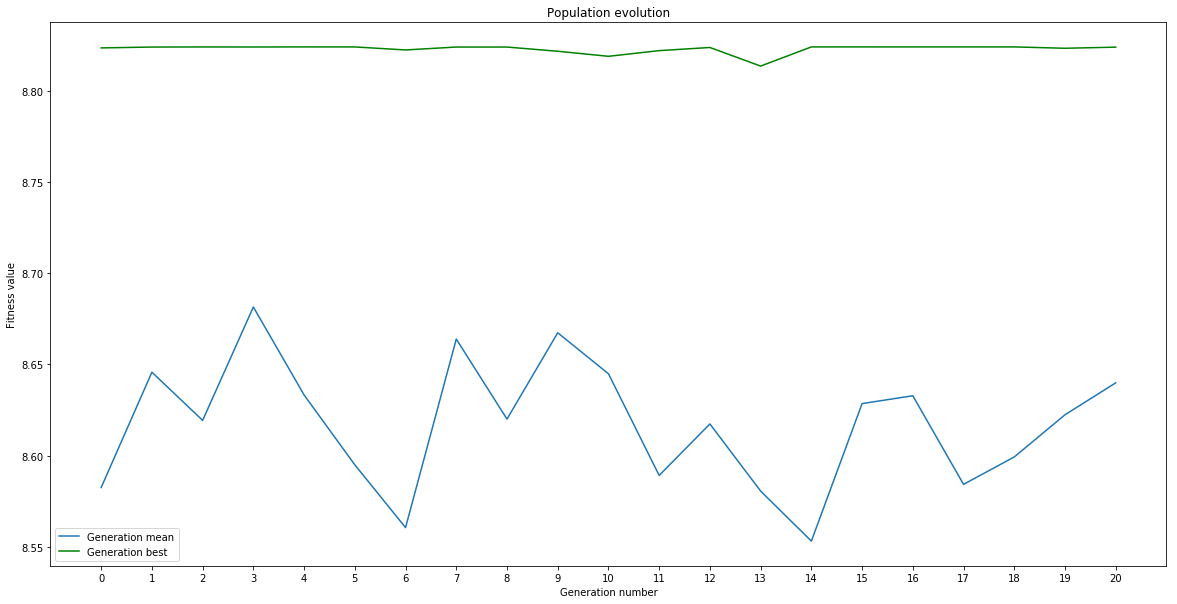

In [32]:
file_name = 'output.txt'
result_mean_generations, result_best_generations = read_GA_file(file_name)
plot_GA(result_mean_generations, result_best_generations)